# Data generation

In [1]:
import numpy as np
import torch
import scipy
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib
from arma import ode_system, solve_magi
from arma import matrix


# parameter settings
days = 20  
obs_per_day = 12
nobs = 240
MAGI_niter = 20001
X = np.arange(0, days, 1./obs_per_day)
alpha = 0.6 + 0.3 * np.cos(6.28 * X / 10)
beta = 0.75 
delta = 1. 
gamma = 1 + 0.1 * np.sin(6.28 * X / 10)
theta_true = np.vstack([alpha, gamma]).T

# data generation for 20 years with monthly observations
def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[3., 1.], linspace=1000, noise=True):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = int(i / linspace)
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha[index] * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    if noise == True:
        obs = states * np.random.normal(1, 0.03, states.shape)

    return states, obs

true_x, yobs = gen_data(alpha, beta, delta, gamma, days, obs_per_day)
true_x_torch = torch.tensor(true_x)

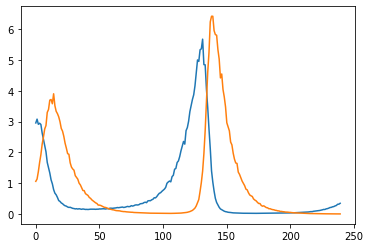

In [2]:
import matplotlib.pyplot as plt

plt.plot(yobs[:, 0])
plt.plot(yobs[:, 1])
theta_true_torch = torch.tensor(theta_true)

In [3]:
obs_per_day = 12
discretization=1
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
MAGI_niter=15001
param_names = ['alpha', 'beta', 'delta', 'gamma']
is_time_varying=[True, False, False, True]
pointwise_niter=150000
kernel_niter=20000
TVMAGI_niter=150000
phi1_lb_ls=np.array([0.1, 0.1])
phi2_lb_ls=np.array([10, 10])
use_trajectory='inferred'
learning_rate=np.array([1e-5, 1e-3, 1e-4])

# First step

In [4]:
def fOde(theta, x):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    logRdt = theta[0] * rabbit - theta[1] * rabbit * fox
    logFdt = theta[2] * rabbit * fox - theta[3] * fox
    return np.stack([logRdt, logFdt], axis=1)

def fOdeDx(theta, x):
    """
    returns ODE derivation of x given theta
    theta: list[4]
    x: array(n, 2)
    return: array(n, 2, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    resultDx = np.zeros(shape=[np.shape(x)[0], 2, 2])
    # [:, i, j]: jth equation derivative of the ith state
    # (0) / dR
    resultDx[:, 0, 0] = theta[0] - theta[0] * fox
    # (0) / dF
    resultDx[:, 1, 0] =  -theta[0] * rabbit
    # (1) / dR
    resultDx[:, 0, 1] = theta[2] * fox
    # (1) / dF
    resultDx[:, 0, 1] = theta[2] * rabbit - theta[3]
    return resultDx

def fOdeDtheta(theta, x):
    """
    returns ODE derivation of theta given x
    theta: list[4]
    x: array(n, 2)
    return: array(n, 4, 2)
    """
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 4, 2])
    # [:, i, j]: jth equation derivative of the ith theta
    rabbit = x[:, 0]
    fox = x[:, 1]
    # (0) / 0
    resultDtheta[:, 0, 0] = rabbit
    # (0) / 1
    resultDtheta[:, 1, 0] = -rabbit * fox
    # (1) / 2
    resultDtheta[:, 2, 1] = rabbit * fox
    # (1) / 3
    resultDtheta[:, 3, 1] = -fox
    return resultDtheta

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = nobs * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
# First stage: use MAGI package to optimize theta as constant
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=MAGI_niter,
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(MAGI_niter * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
    each_pycov = dict(
        Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
        Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
        mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
    )
    CovAllDimensionsPyList.append(each_pycov)

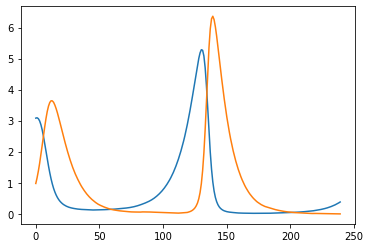

In [5]:
plt.plot(inferred_trajectory[0])
plt.plot(inferred_trajectory[1])

# Second step

In [6]:
def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    logRdt = theta[:, 0] * rabbit - constant_param_ls[0] * rabbit * fox
    logFdt = constant_param_ls[1] * rabbit * fox - theta[:, 1] * fox
    return torch.stack([logRdt, logFdt], axis=1)

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature):
    # length of observed y (t)
    n = ydata.shape[0]
    
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


# Second stage, pointwise estimation of theta
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1

if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == 0:
        param_name = param_names[thetaEachDim]
        locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=learning_rate[0])  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=100000, gamma=0.2)
for epoch in range(300000):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                        TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature)
    loss = -llik
    if epoch % 100 == 0:
        print(epoch, loss.item())
    # compute gradient and update parameters
    #     if loss < -345. and epoch > 50000:
    #         break
    loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

0 -973.2045668518408


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


100 -980.021748678658
200 -984.401631553688
300 -988.2132451723731
400 -991.6963540405359
500 -994.927585879546
600 -997.9434725924127
700 -1000.7693537913906
800 -1003.426504124938
900 -1005.9340094295899
1000 -1008.3092338647953
1100 -1010.5679128562897
1200 -1012.7241810754795
1300 -1014.790619560128
1400 -1016.778335355258
1500 -1018.6970682904082
1600 -1020.5553156359623
1700 -1022.3604649261245
1800 -1024.1189247048774
1900 -1025.8362484468182
2000 -1027.5172450595808
2100 -1029.166073622723
2200 -1030.7863216315209
2300 -1032.3810682977787
2400 -1033.9529355486777
2500 -1035.5041303473656
2600 -1037.036482374662
2700 -1038.551480168649
2800 -1040.050307424769
2900 -1041.533880730324
3000 -1043.0028883102657
3100 -1044.4578284857332
3200 -1045.8990472715034
3300 -1047.3267722077578
3400 -1048.7411428070147
3500 -1050.1422362793055
3600 -1051.530089771058
3700 -1052.904716411763
3800 -1054.2661186271448
3900 -1055.6142979844249
4000 -1056.9492635017382
4100 -1058.2710359827058
420

32500 -1200.8079720383453
32600 -1200.9413564196793
32700 -1201.0736325597486
32800 -1201.2048158943471
32900 -1201.3349104834997
33000 -1201.463927122224
33100 -1201.5918724558583
33200 -1201.7187592553337
33300 -1201.844590904593
33400 -1201.969378672199
33500 -1202.0931274460554
33600 -1202.215845330193
33700 -1202.3375395286548
33800 -1202.458216566265
33900 -1202.5778818817607
34000 -1202.696541793131
34100 -1202.8142028010532
34200 -1202.9308689600762
34300 -1203.0465462855193
34400 -1203.1612402723924
34500 -1203.2749557332552
34600 -1203.38769797218
34700 -1203.4994712919658
34800 -1203.610281046518
34900 -1203.7201310484256
35000 -1203.8290244979694
35100 -1203.9369682769488
35200 -1204.0439636170574
35300 -1204.150016160526
35400 -1204.2551275917365
35500 -1204.359304095889
35600 -1204.4625466116333
35700 -1204.564863363758
35800 -1204.6662539474241
35900 -1204.7667234172188
36000 -1204.8662782329484
36100 -1204.964921125556
36200 -1205.0626565410646
36300 -1205.1594894585814

64500 -1212.0081114278748
64600 -1212.0085236975551
64700 -1212.0089271240738
64800 -1212.0093238036948
64900 -1212.0097117647697
65000 -1212.010093045938
65100 -1212.010466415867
65200 -1212.0108317885965
65300 -1212.0111900189022
65400 -1212.0115413537046
65500 -1212.0118861601818
65600 -1212.0122222176128
65700 -1212.0125519105122
65800 -1212.0128755555913
65900 -1212.0131907498542
66000 -1212.0135015541373
66100 -1212.0138042497251
66200 -1212.0141000797746
66300 -1212.0143909704475
66400 -1212.0146749172077
66500 -1212.0149537290386
66600 -1212.0152261571195
66700 -1212.01549317537
66800 -1212.0157547814658
66900 -1212.016010187568
67000 -1212.0162607178752
67100 -1212.0165063900808
67200 -1212.01674598263
67300 -1212.0169812949002
67400 -1212.0172121998958
67500 -1212.0174388977225
67600 -1212.01766000362
67700 -1212.0178779192247
67800 -1212.0180899768263
67900 -1212.0183002701606
68000 -1212.0185049880015
68100 -1212.018705716242
68200 -1212.0189033677905
68300 -1212.0190967082

96400 -1212.026189486073
96500 -1212.0261892006615
96600 -1212.0261877934715
96700 -1212.0261891264108
96800 -1212.026189164395
96900 -1212.0261898034469
97000 -1212.0261896137324
97100 -1212.026189382772
97200 -1212.0261889319013
97300 -1212.0261892102221
97400 -1212.0261878876026
97500 -1212.0261899783773
97600 -1212.0261889851893
97700 -1212.0261895198728
97800 -1212.0261892931935
97900 -1212.0261889553772
98000 -1212.0261879294185
98100 -1212.0261892904546
98200 -1212.0261894449814
98300 -1212.0261888381506
98400 -1212.0261868571592
98500 -1212.0261893358365
98600 -1212.0261888234118
98700 -1212.026188626709
98800 -1212.0261889772632
98900 -1212.026189156692
99000 -1212.026189249828
99100 -1212.0261887867564
99200 -1212.0261880516161
99300 -1212.0261892611531
99400 -1212.026188833232
99500 -1212.0261893216075
99600 -1212.026189252321
99700 -1212.0261888233533
99800 -1212.0261893857182
99900 -1212.026189434925
100000 -1212.0261887629485
100100 -1212.0261904006152
100200 -1212.026190

127200 -1212.0261903611167
127300 -1212.0261903601054
127400 -1212.026190303741
127500 -1212.026190340272
127600 -1212.0261903577793
127700 -1212.0261903401984
127800 -1212.0261903520063
127900 -1212.0261903553187
128000 -1212.0261903594094
128100 -1212.026190349025
128200 -1212.0261903557298
128300 -1212.0261903379878
128400 -1212.026190331159
128500 -1212.0261903626651
128600 -1212.0261903390792
128700 -1212.0261903734886
128800 -1212.0261903772348
128900 -1212.026190334476
129000 -1212.0261903511132
129100 -1212.0261903522382
129200 -1212.026190360747
129300 -1212.0261903531677
129400 -1212.0261903717653
129500 -1212.026190354316
129600 -1212.0261903045596
129700 -1212.0261903438388
129800 -1212.026190339216
129900 -1212.0261903545188
130000 -1212.0261903755886
130100 -1212.026190380253
130200 -1212.026190380614
130300 -1212.0261903718842
130400 -1212.0261903483633
130500 -1212.0261903427195
130600 -1212.0261903497453
130700 -1212.026190339146
130800 -1212.0261903691885
130900 -1212

157900 -1212.026190358409
158000 -1212.026190344257
158100 -1212.0261903720973
158200 -1212.0261903187977
158300 -1212.0261903596547
158400 -1212.0261903253538
158500 -1212.0261903536689
158600 -1212.0261903237397
158700 -1212.0261903596615
158800 -1212.0261903233159
158900 -1212.0261903386895
159000 -1212.0261903220976
159100 -1212.026190360124
159200 -1212.026190346684
159300 -1212.0261903497653
159400 -1212.0261903589862
159500 -1212.0261903713458
159600 -1212.0261903550445
159700 -1212.0261903474338
159800 -1212.0261903257797
159900 -1212.0261903388687
160000 -1212.0261903241399
160100 -1212.0261903701808
160200 -1212.0261902707248
160300 -1212.0261903323387
160400 -1212.0261903387434
160500 -1212.0261903537973
160600 -1212.0261903448472
160700 -1212.0261903544244
160800 -1212.0261903650926
160900 -1212.0261903522664
161000 -1212.0261903420633
161100 -1212.0261903445476
161200 -1212.0261903608584
161300 -1212.0261903488604
161400 -1212.0261903225373
161500 -1212.0261903730143
16160

188500 -1212.0261903475043
188600 -1212.0261903568817
188700 -1212.026190355874
188800 -1212.026190352928
188900 -1212.0261903596538
189000 -1212.0261903582784
189100 -1212.0261903438231
189200 -1212.0261903640417
189300 -1212.0261903523042
189400 -1212.0261903122346
189500 -1212.026190362184
189600 -1212.0261903386422
189700 -1212.0261902760499
189800 -1212.0261903628736
189900 -1212.0261903605015
190000 -1212.0261903727637
190100 -1212.0261903423507
190200 -1212.0261903458809
190300 -1212.0261903714436
190400 -1212.0261903351216
190500 -1212.0261903374887
190600 -1212.0261903293522
190700 -1212.026190357941
190800 -1212.0261903646408
190900 -1212.0261903311189
191000 -1212.0261903624246
191100 -1212.0261903754385
191200 -1212.026190373846
191300 -1212.0261903561372
191400 -1212.0261903443143
191500 -1212.026190364024
191600 -1212.026190363155
191700 -1212.0261903463982
191800 -1212.0261903277715
191900 -1212.0261903625578
192000 -1212.0261903442697
192100 -1212.0261903348537
192200 -

219200 -1212.026190399406
219300 -1212.026190399442
219400 -1212.0261903978273
219500 -1212.0261903994601
219600 -1212.0261903986038
219700 -1212.0261903987714
219800 -1212.0261903982218
219900 -1212.026190398939
220000 -1212.0261903980836
220100 -1212.0261903984367
220200 -1212.0261903994715
220300 -1212.0261903966448
220400 -1212.0261903986775
220500 -1212.0261903986425
220600 -1212.0261903977375
220700 -1212.026190398701
220800 -1212.026190398009
220900 -1212.0261903992682
221000 -1212.026190397613
221100 -1212.0261903988157
221200 -1212.0261903976489
221300 -1212.0261903979008
221400 -1212.0261903993407
221500 -1212.0261903977118
221600 -1212.0261903990458
221700 -1212.0261903989124
221800 -1212.0261903990108
221900 -1212.026190399319
222000 -1212.026190397566
222100 -1212.0261903984083
222200 -1212.0261903990554
222300 -1212.0261903994306
222400 -1212.0261903978844
222500 -1212.026190399134
222600 -1212.0261903993078
222700 -1212.026190396562
222800 -1212.026190399335
222900 -1212

249900 -1212.0261903957053
250000 -1212.0261903980963
250100 -1212.026190398331
250200 -1212.0261903975345
250300 -1212.0261903979865
250400 -1212.0261903988935
250500 -1212.0261903991122
250600 -1212.026190398767
250700 -1212.0261903957773
250800 -1212.0261904001343
250900 -1212.0261903995415
251000 -1212.026190399294
251100 -1212.0261903990424
251200 -1212.026190397766
251300 -1212.026190396875
251400 -1212.0261903972578
251500 -1212.0261903985324
251600 -1212.0261903920996
251700 -1212.0261903988878
251800 -1212.0261903977644
251900 -1212.026190399337
252000 -1212.0261903986357
252100 -1212.0261903977826
252200 -1212.0261903983562
252300 -1212.0261903988558
252400 -1212.0261903987011
252500 -1212.0261903982246
252600 -1212.026190398768
252700 -1212.0261903989513
252800 -1212.026190398456
252900 -1212.0261903992432
253000 -1212.0261903990645
253100 -1212.0261903994974
253200 -1212.0261903976084
253300 -1212.0261903988512
253400 -1212.0261903985675
253500 -1212.0261903985074
253600 -1

280600 -1212.0261903981964
280700 -1212.0261903979656
280800 -1212.026190398219
280900 -1212.0261903987662
281000 -1212.0261903986893
281100 -1212.0261903960336
281200 -1212.026190398522
281300 -1212.0261903985097
281400 -1212.0261903963544
281500 -1212.0261903994556
281600 -1212.0261903986602
281700 -1212.026190397101
281800 -1212.0261903988107
281900 -1212.0261903991627
282000 -1212.0261903986393
282100 -1212.026190398269
282200 -1212.0261903980534
282300 -1212.0261903985763
282400 -1212.0261903962169
282500 -1212.0261903992684
282600 -1212.026190399199
282700 -1212.0261903997584
282800 -1212.0261903985693
282900 -1212.0261903998326
283000 -1212.0261903978003
283100 -1212.0261903977048
283200 -1212.0261903971232
283300 -1212.0261903980124
283400 -1212.0261903989835
283500 -1212.0261903989253
283600 -1212.0261903984315
283700 -1212.0261903996548
283800 -1212.0261903991823
283900 -1212.0261903987666
284000 -1212.0261903998758
284100 -1212.0261903992728
284200 -1212.0261903984397
284300

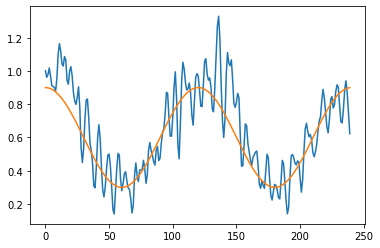

In [7]:
import matplotlib.pyplot as plt

pointwise_theta = pointwise_theta_torch.detach().numpy()
plt.plot(pointwise_theta[:, 0])
plt.plot(alpha)

In [8]:
def MaternKernel(d, phi_1, phi_2):
    """
    construct a kernel given time points and hyper parameters
    """
    a = torch.square(phi_1) * (
            1. + np.sqrt(5) * d / phi_2 + 5. * torch.square(d) / (3. * torch.square(phi_2))) * torch.exp(
        -np.sqrt(5) * d / phi_2)
    return a.double()


def kernelllik(phi_1, phi_2, sigma, y, d_matrix, phi1_lb=0.1, phi2_lb=10., sigma_lb = 0.05):
    """
    optimize the kernel hyperparameters by maximizing marginal likelihood
    """
    phi_1_bounded = torch.clamp(phi_1, min=phi1_lb)
    phi_2_bounded = torch.clamp(phi_2, min=phi2_lb)
    sigma_bounded = torch.clamp(sigma, min=sigma_lb)
    K = MaternKernel(d_matrix, phi_1, phi_2)
    K += torch.square(sigma) * torch.eye(y.shape[0]).double()
    return -y.shape[0] * np.log(np.sqrt(2 * np.pi)) - 0.5 * y @ torch.inverse(K) @ y - 0.5 * torch.logdet(K) - 1e8 * torch.square(phi_1 - phi_1_bounded) - 1e6 * torch.square(phi_2 - phi_2_bounded) - 1e6 * torch.square(sigma - sigma_bounded)

pointwise_theta = pointwise_theta_torch.detach().numpy()
hyperparamList = []
phi1_lb_ls=np.array([0.1, 0.1])
phi2_lb_ls=np.array([5., 5.])
kernel_niter=20000
# optimize the hyperparameters of kernels
for thetaEachDimension in range(pointwise_theta.shape[1]):
    phi_1 = torch.tensor(1., requires_grad=True, dtype=torch.double)
    phi_2 = torch.tensor(15.0, requires_grad=True, dtype=torch.double)
    sigma = torch.tensor(0.05, requires_grad=True, dtype=torch.double)
    kernel_optimizer = torch.optim.Adam([phi_1, phi_2, sigma], lr=learning_rate[1])
    for epoch in range(kernel_niter):
        kernel_optimizer.zero_grad()
        loss = -kernelllik(phi_1, 
                           phi_2, 
                           sigma, 
                           pointwise_theta_torch[:, thetaEachDimension] - torch.mean(pointwise_theta_torch[:, thetaEachDimension]), 
                           d_matrix, 
                           phi1_lb_ls[thetaEachDimension], 
                           phi2_lb_ls[thetaEachDimension])
        loss.backward()
        kernel_optimizer.step()
        if epoch % 100 == 0:
            print(epoch, loss.item())
    print(phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item())
    hyperparamList.append([phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()])

KthetaList = []
KinvthetaList = []
for thetaEachDimension in range(pointwise_theta.shape[1]):
    ker = MaternKernel(d_matrix, torch.tensor(hyperparamList[thetaEachDimension][0]), torch.tensor(hyperparamList[thetaEachDimension][1]))
    KthetaList.append(ker)
    KinvthetaList.append(torch.inverse(ker))

0 326.66130880011383
100 -74.32562286578968
200 -94.34191738402455
300 -100.97139777052234
400 -104.79285850556414
500 -107.74919433286453
600 -110.30791000534828
700 -112.59292158101726
800 -114.64911513620592
900 -116.5055374763657
1000 -118.18702878133837
1100 -119.71536631585411
1200 -121.10934880559421
1300 -122.38505323483486
1400 -123.55618844240723
1500 -124.634449563651
1600 -125.62983711427114
1700 -126.55093160656884
1800 -127.40512481215552
1900 -128.19881239397353
2000 -128.93755353671872
2100 -129.6262029901859
2200 -130.269020315094
2300 -130.86976039504611
2400 -131.43174858939574
2500 -131.95794329457613
2600 -132.45098817265927
2700 -132.91325588386445
2800 -133.3468848184924
2900 -133.75381004369734
3000 -134.13578945974473
3100 -134.4944259765137
3200 -134.83118637764653
3300 -135.14741741956874
3400 -135.44435961778254
3500 -135.7231590947032
3600 -135.9848777989351
3700 -136.23050235450972
3800 -136.4609517548464
3900 -136.67708408155772
4000 -136.87970239775484
4

12500 -121.30750470950795
12600 -121.3049473298259
12700 -121.30335757241068
12800 -121.30658200636168
12900 -121.30706369736771
13000 -121.30251197682117
13100 -121.29685284835239
13200 -121.30561913580016
13300 -121.30468351404909
13400 -121.30169565524318
13500 -121.30455276042574
13600 -121.30726424781915
13700 -121.30795983953294
13800 -121.30314426429766
13900 -121.3069349388768
14000 -121.30199700500043
14100 -121.30042311368254
14200 -121.30106699593188
14300 -121.30490195999386
14400 -121.30336021409227
14500 -121.30305334128434
14600 -121.3011132361255
14700 -121.30393493569363
14800 -121.30611401518058
14900 -121.30434915789868
15000 -121.30727945220707
15100 -121.30634272416881
15200 -121.30831210766775
15300 -121.30585194893581
15400 -121.30116475077017
15500 -121.3076970266003
15600 -121.30222511725697
15700 -121.3010100587926
15800 -121.29669380942482
15900 -121.30482501839413
16000 -121.29859405201745
16100 -121.30789312184936
16200 -121.3046010993325
16300 -121.3080163

# Plug in true value

In [8]:
def MaternKernel(d, phi_1, phi_2):
    """
    construct a kernel given time points and hyper parameters
    """
    a = torch.square(phi_1) * (
            1. + np.sqrt(5) * d / phi_2 + 5. * torch.square(d) / (3. * torch.square(phi_2))) * torch.exp(
        -np.sqrt(5) * d / phi_2)
    return a.double()


def kernelllik(phi_1, phi_2, sigma, y, d_matrix, phi1_lb=0.1, phi2_lb=10., sigma_lb = 0.05):
    """
    optimize the kernel hyperparameters by maximizing marginal likelihood
    """
    phi_1_bounded = torch.clamp(phi_1, min=phi1_lb)
    phi_2_bounded = torch.clamp(phi_2, min=phi2_lb)
    sigma_bounded = torch.clamp(sigma, min=sigma_lb)
    K = MaternKernel(d_matrix, phi_1, phi_2)
    K += torch.square(sigma) * torch.eye(y.shape[0]).double()
    return -y.shape[0] * np.log(np.sqrt(2 * np.pi)) - 0.5 * y @ torch.inverse(K) @ y - 0.5 * torch.logdet(K) - 1e8 * torch.square(phi_1 - phi_1_bounded) - 1e6 * torch.square(phi_2 - phi_2_bounded) - 1e6 * torch.square(sigma - sigma_bounded)


pointwise_theta = pointwise_theta_torch.detach().numpy()
theta_true_torch = torch.tensor(theta_true)
hyperparamList = []
phi1_lb_ls=np.array([0.1, 0.1])
phi2_lb_ls=np.array([1., 1.])
kernel_niter=20000
# optimize the hyperparameters of kernels
for thetaEachDimension in range(pointwise_theta.shape[1]):
    phi_1 = torch.tensor(1., requires_grad=True, dtype=torch.double)
    phi_2 = torch.tensor(15.0, requires_grad=True, dtype=torch.double)
    sigma = torch.tensor(0.05, requires_grad=True, dtype=torch.double)
    kernel_optimizer = torch.optim.Adam([phi_1, phi_2, sigma], lr=learning_rate[1])
    for epoch in range(kernel_niter):
        kernel_optimizer.zero_grad()
        loss = -kernelllik(phi_1, 
                           phi_2, 
                           sigma, 
                           theta_true_torch[:, thetaEachDimension] - torch.mean(theta_true_torch[:, thetaEachDimension]), 
                           d_matrix, 
                           phi1_lb_ls[thetaEachDimension], 
                           phi2_lb_ls[thetaEachDimension])
        loss.backward()
        kernel_optimizer.step()
        if epoch % 100 == 0:
            print(epoch, loss.item())
    print(phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item())
    hyperparamList.append([phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()])

KthetaList = []
KinvthetaList = []
for thetaEachDimension in range(pointwise_theta.shape[1]):
    ker = MaternKernel(d_matrix, torch.tensor(hyperparamList[thetaEachDimension][0]), torch.tensor(hyperparamList[thetaEachDimension][1]))
    KthetaList.append(ker)
    KinvthetaList.append(torch.inverse(ker))

0 -409.2337304551578
100 -424.5836922994797
200 -431.89265553120373
300 -437.2275049954296
400 -441.28630212495926
500 -444.47102213372403
600 -447.03006994220704
700 -449.12547670625605
800 -450.8675670876952
900 -452.3341305126563
1000 -453.5816315550641
1100 -454.6520734095409
1200 -455.57736508335154
1300 -456.38219290180353
1400 -457.0859627481994
1500 -457.70414655372394
1600 -458.2492362342556
1700 -458.73143263364517
1800 -459.15915169625976
1900 -459.5394021302755
2000 -459.8780711344763
2100 -460.1801433129927
2200 -460.44987033706116
2300 -460.6909038202465
2400 -460.9064003860618
2500 -461.09910547970446
2600 -461.2714207644286
2700 -461.4254587176046
2800 -461.56308715500626
2900 -461.68596576348756
3000 -461.7955762403649
3100 -461.89324728003817
3200 -461.9801753770352
3300 -462.0574422094275
3400 -462.12592591170653
3500 -462.18682975575746
3600 -462.2406596596499
3700 -462.2882655623711
3800 -462.330332447813
3900 -462.36696382547643
4000 -462.400316551506
4100 -462.42

13100 -479.7674790122167
13200 -479.77852749390047
13300 -479.71303916791686
13400 -479.7509232337058
13500 -479.7645676167945
13600 -479.7759672394874
13700 -479.74139970483145
13800 -479.7697316550954
13900 -479.7747765017906
14000 -479.4837729926428
14100 -479.70989052844624
14200 -479.6977365493639
14300 -479.74748213375847
14400 -479.7610989318899
14500 -479.77273553049326
14600 -479.71906018246403
14700 -479.7725878764564
14800 -479.77746810927204
14900 -479.6471365703981
15000 -479.7312368402924
15100 -479.74814020381626
15200 -479.7622761331278
15300 -479.7742432301252
15400 -479.7316998042821
15500 -479.77277002375416
15600 -479.65672139675223
15700 -479.7587349225273
15800 -479.7727445931293
15900 -479.75917099344827
16000 -479.46961124989815
16100 -479.71007303106575
16200 -479.7357931877394
16300 -479.7528426164599
16400 -479.7671657060977
16500 -479.77870820328764
16600 -479.75969596656256
16700 -479.77512414270393
16800 -479.7465611290758
16900 -479.7742609390473
17000 -4

# Third stage (LU)

In [9]:
# def fOdeTorch_LU(theta_LU, x, constant_param_ls, TV_theta_mean, KthetaluList):
#     """
#     theta: list[4]: beta, ve, vi, pd
#     x: array(n, 4)
#     r: array(n, 2)
#     """
#     # LU decomposition
#     rabbit = x[:, 0]
#     fox = x[:, 1]
#     logRdt = (KthetaluList[0] @ theta_LU[:, 0]  + TV_theta_mean[0]) * rabbit - constant_param_ls[0] * rabbit * fox
#     logFdt = constant_param_ls[1] * rabbit * fox - (KthetaluList[1] @ theta_LU[:, 1]+ TV_theta_mean[1]) * fox
#     return torch.stack([logRdt, logFdt], axis=1)

# def xthetasigmallikTorch(xlatent, theta_LU, time_constant_param_ls, sigma, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch_LU,
#                          priorTemperature, KthetaluList):
#     # length of observed y (t)
#     n = ydata.shape[0]
#     pdimension = ydata.shape[1]
#     thetadimension = theta_LU.shape[1]
#     sigmaSq = torch.pow(sigma, 2)
#     fderiv = fOdeTorch_LU(theta_LU, xlatent, time_constant_param_ls, TV_theta_mean, KthetaluList)
#     res = torch.zeros([pdimension, 3]).double()
#     res_theta = torch.zeros(thetadimension).double()
#     res2 = torch.zeros(1).double()
#     fitDerivError = torch.zeros([n, pdimension]).double()
#     nobs = torch.zeros([pdimension]).double()
#     fitLevelErrorSumSq = torch.zeros([pdimension]).double()
#     for vEachDim in range(pdimension):
#         fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
#         fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
#         nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
#         obsIdx = torch.isfinite(ydata[:, vEachDim])
#         fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
#     res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
#     res[:, 0] /= priorTemperature[2]
#     KinvfitDerivError = torch.zeros([n, pdimension]).double()
#     CinvX = torch.zeros([n, pdimension]).double()
#     for vEachDim in range(pdimension):
#         # inverse of K
#         KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
#         # inverse of Cd
#         CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
#     for thetaEachDim in range(thetadimension):
#         res_theta[thetaEachDim] = -0.5 * torch.sum(torch.square(theta_LU[:, thetaEachDim]))
#     res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
#     res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

#     return torch.sum(res) + torch.sum(res_theta) 

# TVMAGI_xlatent_torch = torch.tensor(pointwise_xlatent_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
# TVMAGI_theta_torch = torch.tensor(pointwise_theta_torch.detach().numpy(), dtype=torch.double)
# TVMAGI_theta_torch_LU = torch.zeros(TVMAGI_theta_torch.shape).double()
# for thetaEachDim in range(TVMAGI_theta_torch.shape[1]):
#     TVMAGI_theta_torch_LU[:, thetaEachDim] = KinvthetaluList[thetaEachDim] @ (TVMAGI_theta_torch[:, thetaEachDim] - TV_theta_mean[thetaEachDim])
# TVMAGI_theta_torch_LU.requires_grad = True
# TVMAGI_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
# TVMAGI_optimizer = torch.optim.Adam([TVMAGI_xlatent_torch, TVMAGI_theta_torch_LU, TVMAGI_sigma_torch] + time_constant_param_ls, lr=1e-3)
# for epoch in range(TVMAGI_niter):
#     TVMAGI_optimizer.zero_grad()
#     # compute loss function
#     llik = xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch_LU, time_constant_param_ls, TVMAGI_sigma_torch,
#                                                 TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch_LU,
#                                                 priorTemperature, KthetaluList)
#     loss = -llik
#     if epoch % 100 == 0:
#         print(epoch, loss.item())
#     loss.backward()
#     TVMAGI_optimizer.step()

NameError: name 'KinvthetaluList' is not defined

In [58]:
KinvthetaluList[0] @ KthetaluList[0]

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-7.7074e-14,  1.0000e+00,  3.9611e-17,  ..., -5.4841e-43,
         -8.5665e-43, -1.7378e-44],
        [ 1.0616e-12, -2.5168e-14,  1.0000e+00,  ...,  3.8584e-41,
          1.5492e-41, -2.6251e-42],
        ...,
        [-6.3154e-13, -1.4313e-12, -1.3833e-12,  ...,  1.0000e+00,
         -3.0044e-15, -2.5690e-15],
        [-1.3988e-12, -4.5745e-13,  3.9941e-14,  ...,  7.5448e-15,
          1.0000e+00,  2.4044e-15],
        [-9.7972e-13,  2.2368e-12,  9.8916e-13,  ..., -1.6441e-15,
         -1.3581e-15,  1.0000e+00]], dtype=torch.float64)

# No LU

In [9]:
def xthetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                         priorTemperature,
                         KinvthetaList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    res2 = torch.zeros(1).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(
            (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ KinvthetaList[thetaEachDim] @ (
                    theta[:, thetaEachDim] - inferred_theta[thetaEachDim]))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return torch.sum(res) + torch.sum(res_theta)

priorTemperature = torch.tensor([1., 1., 1.])
TVMAGI_xlatent_torch = torch.tensor(pointwise_xlatent_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
TVMAGI_theta_torch = torch.tensor(pointwise_theta_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
TVMAGI_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
TVMAGI_optimizer = torch.optim.Adam([TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch] + time_constant_param_ls, lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(TVMAGI_optimizer, step_size=100000, gamma=0.2)
LossVal = np.zeros(200000)
for epoch in range(200000):
    TVMAGI_optimizer.zero_grad()
    # compute loss function
    llik = xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch, time_constant_param_ls, TVMAGI_sigma_torch,
                                                TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                priorTemperature, KinvthetaList)
    loss = -llik
    if epoch % 100 == 0:
        print(epoch, loss.item())
    LossVal[epoch] = loss.item()
    loss.backward()
    TVMAGI_optimizer.step()
    lr_scheduler.step()

0 1060832553.8174324
100 733838108.347497
200 563753575.9661348
300 455573953.3238097
400 378296252.28141224
500 319184166.02448875
600 272451240.283825
700 234876112.4995142
800 204309037.917833
900 179179204.74402478
1000 158302942.71774778
1100 140780917.60531268
1200 125926744.58776124
1300 113212938.25795169
1400 102230405.5091975
1500 92659005.36966032
1600 84246504.08853509
1700 76793401.05590312
1800 70141654.83434358
1900 64165990.93960037
2000 58767004.4958215
2100 53865614.35393084
2200 49398608.69298774
2300 45315100.26587981
2400 41573735.41192529
2500 38140533.691969946
2600 34987218.718470395
2700 32089926.690014586
2800 29428212.464788597
2900 26984284.485338647
3000 24742403.127565067
3100 22688399.802833363
3200 20809316.828355826
3300 19093121.17105456
3400 17528485.10398118
3500 16104625.190880267
3600 14811197.70987867
3700 13638228.774688944
3800 12576075.266122553
3900 11615421.17653725
4000 10747290.108504511
4100 9963071.308890585
4200 9254554.984371394
4300 86

34100 -110.6816151754665
34200 -140.34045789277616
34300 -26.78634159594617
34400 -106.12769679456983
34500 -170.26623849645648
34600 -143.61989227223648
34700 -185.66668832387586
34800 -20.770583251823837
34900 -155.3471715114374
35000 -206.62715140309956
35100 -72.43031052374636
35200 -134.12411352085837
35300 -99.05958538226787
35400 -225.57985054093342
35500 -233.50731440089112
35600 -206.3920210661754
35700 -190.9436838308652
35800 -235.57352206513247
35900 -166.74978885970268
36000 -238.63647025006776
36100 -270.74103879774293
36200 -218.27869255160795
36300 -281.813051786492
36400 -273.77964627971573
36500 -270.6105404632433
36600 -270.9294153886534
36700 -229.15710963533252
36800 -156.24261037747146
36900 -289.1048901154677
37000 -318.6825036907496
37100 -327.26502657537594
37200 -331.6829633766856
37300 -297.3805592441456
37400 -273.3174720535859
37500 -331.4956269955626
37600 -336.14470937057513
37700 -348.4382407812009
37800 -328.79963442431995
37900 -353.97162432295977
3800

66800 -831.1484974835344
66900 -850.0975647195264
67000 -826.8640162431086
67100 -848.577013228793
67200 -843.6426853522994
67300 -850.8187574364206
67400 -846.323885565083
67500 -854.6580380725902
67600 -852.2260439090437
67700 -855.6303079069644
67800 -854.7793936680573
67900 -693.2778603411825
68000 -804.6671131242313
68100 -797.6458926347279
68200 -802.0723961091912
68300 -605.7190402461392
68400 -860.8999961302393
68500 -855.2087619129388
68600 -821.2173303193526
68700 -690.6171044663597
68800 -855.1305628991761
68900 -814.6907945985861
69000 -853.6278505732384
69100 -826.0756673459937
69200 -852.832089753346
69300 -785.3267991178645
69400 -843.0640121067695
69500 -850.6472378939413
69600 -862.072375459959
69700 -849.9002588107908
69800 -856.0394191016862
69900 -817.9746340534098
70000 -868.0149418684327
70100 -869.513470979289
70200 -862.3249794146259
70300 -761.4832855828986
70400 -842.3924984631267
70500 -866.6540715832953
70600 -833.6704651618797
70700 -868.1556103508021
70800

99800 -787.3845120363762
99900 -960.9541944253142
100000 -936.712158921915
100100 -967.4267791066753
100200 -967.4702015085736
100300 -967.515424052955
100400 -967.5629396523007
100500 -967.6128613074662
100600 -967.6653094639905
100700 -967.7204093754407
100800 -967.7782949424422
100900 -967.8391011374313
101000 -967.9029769604554
101100 -967.970071979347
101200 -968.0405476717947
101300 -968.1145715099316
101400 -968.1923115100376
101500 -968.2739562114148
101600 -968.3596990977072
101700 -968.4497341030815
101800 -968.5442799135615
101900 -968.643548609618
102000 -968.7477740735894
102100 -968.8571906609008
102200 -968.9720590659113
102300 -969.0926320672286
102400 -969.2191862981705
102500 -969.3520107139415
102600 -969.4914026996191
102700 -969.6376697074797
102800 -969.7911406637132
102900 -969.952155245326
103000 -970.1210662659871
103100 -970.2982403152257
103200 -970.4840605862621
103300 -970.6762686616997
103400 -970.798454696303
103500 -971.015474027572
103600 -971.186650262

131200 -1007.4384530658349
131300 -1006.7118501333925
131400 -1006.2253990350619
131500 -1008.1525574453544
131600 -1009.8597423848214
131700 -1010.2790054332736
131800 -1010.6584042414838
131900 -1008.2167396322404
132000 -1009.2136153670897
132100 -1010.5998080172969
132200 -1011.1028551416216
132300 -1010.7708515607753
132400 -1010.7431287718475
132500 -1010.2951749958124
132600 -1010.4872801536735
132700 -1011.3471212267418
132800 -1010.2092208722121
132900 -1011.2726439060784
133000 -1010.0392266229605
133100 -1011.72620007772
133200 -1012.0283644409302
133300 -998.7836987515007
133400 -1003.8570165991355
133500 -1010.9046462296208
133600 -1012.1431672509364
133700 -1009.4951719813985
133800 -1010.7938147099661
133900 -1012.451470616793
134000 -1012.8776240113395
134100 -1013.024295635684
134200 -1012.7010843292044
134300 -1005.7650039271944
134400 -1009.6011373298193
134500 -1011.4352652393184
134600 -1010.5916932469021
134700 -1009.842582780753
134800 -1013.0061361685875
134900 

161800 -1032.250373676689
161900 -1033.9354458293506
162000 -1035.1279874744434
162100 -1030.1786094336803
162200 -1029.9123385268474
162300 -1035.1272798573107
162400 -1033.596161907456
162500 -1034.2568325901264
162600 -1034.6174952505612
162700 -1035.6059314885483
162800 -1033.9601209308798
162900 -1034.4632737232214
163000 -1035.7141368709083
163100 -1035.4383348097113
163200 -1036.1010867562718
163300 -1032.6056854223252
163400 -1036.1444344677716
163500 -1035.409670351189
163600 -1033.3168464714572
163700 -1035.7537822425534
163800 -1035.92283126851
163900 -1035.57151858914
164000 -1036.1173918471795
164100 -1035.743908805093
164200 -1036.6507816002004
164300 -1036.8396874617515
164400 -1034.5943513698494
164500 -1036.683840699999
164600 -1036.2458367159456
164700 -1036.8287234741772
164800 -1032.4163959200343
164900 -1034.849720417988
165000 -1036.5961284874875
165100 -1036.683394349484
165200 -1034.6485263187658
165300 -1035.4209030774089
165400 -1036.0867669581653
165500 -1036

192400 -1048.6954960796727
192500 -1049.7966673164997
192600 -1050.4978203129992
192700 -1049.5135095772898
192800 -1051.1564294709292
192900 -1047.3967767375343
193000 -1051.4976894594258
193100 -1050.9176533157538
193200 -1051.2416875107178
193300 -1051.4485308699896
193400 -1049.3872105655628
193500 -1049.495755949843
193600 -1051.4743900763685
193700 -1050.8789458395186
193800 -1051.5615133246888
193900 -1050.175712078063
194000 -1050.8246121024276
194100 -1051.3876526976765
194200 -1048.3735681959843
194300 -1051.2626216055571
194400 -1051.8250081542114
194500 -1049.9875243091196
194600 -1051.258591433928
194700 -1050.4957090460723
194800 -1050.9803089207294
194900 -1052.25141877577
195000 -1052.2985870899092
195100 -1050.4732793732414
195200 -1046.7107063631809
195300 -1051.3169873072113
195400 -1052.2925230581998
195500 -1052.359314875598
195600 -1050.6285174208888
195700 -1052.4988693078158
195800 -1052.0993867321408
195900 -1052.5196802386754
196000 -1047.8126711628006
196100 

Text(0.5, 1.0, 'Adam Trace Plot (LV)')

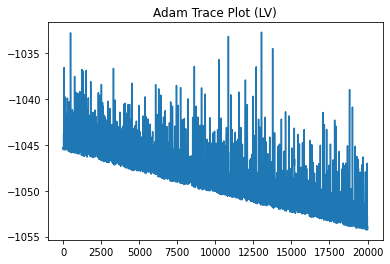

In [10]:
plt.plot(LossVal[-20000:])
plt.title('Adam Trace Plot (LV)')

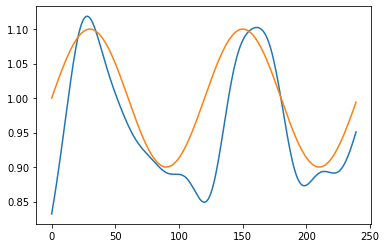

In [11]:
TV_theta = TVMAGI_theta_torch.detach().numpy()
plt.plot(TV_theta[:, 1])
plt.plot(gamma)
# y = xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch, time_constant_param_ls, TVMAGI_sigma_torch,
#                                                 TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
#                                                 priorTemperature, KinvthetaList)
# y.backward()
# TVMAGI_theta_torch.grad

# HMC sampler

In [96]:
def vectorize(xlatent, theta, sigma, time_constant_param_ls):
    t1 = torch.reshape(xlatent.detach(), (-1,))
    t2 = torch.reshape(theta.detach(), (-1,))
    t3 = torch.reshape(sigma.detach(), (-1,))
    long_vec = torch.cat((t1, t2, t3))
    for i in range(len(time_constant_param_ls)):
        long_vec = torch.cat((long_vec, time_constant_param_ls[i].detach()))
    return long_vec

def get_dim(tensor_shape):
    if len(tensor_shape) == 0:
        return 1
    if len(tensor_shape) == 1:
        return tensor_shape[0]
    dim = 1
    for i in range(len(tensor_shape)):
        dim *= tensor_shape[i]
    return dim
    
def devectorize(long_tensor, xlatent_shape, theta_shape, sigma_shape, time_constant_param_dim):
    x_latent_dim = get_dim(xlatent_shape)
    theta_dim = get_dim(theta_shape)
    sigma_dim = get_dim(sigma_shape)
    time_constant_param_ls = []
    xlatent = torch.reshape(long_tensor[:x_latent_dim],xlatent_shape)
    theta = torch.reshape(long_tensor[x_latent_dim:x_latent_dim + theta_dim],theta_shape)
    sigma = torch.reshape(long_tensor[x_latent_dim + theta_dim:x_latent_dim + theta_dim + sigma_dim],sigma_shape)
    for each in range(x_latent_dim + theta_dim + sigma_dim, long_tensor.shape[0]):
        time_constant_param_ls.append(torch.tensor([long_tensor[each]]))
    return xlatent, theta, sigma, time_constant_param_ls


def NegLogLikelihood(xlatent, theta, time_constant_param_ls, sigma, 
                     inferred_theta = inferred_theta, 
                     ydata = ydata, 
                     CovAllDimensionsPyList = CovAllDimensionsPyList, 
                     fOdeTorch = fOdeTorch,
                     priorTemperature = priorTemperature, 
                     KinvthetaList = KinvthetaList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(
            (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ KinvthetaList[thetaEachDim] @ (
                    theta[:, thetaEachDim] - inferred_theta[thetaEachDim]))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return -(torch.sum(res) + torch.sum(res_theta))

# return value / Temperature
class HMC:
    def __init__(self, negllik, all_theta, xlatent_shape, theta_shape, sigma_shape, time_constant_param_ls):
        self.all_theta = all_theta
        self.theta_shape = theta_shape
        self.xlatent_shape = xlatent_shape
        self.sigma_shape = sigma_shape
        self.constant_dim = len(time_constant_param_ls)
        self.NegLogLikelihood = negllik
    
    def NegLogLikelihood_vec(self, all_theta):
        xlatent_0, theta_0, sigma_0, constant_param_ls_0 = devectorize(all_theta, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
        return NegLogLikelihood(xlatent_0, theta_0, constant_param_ls_0, sigma_0)
    # Nabla / temperature
    def Nabla(self, theta_torch, temperature):
        theta_torch = theta_torch.detach()
        xlatent, theta, sigma, constant_param_ls = devectorize(theta_torch, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
        xlatent.requires_grad = True  
        theta.requires_grad = True
        sigma.requires_grad = True
        for each in constant_param_ls:
            each.requires_grad = True                      
        llik = self.NegLogLikelihood(xlatent, theta, constant_param_ls, sigma)
        llik.backward()
        constant_param_deriv_ls = []
        for each in constant_param_ls:
            constant_param_deriv_ls.append(each.grad)
        v = vectorize(xlatent.grad, theta.grad, sigma.grad, constant_param_deriv_ls)
        return v / temperature

    def parallelTempering(self, t1, t2, cur_theta_1, cur_theta_2, n_samples, step_size = 1e-6, burn_in_ratio = 0.5):
        total_samples = int(n_samples / (1 - burn_in_ratio))
        acceptance_ls_1 = np.zeros(total_samples)
        acceptance_ls_2 = np.zeros(total_samples)
        trace_val_1 = np.zeros(total_samples)
        trace_val_2 = np.zeros(total_samples)
        samples_1 = np.zeros((total_samples, cur_theta_1.shape[0]))
        samples_2 = np.zeros((total_samples, cur_theta_1.shape[0]))
        epsilon_1 = step_size * torch.ones(cur_theta_1.shape)
        epsilon_2 = step_size * torch.ones(cur_theta_1.shape)
        switch = 0
        switch_random = np.random.uniform(0, 1, total_samples)
        switch_ls = np.zeros(total_samples)
        for EachIter in range(total_samples):
            new_theta_1, is_accepted_1, cur_H_1, nllik_1 = self.one_sample(cur_theta_1, epsilon_1, t1)
            cur_theta_1 = new_theta_1.clone()
            new_theta_2, is_accepted_2, cur_H_2, nllik_2 = self.one_sample(cur_theta_2, epsilon_2, t2)
            cur_theta_2 = new_theta_2.clone()
            
            if EachIter % 5 == 0:
                if torch.exp((1. / t1 - 1. / t2) * (cur_H_2 - cur_H_1)) > switch_random[EachIter]:
                    switch += 1
                    print('Iter ', EachIter, ': Switch!')
            
            if switch % 2 == 0:           
                samples_1[EachIter] = new_theta_1.numpy()
                acceptance_ls_1[EachIter] = is_accepted_1
                trace_val_1[EachIter] = nllik_1

                samples_2[EachIter] = new_theta_2.numpy()
                acceptance_ls_2[EachIter] = is_accepted_2
                trace_val_2[EachIter] = nllik_2
            else:
                samples_1[EachIter] = new_theta_2.numpy()
                acceptance_ls_1[EachIter] = is_accepted_2
                trace_val_1[EachIter] = nllik_2

                samples_2[EachIter] = new_theta_1.numpy()
                acceptance_ls_2[EachIter] = is_accepted_1
                trace_val_2[EachIter] = nllik_1
            
            
            
            if EachIter > 200 and EachIter < total_samples - n_samples:
                if np.sum(acceptance_ls_1[EachIter - 100 : EachIter]) < 50:
                    # decrease epsilon
                    epsilon_1 *= 0.9
                if np.sum(acceptance_ls_1[EachIter - 100 : EachIter]) > 80:
                    # increase epsilon
                    epsilon_1 *= 1.005
                if np.sum(acceptance_ls_2[EachIter - 100 : EachIter]) < 50:
                    # decrease epsilon
                    epsilon_2 *= 0.9
                if np.sum(acceptance_ls_2[EachIter - 100 : EachIter]) > 80:
                    # increase epsilon
                    epsilon_2 *= 1.005
            if EachIter % 20 == 0 and EachIter > 20:
                print(EachIter)
                print('cur_nllik: ', nllik_1, nllik_2)
            if EachIter % 100 == 0 and EachIter > 100 and EachIter < total_samples - n_samples:
                print('acceptance rate: ', np.sum(acceptance_ls_1[EachIter - 100 : EachIter]) / 100)
                standard_deviation_1 = torch.tensor(np.std(samples_1[EachIter - 100:EachIter, :], axis = 0))
                standard_deviation_2 = torch.tensor(np.std(samples_2[EachIter - 100:EachIter, :], axis = 0))
                if torch.mean(standard_deviation_1) > 1e-6:
                    epsilon_1 = 0.05 * standard_deviation_1 * torch.mean(epsilon_1) / torch.mean(standard_deviation_1) + 0.95 * epsilon_1
                if torch.mean(standard_deviation_2) > 1e-6:
                    epsilon_2 = 0.05 * standard_deviation_2 * torch.mean(epsilon_2) / torch.mean(standard_deviation_2) + 0.95 * epsilon_2
        return samples_1, samples_2, trace_val_1, trace_val_2 # [self.total_samples-self.n_samples:, :]
           



    def HMC_samples(self, cur_theta, temperature, n_samples, step_size = 1e-6, burn_in_ratio = 0.5):
        total_samples = int(n_samples / (1 - burn_in_ratio))
        acceptance_ls = np.zeros(total_samples)
        trace_val = np.zeros(total_samples)
        samples = np.zeros((total_samples, cur_theta.shape[0]))
        epsilon = step_size * torch.ones(cur_theta.shape[0])
        cur_H = torch.tensor(float('inf'))
        for EachIter in range(total_samples):
            if EachIter % 20 == 0 and EachIter > 10:
                print(EachIter)
                print(nllik, new_H, epsilon[0])
            new_theta, is_accepted, new_H, nllik = self.one_sample(cur_theta, epsilon, temperature)
            cur_theta = new_theta.clone()
            cur_H = new_H
            samples[EachIter] = new_theta.numpy()
            acceptance_ls[EachIter] = is_accepted
            trace_val[EachIter] = nllik
            if EachIter > 200 and EachIter < total_samples - n_samples:
                if np.sum(acceptance_ls[EachIter - 100 : EachIter]) < 50:
                    # decrease epsilon
                    epsilon *= 0.995
                if np.sum(acceptance_ls[EachIter - 100 : EachIter]) > 80:
                    # increase epsilon
                    epsilon *= 1.005

            if EachIter % 100 == 0 and EachIter > 100 and EachIter < total_samples - n_samples:
                print('acceptance rate: ', np.sum(acceptance_ls[EachIter - 100 : EachIter]) / 100)
                standard_deviation = torch.tensor(np.std(samples[EachIter - 100:EachIter, :], axis = 0))
                if torch.mean(standard_deviation) > 1e-6:
                    epsilon = 0.05 * standard_deviation * torch.mean(epsilon) / torch.mean(standard_deviation) + 0.95 * epsilon
        return samples, acceptance_ls, trace_val
            
    def one_sample(self, all_theta, epsilon, temperature, lb = torch.zeros(all_theta.shape), ub = None, lsteps=50):
        def bounce(m, lb, ub):
            if lb is None and ub is None:
                return m
            if lb is None:
                max_tensor = torch.clamp(m - ub, min=0)
                return m - 2 * max_tensor
            if ub is None:
                min_tensor = torch.clamp(lb - m, min=0)
                return m + 2 * min_tensor
            if torch.sum(lb < ub) < m.shape[0]:
                raise ValueError
            if torch.sum(m >= lb) == m.shape[0] and torch.sum(m <= ub) == m.shape[0]:
                return m
            if torch.sum(m >= lb) < m.shape[0]:
                min_tensor = torch.clamp(lb - m, min=0)
                return bounce(m + 2 * min_tensor, lb, ub)
            if torch.sum(m <= ub) < m.shape[0]:
                max_tensor = torch.clamp(m - ub, min=0)
                return bounce(m - 2 * max_tensor, lb, ub)
        # temperature 1
        random_u = np.random.uniform(0, 1, 1)
        cur_theta = all_theta.clone().detach()
        rstep = torch.rand(epsilon.shape) * epsilon + epsilon
        p = torch.normal(mean=0., std=torch.ones(self.all_theta.shape))
        cur_p = p.clone()
        theta = cur_theta.clone()         
        p = p - rstep * self.Nabla(theta, temperature).clone() / 2
        for i in range(lsteps):
            theta = theta + rstep * p
            nabla_torch = self.Nabla(theta, temperature).clone()
            p = p - rstep * nabla_torch
            theta = bounce(theta, lb, ub)

        p = p - rstep * self.Nabla(theta, temperature).clone() / 2

        new_nllik = self.NegLogLikelihood_vec(theta)
        new_p = 0.5 * torch.sum(torch.square(p))
        new_H = new_nllik + new_p
        cur_nllik = self.NegLogLikelihood_vec(cur_theta).detach()
        cur_H = cur_nllik + 0.5 * torch.sum(torch.square(cur_p))

        if torch.isnan(theta[0]) or torch.isnan(new_H):
            new_sample = cur_theta.clone()
            nan_ls[EachIter] = 1
            self.epsilon *= 0.9
            print('NaN: ', new_H, cur_H)
            return cur_theta.clone(), 0, cur_H, cur_nllik
        else:
            # accept
            tmp = float(torch.exp((cur_nllik - new_nllik) / temperature) + 0.5 * torch.sum(torch.square(cur_p)) - new_p)
            if  tmp > random_u:
                print('Accept: ', new_H, cur_H)
                return theta.clone(), 1, new_H, new_nllik
            # reject
            else:
                print('Reject:', new_H, cur_H)
                return cur_theta.clone(), 0, cur_H, cur_nllik
                    
     

            

all_theta = vectorize(TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
# all_theta_true = vectorize(true_x_torch, theta_true_torch, sigma_torch, time_constant_param_ls)
all_theta_pointwise = vectorize(pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch, time_constant_param_ls)
sampler = HMC(NegLogLikelihood, all_theta_pointwise, 
              pointwise_xlatent_torch.shape,
              pointwise_theta_torch.shape, 
              sigma_torch.shape,
              time_constant_param_ls)
# sampler.Nabla(all_theta)
# samples, b, c = sampler.one_sample(all_theta, epsilon, 10)
samples_1, samples_2, trace_val = sampler.HMC_samples(all_theta_pointwise, temperature = 2000., n_samples = 8000)
# 
# print(sampler.NegLogLikelihood_vec(all_theta))
# sampler.sample(all_theta)
# 20 l step
# epsilon random start epsilon to 2 epsilon
# print(samples, b, c)
# 0.6085,  1.7266, -1.5486, -1.1349,  2.5751], dtype=torch.float64

Accept:  tensor(1.0390e+09, dtype=torch.float64) tensor(1.0608e+09, dtype=torch.float64)
Accept:  tensor(1.0185e+09, dtype=torch.float64) tensor(1.0390e+09, dtype=torch.float64)
Accept:  tensor(9.9987e+08, dtype=torch.float64) tensor(1.0185e+09, dtype=torch.float64)
Accept:  tensor(9.8151e+08, dtype=torch.float64) tensor(9.9986e+08, dtype=torch.float64)
Accept:  tensor(9.6484e+08, dtype=torch.float64) tensor(9.8150e+08, dtype=torch.float64)
Accept:  tensor(9.4971e+08, dtype=torch.float64) tensor(9.6483e+08, dtype=torch.float64)
Accept:  tensor(9.3339e+08, dtype=torch.float64) tensor(9.4971e+08, dtype=torch.float64)
Accept:  tensor(9.1850e+08, dtype=torch.float64) tensor(9.3338e+08, dtype=torch.float64)
Accept:  tensor(9.0502e+08, dtype=torch.float64) tensor(9.1849e+08, dtype=torch.float64)
Accept:  tensor(8.9154e+08, dtype=torch.float64) tensor(9.0502e+08, dtype=torch.float64)
Accept:  tensor(8.7910e+08, dtype=torch.float64) tensor(8.9154e+08, dtype=torch.float64)
Accept:  tensor(8.663

Accept:  tensor(4.8939e+08, dtype=torch.float64) tensor(4.9174e+08, dtype=torch.float64)
Accept:  tensor(4.8711e+08, dtype=torch.float64) tensor(4.8939e+08, dtype=torch.float64)
Accept:  tensor(4.8501e+08, dtype=torch.float64) tensor(4.8710e+08, dtype=torch.float64)
Accept:  tensor(4.8294e+08, dtype=torch.float64) tensor(4.8501e+08, dtype=torch.float64)
Accept:  tensor(4.8085e+08, dtype=torch.float64) tensor(4.8294e+08, dtype=torch.float64)
Accept:  tensor(4.7875e+08, dtype=torch.float64) tensor(4.8085e+08, dtype=torch.float64)
Accept:  tensor(4.7671e+08, dtype=torch.float64) tensor(4.7875e+08, dtype=torch.float64)
Accept:  tensor(4.7468e+08, dtype=torch.float64) tensor(4.7671e+08, dtype=torch.float64)
Accept:  tensor(4.7260e+08, dtype=torch.float64) tensor(4.7467e+08, dtype=torch.float64)
Accept:  tensor(4.7035e+08, dtype=torch.float64) tensor(4.7259e+08, dtype=torch.float64)
Accept:  tensor(4.6851e+08, dtype=torch.float64) tensor(4.7035e+08, dtype=torch.float64)
Accept:  tensor(4.667

Accept:  tensor(3.6344e+08, dtype=torch.float64) tensor(3.6446e+08, dtype=torch.float64)
Accept:  tensor(3.6239e+08, dtype=torch.float64) tensor(3.6344e+08, dtype=torch.float64)
Accept:  tensor(3.6137e+08, dtype=torch.float64) tensor(3.6239e+08, dtype=torch.float64)
Accept:  tensor(3.6057e+08, dtype=torch.float64) tensor(3.6137e+08, dtype=torch.float64)
180
tensor(3.6057e+08, dtype=torch.float64) tensor(3.6057e+08, dtype=torch.float64) tensor(1.0000e-06)
Accept:  tensor(3.5952e+08, dtype=torch.float64) tensor(3.6057e+08, dtype=torch.float64)
Accept:  tensor(3.5857e+08, dtype=torch.float64) tensor(3.5952e+08, dtype=torch.float64)
Accept:  tensor(3.5762e+08, dtype=torch.float64) tensor(3.5857e+08, dtype=torch.float64)
Accept:  tensor(3.5671e+08, dtype=torch.float64) tensor(3.5762e+08, dtype=torch.float64)
Accept:  tensor(3.5568e+08, dtype=torch.float64) tensor(3.5671e+08, dtype=torch.float64)
Accept:  tensor(3.5482e+08, dtype=torch.float64) tensor(3.5568e+08, dtype=torch.float64)
Accept:

Accept:  tensor(2.6539e+08, dtype=torch.float64) tensor(2.6668e+08, dtype=torch.float64)
Accept:  tensor(2.6416e+08, dtype=torch.float64) tensor(2.6539e+08, dtype=torch.float64)
Accept:  tensor(2.6298e+08, dtype=torch.float64) tensor(2.6416e+08, dtype=torch.float64)
Accept:  tensor(2.6175e+08, dtype=torch.float64) tensor(2.6298e+08, dtype=torch.float64)
Accept:  tensor(2.6063e+08, dtype=torch.float64) tensor(2.6175e+08, dtype=torch.float64)
Accept:  tensor(2.5950e+08, dtype=torch.float64) tensor(2.6063e+08, dtype=torch.float64)
Accept:  tensor(2.5815e+08, dtype=torch.float64) tensor(2.5949e+08, dtype=torch.float64)
Accept:  tensor(2.5688e+08, dtype=torch.float64) tensor(2.5815e+08, dtype=torch.float64)
Accept:  tensor(2.5562e+08, dtype=torch.float64) tensor(2.5688e+08, dtype=torch.float64)
Accept:  tensor(2.5443e+08, dtype=torch.float64) tensor(2.5562e+08, dtype=torch.float64)
Accept:  tensor(2.5332e+08, dtype=torch.float64) tensor(2.5443e+08, dtype=torch.float64)
Accept:  tensor(2.522

Accept:  tensor(1.5004e+08, dtype=torch.float64) tensor(1.5116e+08, dtype=torch.float64)
Accept:  tensor(1.4871e+08, dtype=torch.float64) tensor(1.5004e+08, dtype=torch.float64)
Accept:  tensor(1.4751e+08, dtype=torch.float64) tensor(1.4871e+08, dtype=torch.float64)
Accept:  tensor(1.4615e+08, dtype=torch.float64) tensor(1.4751e+08, dtype=torch.float64)
Accept:  tensor(1.4490e+08, dtype=torch.float64) tensor(1.4615e+08, dtype=torch.float64)
Accept:  tensor(1.4370e+08, dtype=torch.float64) tensor(1.4490e+08, dtype=torch.float64)
Accept:  tensor(1.4252e+08, dtype=torch.float64) tensor(1.4369e+08, dtype=torch.float64)
Accept:  tensor(1.4127e+08, dtype=torch.float64) tensor(1.4251e+08, dtype=torch.float64)
Accept:  tensor(1.4013e+08, dtype=torch.float64) tensor(1.4127e+08, dtype=torch.float64)
Accept:  tensor(1.3898e+08, dtype=torch.float64) tensor(1.4013e+08, dtype=torch.float64)
Accept:  tensor(1.3777e+08, dtype=torch.float64) tensor(1.3898e+08, dtype=torch.float64)
360
tensor(1.3777e+08

Accept:  tensor(66775340.9035, dtype=torch.float64) tensor(67500304.8930, dtype=torch.float64)
Accept:  tensor(66103043.2051, dtype=torch.float64) tensor(66774959.9038, dtype=torch.float64)
Accept:  tensor(65349821.6942, dtype=torch.float64) tensor(66102757.2009, dtype=torch.float64)
Accept:  tensor(64719920.6654, dtype=torch.float64) tensor(65349359.6262, dtype=torch.float64)
Accept:  tensor(64067162.4325, dtype=torch.float64) tensor(64719660.2289, dtype=torch.float64)
Accept:  tensor(63368311.0152, dtype=torch.float64) tensor(64066803.6943, dtype=torch.float64)
Accept:  tensor(62717806.7328, dtype=torch.float64) tensor(63367928.1559, dtype=torch.float64)
440
tensor(62716996.7676, dtype=torch.float64) tensor(62717806.7328, dtype=torch.float64) tensor(2.9555e-06, dtype=torch.float64)
Accept:  tensor(62044838.8016, dtype=torch.float64) tensor(62717462.9550, dtype=torch.float64)
Accept:  tensor(61397395.1281, dtype=torch.float64) tensor(62044482.8106, dtype=torch.float64)
Accept:  tensor

Accept:  tensor(32153705.4550, dtype=torch.float64) tensor(32422922.7055, dtype=torch.float64)
Accept:  tensor(31810509.7287, dtype=torch.float64) tensor(32153601.5964, dtype=torch.float64)
Accept:  tensor(31570801.7797, dtype=torch.float64) tensor(31810313.9930, dtype=torch.float64)
Accept:  tensor(31270009.6190, dtype=torch.float64) tensor(31570668.5261, dtype=torch.float64)
Accept:  tensor(31012357.5307, dtype=torch.float64) tensor(31269831.0819, dtype=torch.float64)
Accept:  tensor(30742919.1546, dtype=torch.float64) tensor(31012221.6536, dtype=torch.float64)
520
tensor(30742324.5951, dtype=torch.float64) tensor(30742919.1546, dtype=torch.float64) tensor(4.2926e-06, dtype=torch.float64)
Accept:  tensor(30523940.0995, dtype=torch.float64) tensor(30742829.3131, dtype=torch.float64)
Accept:  tensor(30289009.9325, dtype=torch.float64) tensor(30523814.2307, dtype=torch.float64)
Accept:  tensor(30044177.8164, dtype=torch.float64) tensor(30288853.0007, dtype=torch.float64)
Accept:  tensor

Accept:  tensor(17264967.8491, dtype=torch.float64) tensor(17419302.9297, dtype=torch.float64)
Accept:  tensor(17110545.6214, dtype=torch.float64) tensor(17264880.5368, dtype=torch.float64)
Accept:  tensor(17006126.5421, dtype=torch.float64) tensor(17110457.3011, dtype=torch.float64)
Accept:  tensor(16909132.7896, dtype=torch.float64) tensor(17006065.6819, dtype=torch.float64)
Accept:  tensor(16833065.8161, dtype=torch.float64) tensor(16909127.8698, dtype=torch.float64)
600
tensor(16832516.4569, dtype=torch.float64) tensor(16833065.8161, dtype=torch.float64) tensor(6.3974e-06, dtype=torch.float64)
Accept:  tensor(16681810.7624, dtype=torch.float64) tensor(16833011.6876, dtype=torch.float64)
acceptance rate:  1.0
Accept:  tensor(16553485.9374, dtype=torch.float64) tensor(16681709.0645, dtype=torch.float64)
Accept:  tensor(16453420.1737, dtype=torch.float64) tensor(16553415.8297, dtype=torch.float64)
Accept:  tensor(16330758.5420, dtype=torch.float64) tensor(16453362.8189, dtype=torch.fl

Accept:  tensor(9733478.8256, dtype=torch.float64) tensor(9772794.2932, dtype=torch.float64)
Accept:  tensor(9670837.7868, dtype=torch.float64) tensor(9733449.7679, dtype=torch.float64)
Accept:  tensor(9575364.3643, dtype=torch.float64) tensor(9670774.2132, dtype=torch.float64)
Accept:  tensor(9539747.7313, dtype=torch.float64) tensor(9575353.9391, dtype=torch.float64)
680
tensor(9539246.6036, dtype=torch.float64) tensor(9539747.7313, dtype=torch.float64) tensor(9.4937e-06, dtype=torch.float64)
Accept:  tensor(9456762.7611, dtype=torch.float64) tensor(9539717.0902, dtype=torch.float64)
Accept:  tensor(9467334.3851, dtype=torch.float64) tensor(9456710.9632, dtype=torch.float64)
Accept:  tensor(9401000.0079, dtype=torch.float64) tensor(9467344.9702, dtype=torch.float64)
Accept:  tensor(9296278.3140, dtype=torch.float64) tensor(9400995.5230, dtype=torch.float64)
Accept:  tensor(9237381.1156, dtype=torch.float64) tensor(9296231.4218, dtype=torch.float64)
Accept:  tensor(9183192.8119, dtype

Accept:  tensor(5249821.3892, dtype=torch.float64) tensor(5254889.9023, dtype=torch.float64)
760
tensor(5249337.7426, dtype=torch.float64) tensor(5249821.3892, dtype=torch.float64) tensor(1.3916e-05, dtype=torch.float64)
Accept:  tensor(5230453.9915, dtype=torch.float64) tensor(5249817.2426, dtype=torch.float64)
Accept:  tensor(5203509.1378, dtype=torch.float64) tensor(5230423.0415, dtype=torch.float64)
Accept:  tensor(5134358.6265, dtype=torch.float64) tensor(5203536.4596, dtype=torch.float64)
Accept:  tensor(5063504.0309, dtype=torch.float64) tensor(5134321.7990, dtype=torch.float64)
Accept:  tensor(5025985.2399, dtype=torch.float64) tensor(5063479.0252, dtype=torch.float64)
Accept:  tensor(4936914.3659, dtype=torch.float64) tensor(5025926.8011, dtype=torch.float64)
Accept:  tensor(4893440.6930, dtype=torch.float64) tensor(4936880.5253, dtype=torch.float64)
Accept:  tensor(4840935.9370, dtype=torch.float64) tensor(4893422.4072, dtype=torch.float64)
Accept:  tensor(4812748.9642, dtype

Accept:  tensor(2655223.1063, dtype=torch.float64) tensor(2687685.8418, dtype=torch.float64)
Accept:  tensor(2667736.3021, dtype=torch.float64) tensor(2655179.1350, dtype=torch.float64)
Accept:  tensor(2649695.4881, dtype=torch.float64) tensor(2667732.4558, dtype=torch.float64)
Accept:  tensor(2559057.3029, dtype=torch.float64) tensor(2649671.6102, dtype=torch.float64)
Accept:  tensor(2566783.8223, dtype=torch.float64) tensor(2559028.6385, dtype=torch.float64)
Accept:  tensor(2523163.6422, dtype=torch.float64) tensor(2566795.8519, dtype=torch.float64)
Accept:  tensor(2489257.2972, dtype=torch.float64) tensor(2523124.3359, dtype=torch.float64)
Accept:  tensor(2471720.3937, dtype=torch.float64) tensor(2489213.0482, dtype=torch.float64)
Accept:  tensor(2455219.3596, dtype=torch.float64) tensor(2471777.1938, dtype=torch.float64)
Accept:  tensor(2447858.3963, dtype=torch.float64) tensor(2455167.2338, dtype=torch.float64)
Reject: tensor(2449870.1799, dtype=torch.float64) tensor(2447888.9553,

Accept:  tensor(1392235.3183, dtype=torch.float64) tensor(1437422.4028, dtype=torch.float64)
Accept:  tensor(1406853.6521, dtype=torch.float64) tensor(1392210.7478, dtype=torch.float64)
Accept:  tensor(1401614.2765, dtype=torch.float64) tensor(1406798.2214, dtype=torch.float64)
Reject: tensor(1414650.0016, dtype=torch.float64) tensor(1401689.7915, dtype=torch.float64)
Accept:  tensor(1392345.3478, dtype=torch.float64) tensor(1401629.6331, dtype=torch.float64)
Accept:  tensor(1348208.7838, dtype=torch.float64) tensor(1392360.5174, dtype=torch.float64)
Accept:  tensor(1341728.1008, dtype=torch.float64) tensor(1348172.4795, dtype=torch.float64)
Accept:  tensor(1361462.2727, dtype=torch.float64) tensor(1341716.2010, dtype=torch.float64)
Accept:  tensor(1348527.1155, dtype=torch.float64) tensor(1361499.0470, dtype=torch.float64)
Accept:  tensor(1320699.1631, dtype=torch.float64) tensor(1348478.3162, dtype=torch.float64)
Accept:  tensor(1290484.2346, dtype=torch.float64) tensor(1320738.8768,

Accept:  tensor(794127.8295, dtype=torch.float64) tensor(837739.1633, dtype=torch.float64)
Accept:  tensor(825298.3212, dtype=torch.float64) tensor(794133.0890, dtype=torch.float64)
Accept:  tensor(854672.0657, dtype=torch.float64) tensor(825264.6626, dtype=torch.float64)
Accept:  tensor(843052.2773, dtype=torch.float64) tensor(854673.8875, dtype=torch.float64)
Accept:  tensor(908191.1077, dtype=torch.float64) tensor(843083.5582, dtype=torch.float64)
Accept:  tensor(857984.7768, dtype=torch.float64) tensor(908158.9365, dtype=torch.float64)
Accept:  tensor(832538.2691, dtype=torch.float64) tensor(857924.1139, dtype=torch.float64)
Accept:  tensor(846220.8142, dtype=torch.float64) tensor(832539.8966, dtype=torch.float64)
Accept:  tensor(831769.6847, dtype=torch.float64) tensor(846208.8739, dtype=torch.float64)
Accept:  tensor(822462.4303, dtype=torch.float64) tensor(831758.3815, dtype=torch.float64)
Reject: tensor(840185.2587, dtype=torch.float64) tensor(822475.1242, dtype=torch.float64)


Accept:  tensor(715360.8082, dtype=torch.float64) tensor(695892.1705, dtype=torch.float64)
Reject: tensor(710285.2403, dtype=torch.float64) tensor(715341.9832, dtype=torch.float64)
Accept:  tensor(703144.5257, dtype=torch.float64) tensor(715348.8897, dtype=torch.float64)
Accept:  tensor(731446.6822, dtype=torch.float64) tensor(703129.8448, dtype=torch.float64)
Accept:  tensor(776529.9596, dtype=torch.float64) tensor(731467.9888, dtype=torch.float64)
Accept:  tensor(746626.1454, dtype=torch.float64) tensor(776551.9268, dtype=torch.float64)
Accept:  tensor(696719.8446, dtype=torch.float64) tensor(746573.0932, dtype=torch.float64)
Reject: tensor(699332.0969, dtype=torch.float64) tensor(696715.8045, dtype=torch.float64)
1100
tensor(696224.0158, dtype=torch.float64) tensor(696715.8045, dtype=torch.float64) tensor(4.2467e-05, dtype=torch.float64)
Accept:  tensor(723174.0002, dtype=torch.float64) tensor(696714.5650, dtype=torch.float64)
acceptance rate:  0.7
Accept:  tensor(737025.0281, dtype

Accept:  tensor(664894.1718, dtype=torch.float64) tensor(642633.9590, dtype=torch.float64)
Accept:  tensor(647150.5855, dtype=torch.float64) tensor(664893.5564, dtype=torch.float64)
Accept:  tensor(617221.8022, dtype=torch.float64) tensor(647151.3412, dtype=torch.float64)
1180
tensor(616714.0529, dtype=torch.float64) tensor(617221.8022, dtype=torch.float64) tensor(4.2955e-05, dtype=torch.float64)
Accept:  tensor(656679.7126, dtype=torch.float64) tensor(617211.9903, dtype=torch.float64)
Accept:  tensor(624493.3459, dtype=torch.float64) tensor(656709.9297, dtype=torch.float64)
Accept:  tensor(606772.1925, dtype=torch.float64) tensor(624459.6293, dtype=torch.float64)
Reject: tensor(612963.4101, dtype=torch.float64) tensor(606753.1304, dtype=torch.float64)
Accept:  tensor(615380.4784, dtype=torch.float64) tensor(606753.4525, dtype=torch.float64)
Accept:  tensor(678693.9245, dtype=torch.float64) tensor(615404.4423, dtype=torch.float64)
Reject: tensor(677937.3793, dtype=torch.float64) tensor

Accept:  tensor(593345.8590, dtype=torch.float64) tensor(573543.1675, dtype=torch.float64)
Reject: tensor(592008.5044, dtype=torch.float64) tensor(593357.8723, dtype=torch.float64)
Accept:  tensor(533805.1246, dtype=torch.float64) tensor(593330.6183, dtype=torch.float64)
Accept:  tensor(573899.6770, dtype=torch.float64) tensor(533795.1501, dtype=torch.float64)
Accept:  tensor(553764.4127, dtype=torch.float64) tensor(573887.6653, dtype=torch.float64)
Reject: tensor(565728.7508, dtype=torch.float64) tensor(553706.6513, dtype=torch.float64)
Accept:  tensor(539527.8419, dtype=torch.float64) tensor(553754.5221, dtype=torch.float64)
Accept:  tensor(568099.6183, dtype=torch.float64) tensor(539510.7972, dtype=torch.float64)
Reject: tensor(570216.6749, dtype=torch.float64) tensor(568083.5782, dtype=torch.float64)
Accept:  tensor(608262.3735, dtype=torch.float64) tensor(568125.3862, dtype=torch.float64)
Reject: tensor(610966.2048, dtype=torch.float64) tensor(608266.6323, dtype=torch.float64)
Acc

Accept:  tensor(576057.7338, dtype=torch.float64) tensor(630869.3840, dtype=torch.float64)
Accept:  tensor(565266.2968, dtype=torch.float64) tensor(576001.3075, dtype=torch.float64)
Accept:  tensor(545304.8235, dtype=torch.float64) tensor(565252.7569, dtype=torch.float64)
Reject: tensor(542802.0057, dtype=torch.float64) tensor(545298.5351, dtype=torch.float64)
Accept:  tensor(576103.1954, dtype=torch.float64) tensor(545370.9275, dtype=torch.float64)
Reject: tensor(573637.5930, dtype=torch.float64) tensor(576053.9446, dtype=torch.float64)
Accept:  tensor(564126.3471, dtype=torch.float64) tensor(576053.1278, dtype=torch.float64)
Accept:  tensor(557178.0121, dtype=torch.float64) tensor(564088.8797, dtype=torch.float64)
Accept:  tensor(552322.1393, dtype=torch.float64) tensor(557240.2625, dtype=torch.float64)
Accept:  tensor(597873.3448, dtype=torch.float64) tensor(552292.8545, dtype=torch.float64)
Accept:  tensor(562596.3893, dtype=torch.float64) tensor(597846.2553, dtype=torch.float64)
A

Accept:  tensor(589454.5881, dtype=torch.float64) tensor(594930.5080, dtype=torch.float64)
Accept:  tensor(607439.5739, dtype=torch.float64) tensor(589464.2395, dtype=torch.float64)
Accept:  tensor(571853.7738, dtype=torch.float64) tensor(607427.1175, dtype=torch.float64)
Reject: tensor(572635.6595, dtype=torch.float64) tensor(571827.8506, dtype=torch.float64)
Accept:  tensor(550522.7800, dtype=torch.float64) tensor(571807.7945, dtype=torch.float64)
Accept:  tensor(539398.5035, dtype=torch.float64) tensor(550516.9816, dtype=torch.float64)
Accept:  tensor(515735.8973, dtype=torch.float64) tensor(539359.6370, dtype=torch.float64)
Accept:  tensor(523151.5491, dtype=torch.float64) tensor(515729.6502, dtype=torch.float64)
Accept:  tensor(601159.8164, dtype=torch.float64) tensor(523180.1335, dtype=torch.float64)
1440
tensor(600709.4889, dtype=torch.float64) tensor(601159.8164, dtype=torch.float64) tensor(5.4866e-05, dtype=torch.float64)
Accept:  tensor(551514.1971, dtype=torch.float64) tenso

Accept:  tensor(534803.2574, dtype=torch.float64) tensor(548551.3746, dtype=torch.float64)
Accept:  tensor(510992.0046, dtype=torch.float64) tensor(534815.5671, dtype=torch.float64)
Accept:  tensor(535181.0598, dtype=torch.float64) tensor(510989.7773, dtype=torch.float64)
Reject: tensor(531836.7821, dtype=torch.float64) tensor(535177.2445, dtype=torch.float64)
1520
tensor(534697.6210, dtype=torch.float64) tensor(535177.2445, dtype=torch.float64) tensor(6.1451e-05, dtype=torch.float64)
Accept:  tensor(510165.3127, dtype=torch.float64) tensor(535160.3812, dtype=torch.float64)
Reject: tensor(513333.6340, dtype=torch.float64) tensor(510144.4312, dtype=torch.float64)
Reject: tensor(529205.2450, dtype=torch.float64) tensor(510140.8917, dtype=torch.float64)
Reject: tensor(521877.5765, dtype=torch.float64) tensor(510173.5592, dtype=torch.float64)
Accept:  tensor(495706.6692, dtype=torch.float64) tensor(510147.0580, dtype=torch.float64)
Reject: tensor(501725.9424, dtype=torch.float64) tensor(49

Reject: tensor(534967.0615, dtype=torch.float64) tensor(518822.2031, dtype=torch.float64)
acceptance rate:  0.59
Accept:  tensor(533871.9534, dtype=torch.float64) tensor(518823.7411, dtype=torch.float64)
Reject: tensor(553434.9902, dtype=torch.float64) tensor(533921.1150, dtype=torch.float64)
Accept:  tensor(581601.8268, dtype=torch.float64) tensor(533921.4327, dtype=torch.float64)
Accept:  tensor(583406.3494, dtype=torch.float64) tensor(581614.0000, dtype=torch.float64)
Accept:  tensor(537793.4267, dtype=torch.float64) tensor(583386.5146, dtype=torch.float64)
Reject: tensor(546498.2686, dtype=torch.float64) tensor(537758.3847, dtype=torch.float64)
Accept:  tensor(569149.3725, dtype=torch.float64) tensor(537745.7109, dtype=torch.float64)
Accept:  tensor(563832.2086, dtype=torch.float64) tensor(569183.9093, dtype=torch.float64)
Reject: tensor(582904.0712, dtype=torch.float64) tensor(563868.8029, dtype=torch.float64)
Accept:  tensor(529928.9356, dtype=torch.float64) tensor(563787.6734, d

Accept:  tensor(586241.6782, dtype=torch.float64) tensor(538042.2538, dtype=torch.float64)
Accept:  tensor(552645.1811, dtype=torch.float64) tensor(586207.3086, dtype=torch.float64)
Accept:  tensor(577396.9484, dtype=torch.float64) tensor(552677.0737, dtype=torch.float64)
Accept:  tensor(570404.7604, dtype=torch.float64) tensor(577334.4294, dtype=torch.float64)
Accept:  tensor(618293.7673, dtype=torch.float64) tensor(570416.0182, dtype=torch.float64)
Accept:  tensor(563537.2678, dtype=torch.float64) tensor(618263.6698, dtype=torch.float64)
Accept:  tensor(553009.8821, dtype=torch.float64) tensor(563550.0970, dtype=torch.float64)
Accept:  tensor(582904.7654, dtype=torch.float64) tensor(553035.8434, dtype=torch.float64)
Accept:  tensor(604639.9483, dtype=torch.float64) tensor(582882.9707, dtype=torch.float64)
Accept:  tensor(561676.5462, dtype=torch.float64) tensor(604632.9621, dtype=torch.float64)
Accept:  tensor(601785.2167, dtype=torch.float64) tensor(561672.2633, dtype=torch.float64)

Accept:  tensor(596272.0286, dtype=torch.float64) tensor(654279.4953, dtype=torch.float64)
Reject: tensor(612912.0764, dtype=torch.float64) tensor(596202.2849, dtype=torch.float64)
Accept:  tensor(606824.0521, dtype=torch.float64) tensor(596226.2680, dtype=torch.float64)
Accept:  tensor(583192.1441, dtype=torch.float64) tensor(606812.5771, dtype=torch.float64)
Accept:  tensor(603471.8285, dtype=torch.float64) tensor(583148.8213, dtype=torch.float64)
Accept:  tensor(578183.2017, dtype=torch.float64) tensor(603501.0340, dtype=torch.float64)
Reject: tensor(583718.5456, dtype=torch.float64) tensor(578183.1572, dtype=torch.float64)
Reject: tensor(596643.3923, dtype=torch.float64) tensor(578149.4545, dtype=torch.float64)
Accept:  tensor(571136.2042, dtype=torch.float64) tensor(578158.5953, dtype=torch.float64)
Accept:  tensor(548757.1742, dtype=torch.float64) tensor(571095.5020, dtype=torch.float64)
1780
tensor(548276.2088, dtype=torch.float64) tensor(548757.1742, dtype=torch.float64) tensor

Reject: tensor(537587.0933, dtype=torch.float64) tensor(534133.1959, dtype=torch.float64)
Reject: tensor(559719.5786, dtype=torch.float64) tensor(534145.0915, dtype=torch.float64)
Reject: tensor(558365.8393, dtype=torch.float64) tensor(534148.0472, dtype=torch.float64)
Accept:  tensor(596690.7833, dtype=torch.float64) tensor(534173.0968, dtype=torch.float64)
Reject: tensor(594061.6419, dtype=torch.float64) tensor(596702.4824, dtype=torch.float64)
1860
tensor(596218.6261, dtype=torch.float64) tensor(596702.4824, dtype=torch.float64) tensor(6.6202e-05, dtype=torch.float64)
Accept:  tensor(561791.1237, dtype=torch.float64) tensor(596697.6524, dtype=torch.float64)
Reject: tensor(560741.9225, dtype=torch.float64) tensor(561799.0031, dtype=torch.float64)
Accept:  tensor(516012.1343, dtype=torch.float64) tensor(561745.8320, dtype=torch.float64)
Accept:  tensor(588060.7823, dtype=torch.float64) tensor(515987.5446, dtype=torch.float64)
Accept:  tensor(557260.1349, dtype=torch.float64) tensor(58

Reject: tensor(605899.4419, dtype=torch.float64) tensor(592469.2764, dtype=torch.float64)
Reject: tensor(589516.5072, dtype=torch.float64) tensor(592456.1215, dtype=torch.float64)
Accept:  tensor(553568.5513, dtype=torch.float64) tensor(592477.1321, dtype=torch.float64)
Reject: tensor(552905.0599, dtype=torch.float64) tensor(553526.9828, dtype=torch.float64)
Reject: tensor(567209.9271, dtype=torch.float64) tensor(553529.9851, dtype=torch.float64)
Accept:  tensor(592980.3314, dtype=torch.float64) tensor(553566.1191, dtype=torch.float64)
Accept:  tensor(523477.4445, dtype=torch.float64) tensor(592933.6133, dtype=torch.float64)
Reject: tensor(531514.6450, dtype=torch.float64) tensor(523465.0038, dtype=torch.float64)
Accept:  tensor(536500.4261, dtype=torch.float64) tensor(523454.3504, dtype=torch.float64)
Accept:  tensor(569272.2703, dtype=torch.float64) tensor(536499.9605, dtype=torch.float64)
Reject: tensor(565373.5096, dtype=torch.float64) tensor(569266.5350, dtype=torch.float64)
Accep

Accept:  tensor(534124.8987, dtype=torch.float64) tensor(538897.5259, dtype=torch.float64)
Accept:  tensor(584935.2548, dtype=torch.float64) tensor(534124.1456, dtype=torch.float64)
Reject: tensor(587076.3060, dtype=torch.float64) tensor(584976.6348, dtype=torch.float64)
Accept:  tensor(559330.0213, dtype=torch.float64) tensor(584954.3372, dtype=torch.float64)
Accept:  tensor(603304.8894, dtype=torch.float64) tensor(559301.8482, dtype=torch.float64)
Accept:  tensor(554068.8317, dtype=torch.float64) tensor(603342.3943, dtype=torch.float64)
Reject: tensor(561729.4074, dtype=torch.float64) tensor(554026.1713, dtype=torch.float64)
Accept:  tensor(593988.3308, dtype=torch.float64) tensor(554006.0923, dtype=torch.float64)
Accept:  tensor(587816.2410, dtype=torch.float64) tensor(594018.9643, dtype=torch.float64)
Accept:  tensor(563415.5575, dtype=torch.float64) tensor(587792.7924, dtype=torch.float64)
Accept:  tensor(548155.1130, dtype=torch.float64) tensor(563431.3116, dtype=torch.float64)
A

Accept:  tensor(607831.7756, dtype=torch.float64) tensor(533232.1817, dtype=torch.float64)
Accept:  tensor(581910.7045, dtype=torch.float64) tensor(607814.7506, dtype=torch.float64)
Accept:  tensor(539033.7288, dtype=torch.float64) tensor(581921.6374, dtype=torch.float64)
Reject: tensor(562167.6779, dtype=torch.float64) tensor(539026.2583, dtype=torch.float64)
Accept:  tensor(581605.4590, dtype=torch.float64) tensor(538989.1509, dtype=torch.float64)
Accept:  tensor(561956.1511, dtype=torch.float64) tensor(581642.7649, dtype=torch.float64)
Reject: tensor(583377.3823, dtype=torch.float64) tensor(561913.8631, dtype=torch.float64)
Reject: tensor(563972.5831, dtype=torch.float64) tensor(561921.3217, dtype=torch.float64)
Reject: tensor(568772.7864, dtype=torch.float64) tensor(561945.2374, dtype=torch.float64)
Reject: tensor(579565.7858, dtype=torch.float64) tensor(561909.0926, dtype=torch.float64)
2120
tensor(561448.1550, dtype=torch.float64) tensor(561909.0926, dtype=torch.float64) tensor(7

Reject: tensor(552840.7255, dtype=torch.float64) tensor(540807.2973, dtype=torch.float64)
Accept:  tensor(558083.6682, dtype=torch.float64) tensor(540787.1744, dtype=torch.float64)
Accept:  tensor(572822.0142, dtype=torch.float64) tensor(558164.4552, dtype=torch.float64)
Accept:  tensor(544459.8787, dtype=torch.float64) tensor(572805.1954, dtype=torch.float64)
Reject: tensor(546632.3141, dtype=torch.float64) tensor(544417.3291, dtype=torch.float64)
2200
tensor(543935.7767, dtype=torch.float64) tensor(544417.3291, dtype=torch.float64) tensor(7.0757e-05, dtype=torch.float64)
Accept:  tensor(522825.6607, dtype=torch.float64) tensor(544390.0794, dtype=torch.float64)
acceptance rate:  0.63
Accept:  tensor(555704.6757, dtype=torch.float64) tensor(522846.8757, dtype=torch.float64)
Reject: tensor(556267.9786, dtype=torch.float64) tensor(555670.7808, dtype=torch.float64)
Reject: tensor(556820.7716, dtype=torch.float64) tensor(555674.8264, dtype=torch.float64)
Accept:  tensor(619851.0702, dtype=

Reject: tensor(533610.1500, dtype=torch.float64) tensor(536298.4756, dtype=torch.float64)
Accept:  tensor(556171.9904, dtype=torch.float64) tensor(536271.1482, dtype=torch.float64)
Reject: tensor(556125.1603, dtype=torch.float64) tensor(556242.9636, dtype=torch.float64)
Accept:  tensor(528477.7714, dtype=torch.float64) tensor(556185.0528, dtype=torch.float64)
Reject: tensor(533385.8326, dtype=torch.float64) tensor(528503.3536, dtype=torch.float64)
Accept:  tensor(495490.7566, dtype=torch.float64) tensor(528489.0610, dtype=torch.float64)
Accept:  tensor(526542.3420, dtype=torch.float64) tensor(495453.3039, dtype=torch.float64)
Accept:  tensor(496174.0569, dtype=torch.float64) tensor(526574.2950, dtype=torch.float64)
Reject: tensor(515037.8842, dtype=torch.float64) tensor(496164.9793, dtype=torch.float64)
Reject: tensor(495955.5598, dtype=torch.float64) tensor(496111.0685, dtype=torch.float64)
Accept:  tensor(514185.6641, dtype=torch.float64) tensor(496142.4272, dtype=torch.float64)
Acce

Accept:  tensor(552092.5394, dtype=torch.float64) tensor(589449.3534, dtype=torch.float64)
Accept:  tensor(564104.9060, dtype=torch.float64) tensor(552076.5940, dtype=torch.float64)
Reject: tensor(560611.0086, dtype=torch.float64) tensor(564115.0601, dtype=torch.float64)
Accept:  tensor(554651.5151, dtype=torch.float64) tensor(564114.6726, dtype=torch.float64)
Accept:  tensor(547132.5709, dtype=torch.float64) tensor(554591.4980, dtype=torch.float64)
Reject: tensor(543592.4746, dtype=torch.float64) tensor(547159.4470, dtype=torch.float64)
Accept:  tensor(581790.6221, dtype=torch.float64) tensor(547177.6179, dtype=torch.float64)
Accept:  tensor(560269.8152, dtype=torch.float64) tensor(581777.3852, dtype=torch.float64)
Accept:  tensor(556241.4967, dtype=torch.float64) tensor(560263.6946, dtype=torch.float64)
Reject: tensor(559747.5058, dtype=torch.float64) tensor(556242.2920, dtype=torch.float64)
Accept:  tensor(549481.5259, dtype=torch.float64) tensor(556197.4082, dtype=torch.float64)
Re

Accept:  tensor(537083.8443, dtype=torch.float64) tensor(537793.5866, dtype=torch.float64)
Reject: tensor(552394.2039, dtype=torch.float64) tensor(537076.6051, dtype=torch.float64)
Accept:  tensor(522286.1947, dtype=torch.float64) tensor(537060.3265, dtype=torch.float64)
Accept:  tensor(574853.5852, dtype=torch.float64) tensor(522288.8668, dtype=torch.float64)
Accept:  tensor(525299.6116, dtype=torch.float64) tensor(574849.0032, dtype=torch.float64)
Reject: tensor(532053.6995, dtype=torch.float64) tensor(525262.1032, dtype=torch.float64)
Accept:  tensor(544905.9547, dtype=torch.float64) tensor(525277.2798, dtype=torch.float64)
Accept:  tensor(531539.1962, dtype=torch.float64) tensor(544903.5584, dtype=torch.float64)
Accept:  tensor(561607.0437, dtype=torch.float64) tensor(531543.8626, dtype=torch.float64)
Accept:  tensor(603483.1380, dtype=torch.float64) tensor(561642.7840, dtype=torch.float64)
2460
tensor(602978.2197, dtype=torch.float64) tensor(603483.1380, dtype=torch.float64) tenso

Accept:  tensor(531854.6809, dtype=torch.float64) tensor(559661.4445, dtype=torch.float64)
Reject: tensor(536059.7117, dtype=torch.float64) tensor(531815.1203, dtype=torch.float64)
Reject: tensor(528137.5780, dtype=torch.float64) tensor(531801.1890, dtype=torch.float64)
Accept:  tensor(566800.7160, dtype=torch.float64) tensor(531833.4669, dtype=torch.float64)
Reject: tensor(584580.0413, dtype=torch.float64) tensor(566837.3246, dtype=torch.float64)
2540
tensor(566335.6910, dtype=torch.float64) tensor(566837.3246, dtype=torch.float64) tensor(7.5523e-05, dtype=torch.float64)
Accept:  tensor(599389.2723, dtype=torch.float64) tensor(566819.3362, dtype=torch.float64)
Accept:  tensor(550953.3467, dtype=torch.float64) tensor(599369.4810, dtype=torch.float64)
Accept:  tensor(602507.6215, dtype=torch.float64) tensor(550952.8854, dtype=torch.float64)
Accept:  tensor(556911.1193, dtype=torch.float64) tensor(602505.6569, dtype=torch.float64)
Reject: tensor(559524.0605, dtype=torch.float64) tensor(5

Accept:  tensor(585545.1856, dtype=torch.float64) tensor(573579.9658, dtype=torch.float64)
Accept:  tensor(568240.9408, dtype=torch.float64) tensor(585520.9162, dtype=torch.float64)
Accept:  tensor(586211.9236, dtype=torch.float64) tensor(568236.8404, dtype=torch.float64)
Reject: tensor(600301.5991, dtype=torch.float64) tensor(586237.8921, dtype=torch.float64)
Reject: tensor(599310.5999, dtype=torch.float64) tensor(586198.7484, dtype=torch.float64)
Reject: tensor(590746.2001, dtype=torch.float64) tensor(586234.4329, dtype=torch.float64)
Reject: tensor(581906.5846, dtype=torch.float64) tensor(586203.7066, dtype=torch.float64)
Reject: tensor(596041.8611, dtype=torch.float64) tensor(586210.2150, dtype=torch.float64)
Accept:  tensor(658585.4714, dtype=torch.float64) tensor(586173.9625, dtype=torch.float64)
Accept:  tensor(642848.0901, dtype=torch.float64) tensor(658697.9172, dtype=torch.float64)
Accept:  tensor(599730.0863, dtype=torch.float64) tensor(642769.2672, dtype=torch.float64)
Acce

Accept:  tensor(612774.1650, dtype=torch.float64) tensor(582089.8727, dtype=torch.float64)
Accept:  tensor(658999.2234, dtype=torch.float64) tensor(612789.9790, dtype=torch.float64)
Accept:  tensor(637647.8859, dtype=torch.float64) tensor(659000.2477, dtype=torch.float64)
Accept:  tensor(647843.8072, dtype=torch.float64) tensor(637672.3978, dtype=torch.float64)
Reject: tensor(650004.3284, dtype=torch.float64) tensor(647855.1515, dtype=torch.float64)
Accept:  tensor(589226.8850, dtype=torch.float64) tensor(647832.0346, dtype=torch.float64)
Accept:  tensor(609576.3774, dtype=torch.float64) tensor(589172.7718, dtype=torch.float64)
Accept:  tensor(596808.9665, dtype=torch.float64) tensor(609560.3080, dtype=torch.float64)
Reject: tensor(604526.9019, dtype=torch.float64) tensor(596806.0194, dtype=torch.float64)
Accept:  tensor(579579.9475, dtype=torch.float64) tensor(596815.4247, dtype=torch.float64)
Reject: tensor(588886.7242, dtype=torch.float64) tensor(579543.9101, dtype=torch.float64)
Ac

Accept:  tensor(599177.7945, dtype=torch.float64) tensor(574892.5740, dtype=torch.float64)
Accept:  tensor(586960.8657, dtype=torch.float64) tensor(599172.3952, dtype=torch.float64)
Accept:  tensor(618002.3618, dtype=torch.float64) tensor(586942.1456, dtype=torch.float64)
Accept:  tensor(599431.3076, dtype=torch.float64) tensor(617974.0297, dtype=torch.float64)
Accept:  tensor(566559.8257, dtype=torch.float64) tensor(599444.5094, dtype=torch.float64)
Reject: tensor(564361.8216, dtype=torch.float64) tensor(566531.1765, dtype=torch.float64)
Accept:  tensor(584347.6661, dtype=torch.float64) tensor(566551.6071, dtype=torch.float64)
Accept:  tensor(640141.5490, dtype=torch.float64) tensor(584383.9155, dtype=torch.float64)
Accept:  tensor(627188.6191, dtype=torch.float64) tensor(640117.0386, dtype=torch.float64)
Reject: tensor(628066.8081, dtype=torch.float64) tensor(627172.5145, dtype=torch.float64)
2800
tensor(626701.3410, dtype=torch.float64) tensor(627172.5145, dtype=torch.float64) tenso

Accept:  tensor(633488.4519, dtype=torch.float64) tensor(663028.6719, dtype=torch.float64)
Accept:  tensor(569743.4915, dtype=torch.float64) tensor(633427.2874, dtype=torch.float64)
Accept:  tensor(602610.4703, dtype=torch.float64) tensor(569774.4230, dtype=torch.float64)
Reject: tensor(609194.4774, dtype=torch.float64) tensor(602617.7607, dtype=torch.float64)
Reject: tensor(600492.0175, dtype=torch.float64) tensor(602597.9581, dtype=torch.float64)
2880
tensor(602113.4955, dtype=torch.float64) tensor(602597.9581, dtype=torch.float64) tensor(9.0277e-05, dtype=torch.float64)
Accept:  tensor(576508.5365, dtype=torch.float64) tensor(602561.7682, dtype=torch.float64)
Accept:  tensor(622437.6919, dtype=torch.float64) tensor(576534.7315, dtype=torch.float64)
Reject: tensor(636221.3531, dtype=torch.float64) tensor(622453.7867, dtype=torch.float64)
Accept:  tensor(597593.7015, dtype=torch.float64) tensor(622430.4976, dtype=torch.float64)
Accept:  tensor(621295.1163, dtype=torch.float64) tensor(

Accept:  tensor(638775.0803, dtype=torch.float64) tensor(630326.6352, dtype=torch.float64)
Reject: tensor(639932.2079, dtype=torch.float64) tensor(638767.5135, dtype=torch.float64)
Accept:  tensor(614153.7647, dtype=torch.float64) tensor(638748.8134, dtype=torch.float64)
Accept:  tensor(560142.3225, dtype=torch.float64) tensor(614197.0799, dtype=torch.float64)
Accept:  tensor(614643.8965, dtype=torch.float64) tensor(560088.6326, dtype=torch.float64)
Accept:  tensor(589211.7115, dtype=torch.float64) tensor(614624.2805, dtype=torch.float64)
Reject: tensor(603633.8830, dtype=torch.float64) tensor(589216.4540, dtype=torch.float64)
Accept:  tensor(580128.5516, dtype=torch.float64) tensor(589242.8990, dtype=torch.float64)
Accept:  tensor(599784.4856, dtype=torch.float64) tensor(580076.9867, dtype=torch.float64)
Accept:  tensor(590368.2146, dtype=torch.float64) tensor(599833.7779, dtype=torch.float64)
Accept:  tensor(568613.8065, dtype=torch.float64) tensor(590301.1818, dtype=torch.float64)
A

Reject: tensor(607921.3393, dtype=torch.float64) tensor(607377.1414, dtype=torch.float64)
Accept:  tensor(665545.0501, dtype=torch.float64) tensor(607378.9101, dtype=torch.float64)
Accept:  tensor(646419.8719, dtype=torch.float64) tensor(665634.3753, dtype=torch.float64)
Reject: tensor(646463.8380, dtype=torch.float64) tensor(646333.7949, dtype=torch.float64)
Accept:  tensor(641236.5145, dtype=torch.float64) tensor(646282.3563, dtype=torch.float64)
Accept:  tensor(585943.6843, dtype=torch.float64) tensor(641248.4544, dtype=torch.float64)
Reject: tensor(583690.8119, dtype=torch.float64) tensor(585904.6680, dtype=torch.float64)
Accept:  tensor(614314.9896, dtype=torch.float64) tensor(585908.8409, dtype=torch.float64)
Accept:  tensor(575875.2558, dtype=torch.float64) tensor(614354.8459, dtype=torch.float64)
Reject: tensor(575718.5681, dtype=torch.float64) tensor(575861.2184, dtype=torch.float64)
Accept:  tensor(615492.8729, dtype=torch.float64) tensor(575877.0937, dtype=torch.float64)
Rej

Accept:  tensor(585837.3739, dtype=torch.float64) tensor(562640.5219, dtype=torch.float64)
Accept:  tensor(569381.1698, dtype=torch.float64) tensor(585814.9133, dtype=torch.float64)
Accept:  tensor(605818.5236, dtype=torch.float64) tensor(569349.8371, dtype=torch.float64)
Accept:  tensor(627195.5153, dtype=torch.float64) tensor(605868.3016, dtype=torch.float64)
Reject: tensor(640073.5378, dtype=torch.float64) tensor(627173.6858, dtype=torch.float64)
Accept:  tensor(607235.2890, dtype=torch.float64) tensor(627150.4371, dtype=torch.float64)
Reject: tensor(615992.0522, dtype=torch.float64) tensor(607242.4765, dtype=torch.float64)
Accept:  tensor(639876.7145, dtype=torch.float64) tensor(607235.7471, dtype=torch.float64)
Accept:  tensor(668896.2715, dtype=torch.float64) tensor(639907.7348, dtype=torch.float64)
Accept:  tensor(629083.1907, dtype=torch.float64) tensor(668890.0683, dtype=torch.float64)
3140
tensor(628567.4254, dtype=torch.float64) tensor(629083.1907, dtype=torch.float64) tenso

Accept:  tensor(610523.2358, dtype=torch.float64) tensor(622594.5408, dtype=torch.float64)
Reject: tensor(609233.3780, dtype=torch.float64) tensor(610509.0904, dtype=torch.float64)
Accept:  tensor(600029.2377, dtype=torch.float64) tensor(610461.5279, dtype=torch.float64)
Reject: tensor(621147.5236, dtype=torch.float64) tensor(600020.0851, dtype=torch.float64)
Accept:  tensor(561335.8580, dtype=torch.float64) tensor(600056.1005, dtype=torch.float64)
3220
tensor(560827.8968, dtype=torch.float64) tensor(561335.8580, dtype=torch.float64) tensor(0.0001, dtype=torch.float64)
Accept:  tensor(591974.7735, dtype=torch.float64) tensor(561341.4295, dtype=torch.float64)
Reject: tensor(603108.8015, dtype=torch.float64) tensor(591959.1858, dtype=torch.float64)
Accept:  tensor(577989.5305, dtype=torch.float64) tensor(591912.9266, dtype=torch.float64)
Accept:  tensor(604255.3713, dtype=torch.float64) tensor(578042.1868, dtype=torch.float64)
Reject: tensor(613169.5990, dtype=torch.float64) tensor(60424

Accept:  tensor(634562.8344, dtype=torch.float64) tensor(640256.1105, dtype=torch.float64)
acceptance rate:  0.64
Reject: tensor(650377.7884, dtype=torch.float64) tensor(634566.9814, dtype=torch.float64)
Reject: tensor(629943.9553, dtype=torch.float64) tensor(634596.3714, dtype=torch.float64)
Reject: tensor(647615.6102, dtype=torch.float64) tensor(634555.3021, dtype=torch.float64)
Reject: tensor(645659.0259, dtype=torch.float64) tensor(634544.2096, dtype=torch.float64)
Reject: tensor(660776.8807, dtype=torch.float64) tensor(634522.3172, dtype=torch.float64)
Reject: tensor(641724.8559, dtype=torch.float64) tensor(634565.7743, dtype=torch.float64)
Accept:  tensor(660869.3034, dtype=torch.float64) tensor(634579.1454, dtype=torch.float64)
Accept:  tensor(637620.1689, dtype=torch.float64) tensor(660855.6736, dtype=torch.float64)
Accept:  tensor(621448.4717, dtype=torch.float64) tensor(637583.5215, dtype=torch.float64)
Accept:  tensor(645501.3268, dtype=torch.float64) tensor(621438.6283, dty

Accept:  tensor(641766.8839, dtype=torch.float64) tensor(620820.4194, dtype=torch.float64)
Reject: tensor(647057.8343, dtype=torch.float64) tensor(641741.7533, dtype=torch.float64)
Reject: tensor(654894.5616, dtype=torch.float64) tensor(641719.4490, dtype=torch.float64)
Accept:  tensor(658022.3153, dtype=torch.float64) tensor(641780.9273, dtype=torch.float64)
Reject: tensor(654856.3350, dtype=torch.float64) tensor(658048.4225, dtype=torch.float64)
Accept:  tensor(630114.3674, dtype=torch.float64) tensor(658011.1131, dtype=torch.float64)
Reject: tensor(645976.8011, dtype=torch.float64) tensor(630114.4025, dtype=torch.float64)
Accept:  tensor(660678.2451, dtype=torch.float64) tensor(630116.4085, dtype=torch.float64)
Reject: tensor(677561.6984, dtype=torch.float64) tensor(660666.2499, dtype=torch.float64)
Accept:  tensor(645427.3249, dtype=torch.float64) tensor(660645.2878, dtype=torch.float64)
Accept:  tensor(672175.4320, dtype=torch.float64) tensor(645455.5525, dtype=torch.float64)
Acce

Accept:  tensor(690396.0022, dtype=torch.float64) tensor(624057.6151, dtype=torch.float64)
Accept:  tensor(629214.8647, dtype=torch.float64) tensor(690371.4103, dtype=torch.float64)
Reject: tensor(658774.3121, dtype=torch.float64) tensor(629254.8465, dtype=torch.float64)
Reject: tensor(631707.6901, dtype=torch.float64) tensor(629188.0653, dtype=torch.float64)
Reject: tensor(635206.7885, dtype=torch.float64) tensor(629210.6054, dtype=torch.float64)
Reject: tensor(637350.1470, dtype=torch.float64) tensor(629185.4614, dtype=torch.float64)
Reject: tensor(643070.1126, dtype=torch.float64) tensor(629212.5166, dtype=torch.float64)
Reject: tensor(637169.8623, dtype=torch.float64) tensor(629229.9388, dtype=torch.float64)
Reject: tensor(629865.1360, dtype=torch.float64) tensor(629213.1479, dtype=torch.float64)
Reject: tensor(642491.3939, dtype=torch.float64) tensor(629230.0837, dtype=torch.float64)
3480
tensor(628738.6555, dtype=torch.float64) tensor(629230.0837, dtype=torch.float64) tensor(0.00

Reject: tensor(700178.2634, dtype=torch.float64) tensor(702938.9758, dtype=torch.float64)
Reject: tensor(707230.3244, dtype=torch.float64) tensor(702919.9768, dtype=torch.float64)
Accept:  tensor(693051.9829, dtype=torch.float64) tensor(702936.5384, dtype=torch.float64)
Accept:  tensor(729372.9221, dtype=torch.float64) tensor(693048.0640, dtype=torch.float64)
Accept:  tensor(703914.6403, dtype=torch.float64) tensor(729287.0343, dtype=torch.float64)
3560
tensor(703467.7791, dtype=torch.float64) tensor(703914.6403, dtype=torch.float64) tensor(0.0001, dtype=torch.float64)
Accept:  tensor(684653.2074, dtype=torch.float64) tensor(703954.9734, dtype=torch.float64)
Accept:  tensor(700808.1726, dtype=torch.float64) tensor(684636.4625, dtype=torch.float64)
Reject: tensor(697591.7878, dtype=torch.float64) tensor(700819.1982, dtype=torch.float64)
Accept:  tensor(677668.6450, dtype=torch.float64) tensor(700779.2923, dtype=torch.float64)
Accept:  tensor(669950.5669, dtype=torch.float64) tensor(6776

Reject: tensor(680287.7179, dtype=torch.float64) tensor(669508.1076, dtype=torch.float64)
Accept:  tensor(685470.7475, dtype=torch.float64) tensor(669502.8018, dtype=torch.float64)
Accept:  tensor(711008.3075, dtype=torch.float64) tensor(685479.8189, dtype=torch.float64)
Reject: tensor(709781.6040, dtype=torch.float64) tensor(710989.5221, dtype=torch.float64)
Reject: tensor(717672.5152, dtype=torch.float64) tensor(710953.1201, dtype=torch.float64)
Accept:  tensor(688648.9601, dtype=torch.float64) tensor(710952.6977, dtype=torch.float64)
Accept:  tensor(734232.0068, dtype=torch.float64) tensor(688681.2099, dtype=torch.float64)
Accept:  tensor(775265.0429, dtype=torch.float64) tensor(734265.0453, dtype=torch.float64)
Accept:  tensor(744149.4188, dtype=torch.float64) tensor(775243.8843, dtype=torch.float64)
Accept:  tensor(728548.0842, dtype=torch.float64) tensor(744161.2074, dtype=torch.float64)
Accept:  tensor(708000.8403, dtype=torch.float64) tensor(728476.0479, dtype=torch.float64)
Ac

Accept:  tensor(688162.4080, dtype=torch.float64) tensor(716070.5049, dtype=torch.float64)
Accept:  tensor(673473.9856, dtype=torch.float64) tensor(688138.5862, dtype=torch.float64)
Accept:  tensor(712973.4046, dtype=torch.float64) tensor(673501.9246, dtype=torch.float64)
Accept:  tensor(699483.0048, dtype=torch.float64) tensor(712978.3393, dtype=torch.float64)
Accept:  tensor(671771.0045, dtype=torch.float64) tensor(699448.2857, dtype=torch.float64)
Accept:  tensor(648378.8101, dtype=torch.float64) tensor(671716.2398, dtype=torch.float64)
Accept:  tensor(673430.4231, dtype=torch.float64) tensor(648422.1553, dtype=torch.float64)
Reject: tensor(672626.0923, dtype=torch.float64) tensor(673418.9154, dtype=torch.float64)
Accept:  tensor(687469.5075, dtype=torch.float64) tensor(673418.7121, dtype=torch.float64)
Accept:  tensor(657277.3682, dtype=torch.float64) tensor(687443.4345, dtype=torch.float64)
Accept:  tensor(668411.7401, dtype=torch.float64) tensor(657279.5938, dtype=torch.float64)


Accept:  tensor(635243.6376, dtype=torch.float64) tensor(642637.5377, dtype=torch.float64)
Accept:  tensor(654000.7772, dtype=torch.float64) tensor(635270.4043, dtype=torch.float64)
Accept:  tensor(676209.4165, dtype=torch.float64) tensor(654012.5735, dtype=torch.float64)
Accept:  tensor(664854.9570, dtype=torch.float64) tensor(676238.5957, dtype=torch.float64)
Accept:  tensor(649404.0421, dtype=torch.float64) tensor(664788.3711, dtype=torch.float64)
Reject: tensor(646214.5790, dtype=torch.float64) tensor(649400.2032, dtype=torch.float64)
Accept:  tensor(640916.1068, dtype=torch.float64) tensor(649402.6665, dtype=torch.float64)
Accept:  tensor(659595.4974, dtype=torch.float64) tensor(640939.1564, dtype=torch.float64)
Accept:  tensor(683661.0483, dtype=torch.float64) tensor(659599.1669, dtype=torch.float64)
Accept:  tensor(669615.5893, dtype=torch.float64) tensor(683629.1239, dtype=torch.float64)
3820
tensor(669139.4278, dtype=torch.float64) tensor(669615.5893, dtype=torch.float64) tens

Accept:  tensor(668263.7515, dtype=torch.float64) tensor(753931.9686, dtype=torch.float64)
Accept:  tensor(698123.0808, dtype=torch.float64) tensor(668222.0586, dtype=torch.float64)
Accept:  tensor(691300.0848, dtype=torch.float64) tensor(698110.7411, dtype=torch.float64)
Accept:  tensor(669184.8551, dtype=torch.float64) tensor(691313.6201, dtype=torch.float64)
Accept:  tensor(689230.3182, dtype=torch.float64) tensor(669169.7193, dtype=torch.float64)
3900
tensor(688721.1788, dtype=torch.float64) tensor(689230.3182, dtype=torch.float64) tensor(0.0001, dtype=torch.float64)
Reject: tensor(702360.9665, dtype=torch.float64) tensor(689237.9306, dtype=torch.float64)
acceptance rate:  0.75
Accept:  tensor(712784.6629, dtype=torch.float64) tensor(689232.3774, dtype=torch.float64)
Accept:  tensor(671325.1007, dtype=torch.float64) tensor(712734.3186, dtype=torch.float64)
Accept:  tensor(728282.4258, dtype=torch.float64) tensor(671366.8686, dtype=torch.float64)
Accept:  tensor(716369.1717, dtype=t

Accept:  tensor(677256.0478, dtype=torch.float64) tensor(721577.7455, dtype=torch.float64)
Reject: tensor(691823.4870, dtype=torch.float64) tensor(677232.7915, dtype=torch.float64)
Accept:  tensor(742387.6190, dtype=torch.float64) tensor(677281.1609, dtype=torch.float64)
Accept:  tensor(712979.1118, dtype=torch.float64) tensor(742449.9413, dtype=torch.float64)
Accept:  tensor(691330.3357, dtype=torch.float64) tensor(712933.0301, dtype=torch.float64)
Accept:  tensor(714754.4990, dtype=torch.float64) tensor(691312.4166, dtype=torch.float64)
Accept:  tensor(688725.4718, dtype=torch.float64) tensor(714745.2597, dtype=torch.float64)
Reject: tensor(696087.4458, dtype=torch.float64) tensor(688660.0177, dtype=torch.float64)
Accept:  tensor(665254.1041, dtype=torch.float64) tensor(688673.0136, dtype=torch.float64)
Accept:  tensor(704213.8156, dtype=torch.float64) tensor(665262.8714, dtype=torch.float64)
Accept:  tensor(670380.0551, dtype=torch.float64) tensor(704267.2340, dtype=torch.float64)
A

Accept:  tensor(699588.2921, dtype=torch.float64) tensor(727474.2127, dtype=torch.float64)
Accept:  tensor(722750.1939, dtype=torch.float64) tensor(699609.1794, dtype=torch.float64)
Accept:  tensor(696853.3778, dtype=torch.float64) tensor(722730.9226, dtype=torch.float64)
Accept:  tensor(697168.9098, dtype=torch.float64) tensor(696829.5685, dtype=torch.float64)
Reject: tensor(707190.5413, dtype=torch.float64) tensor(697129.0236, dtype=torch.float64)
Accept:  tensor(686065.0545, dtype=torch.float64) tensor(697151.1233, dtype=torch.float64)
Accept:  tensor(737951.3932, dtype=torch.float64) tensor(686083.5358, dtype=torch.float64)
Accept:  tensor(699263.4671, dtype=torch.float64) tensor(737941.6757, dtype=torch.float64)
Accept:  tensor(725069.0534, dtype=torch.float64) tensor(699210.2333, dtype=torch.float64)
Accept:  tensor(708836.4643, dtype=torch.float64) tensor(725138.1667, dtype=torch.float64)
Accept:  tensor(692193.1889, dtype=torch.float64) tensor(708767.9591, dtype=torch.float64)


Reject: tensor(703763.8304, dtype=torch.float64) tensor(701121.9060, dtype=torch.float64)
Accept:  tensor(671831.9291, dtype=torch.float64) tensor(701089.8420, dtype=torch.float64)
Reject: tensor(672712.8863, dtype=torch.float64) tensor(671796.9186, dtype=torch.float64)
Accept:  tensor(650013.1793, dtype=torch.float64) tensor(671832.4829, dtype=torch.float64)
Reject: tensor(664415.1860, dtype=torch.float64) tensor(650015.6435, dtype=torch.float64)
Accept:  tensor(638062.7652, dtype=torch.float64) tensor(649978.6427, dtype=torch.float64)
Reject: tensor(654101.4238, dtype=torch.float64) tensor(638065.7787, dtype=torch.float64)
Accept:  tensor(698026.1788, dtype=torch.float64) tensor(638078.0018, dtype=torch.float64)
Reject: tensor(697315.0629, dtype=torch.float64) tensor(698065.2511, dtype=torch.float64)
Reject: tensor(714272.2731, dtype=torch.float64) tensor(698037.4159, dtype=torch.float64)
4160
tensor(697560.2248, dtype=torch.float64) tensor(698037.4159, dtype=torch.float64) tensor(0.

Accept:  tensor(706586.3434, dtype=torch.float64) tensor(731029.0239, dtype=torch.float64)
Accept:  tensor(737267.6992, dtype=torch.float64) tensor(706651.4676, dtype=torch.float64)
Reject: tensor(744318.0481, dtype=torch.float64) tensor(737260.3089, dtype=torch.float64)
Reject: tensor(739660.2500, dtype=torch.float64) tensor(737238.3063, dtype=torch.float64)
Accept:  tensor(778056.7896, dtype=torch.float64) tensor(737299.0350, dtype=torch.float64)
4240
tensor(777550.9022, dtype=torch.float64) tensor(778056.7896, dtype=torch.float64) tensor(0.0002, dtype=torch.float64)
Reject: tensor(786182.3165, dtype=torch.float64) tensor(778047.2114, dtype=torch.float64)
Reject: tensor(774528.6056, dtype=torch.float64) tensor(778022.6490, dtype=torch.float64)
Accept:  tensor(737236.1573, dtype=torch.float64) tensor(777978.6126, dtype=torch.float64)
Accept:  tensor(707354.8798, dtype=torch.float64) tensor(737253.3736, dtype=torch.float64)
Reject: tensor(703460.6921, dtype=torch.float64) tensor(707358

Accept:  tensor(682621.4264, dtype=torch.float64) tensor(719726.8527, dtype=torch.float64)
Accept:  tensor(712307.7930, dtype=torch.float64) tensor(682597.8987, dtype=torch.float64)
Reject: tensor(713984.8433, dtype=torch.float64) tensor(712300.3554, dtype=torch.float64)
Accept:  tensor(762255.6838, dtype=torch.float64) tensor(712312.6334, dtype=torch.float64)
Accept:  tensor(737461.1196, dtype=torch.float64) tensor(762274.0412, dtype=torch.float64)
Reject: tensor(737890.7430, dtype=torch.float64) tensor(737448.5389, dtype=torch.float64)
Accept:  tensor(769388.1547, dtype=torch.float64) tensor(737444.0009, dtype=torch.float64)
Accept:  tensor(717122.7980, dtype=torch.float64) tensor(769364.4883, dtype=torch.float64)
Accept:  tensor(744304.3202, dtype=torch.float64) tensor(717122.6526, dtype=torch.float64)
Accept:  tensor(715817.1882, dtype=torch.float64) tensor(744304.9112, dtype=torch.float64)
Accept:  tensor(748368.8916, dtype=torch.float64) tensor(715790.7235, dtype=torch.float64)
A

Accept:  tensor(737970.6610, dtype=torch.float64) tensor(709084.0579, dtype=torch.float64)
Reject: tensor(748088.5558, dtype=torch.float64) tensor(737991.4708, dtype=torch.float64)
Accept:  tensor(708185.0701, dtype=torch.float64) tensor(737955.9093, dtype=torch.float64)
Reject: tensor(714336.8077, dtype=torch.float64) tensor(708169.5591, dtype=torch.float64)
Accept:  tensor(687131.4001, dtype=torch.float64) tensor(708178.4173, dtype=torch.float64)
Accept:  tensor(733948.5702, dtype=torch.float64) tensor(687142.0733, dtype=torch.float64)
Accept:  tensor(723354.6590, dtype=torch.float64) tensor(733965.2023, dtype=torch.float64)
Reject: tensor(745460.8273, dtype=torch.float64) tensor(723319.2329, dtype=torch.float64)
Accept:  tensor(732139.5575, dtype=torch.float64) tensor(723314.1908, dtype=torch.float64)
Accept:  tensor(746115.2543, dtype=torch.float64) tensor(732125.6566, dtype=torch.float64)
Accept:  tensor(707832.3358, dtype=torch.float64) tensor(746146.3973, dtype=torch.float64)
Re

Reject: tensor(714071.4281, dtype=torch.float64) tensor(707226.5154, dtype=torch.float64)
Accept:  tensor(719822.7533, dtype=torch.float64) tensor(707257.8073, dtype=torch.float64)
Accept:  tensor(696469.0210, dtype=torch.float64) tensor(719795.1559, dtype=torch.float64)
Accept:  tensor(709752.5816, dtype=torch.float64) tensor(696450.1134, dtype=torch.float64)
Reject: tensor(708277.0184, dtype=torch.float64) tensor(709780.5432, dtype=torch.float64)
Accept:  tensor(701066.8602, dtype=torch.float64) tensor(709788.5986, dtype=torch.float64)
Accept:  tensor(725076.7476, dtype=torch.float64) tensor(701035.7317, dtype=torch.float64)
Reject: tensor(725999.3606, dtype=torch.float64) tensor(725052.0948, dtype=torch.float64)
Accept:  tensor(770910.5722, dtype=torch.float64) tensor(725104.1247, dtype=torch.float64)
Accept:  tensor(762215.0711, dtype=torch.float64) tensor(770900.5655, dtype=torch.float64)
4500
tensor(761730.2658, dtype=torch.float64) tensor(762215.0711, dtype=torch.float64) tensor

Accept:  tensor(724685.7106, dtype=torch.float64) tensor(697967.4503, dtype=torch.float64)
Reject: tensor(729979.4983, dtype=torch.float64) tensor(724691.5524, dtype=torch.float64)
Reject: tensor(734758.8374, dtype=torch.float64) tensor(724707.9235, dtype=torch.float64)
Reject: tensor(724907.7710, dtype=torch.float64) tensor(724705.3923, dtype=torch.float64)
Reject: tensor(722645.3664, dtype=torch.float64) tensor(724717.7893, dtype=torch.float64)
4580
tensor(724202.9752, dtype=torch.float64) tensor(724717.7893, dtype=torch.float64) tensor(0.0002, dtype=torch.float64)
Reject: tensor(743350.7395, dtype=torch.float64) tensor(724714.5031, dtype=torch.float64)
Accept:  tensor(719996.6019, dtype=torch.float64) tensor(724688.1363, dtype=torch.float64)
Reject: tensor(726809.4607, dtype=torch.float64) tensor(720000.3310, dtype=torch.float64)
Accept:  tensor(763963.6397, dtype=torch.float64) tensor(720030.1570, dtype=torch.float64)
Accept:  tensor(750308.5314, dtype=torch.float64) tensor(763924.

Accept:  tensor(688404.2325, dtype=torch.float64) tensor(662803.3170, dtype=torch.float64)
Accept:  tensor(682065.8618, dtype=torch.float64) tensor(688460.6688, dtype=torch.float64)
Accept:  tensor(723181.1242, dtype=torch.float64) tensor(682029.3827, dtype=torch.float64)
Accept:  tensor(707966.4429, dtype=torch.float64) tensor(723199.6729, dtype=torch.float64)
Reject: tensor(719590.7685, dtype=torch.float64) tensor(707926.9505, dtype=torch.float64)
Reject: tensor(705553.2320, dtype=torch.float64) tensor(707926.5209, dtype=torch.float64)
Reject: tensor(707081.4342, dtype=torch.float64) tensor(707907.4229, dtype=torch.float64)
Accept:  tensor(691927.6577, dtype=torch.float64) tensor(707927.7686, dtype=torch.float64)
Accept:  tensor(732374.0674, dtype=torch.float64) tensor(691941.4744, dtype=torch.float64)
Accept:  tensor(712156.6671, dtype=torch.float64) tensor(732339.4513, dtype=torch.float64)
Accept:  tensor(687628.6703, dtype=torch.float64) tensor(712142.6819, dtype=torch.float64)
Ac

Accept:  tensor(702313.8462, dtype=torch.float64) tensor(718571.8800, dtype=torch.float64)
Accept:  tensor(733930.6722, dtype=torch.float64) tensor(702334.2874, dtype=torch.float64)
Accept:  tensor(756673.5141, dtype=torch.float64) tensor(733905.6934, dtype=torch.float64)
Accept:  tensor(742620.7141, dtype=torch.float64) tensor(756659.1056, dtype=torch.float64)
Reject: tensor(749570.0587, dtype=torch.float64) tensor(742650.5850, dtype=torch.float64)
Accept:  tensor(724727.9598, dtype=torch.float64) tensor(742649.7363, dtype=torch.float64)
Accept:  tensor(751378.1294, dtype=torch.float64) tensor(724678.7313, dtype=torch.float64)
Reject: tensor(765723.5716, dtype=torch.float64) tensor(751391.0446, dtype=torch.float64)
Reject: tensor(759441.4701, dtype=torch.float64) tensor(751401.0775, dtype=torch.float64)
Accept:  tensor(724062.2259, dtype=torch.float64) tensor(751370.1133, dtype=torch.float64)
Accept:  tensor(708967.1750, dtype=torch.float64) tensor(724032.4929, dtype=torch.float64)
Ac

Accept:  tensor(734375.5158, dtype=torch.float64) tensor(749912.4762, dtype=torch.float64)
Accept:  tensor(765723.1989, dtype=torch.float64) tensor(734351.9263, dtype=torch.float64)
Accept:  tensor(749332.8398, dtype=torch.float64) tensor(765711.0838, dtype=torch.float64)
Accept:  tensor(769920.0640, dtype=torch.float64) tensor(749311.4956, dtype=torch.float64)
Reject: tensor(766612.3941, dtype=torch.float64) tensor(769897.0582, dtype=torch.float64)
Reject: tensor(770852.5363, dtype=torch.float64) tensor(769922.5977, dtype=torch.float64)
Reject: tensor(768767.3825, dtype=torch.float64) tensor(769956.2414, dtype=torch.float64)
Accept:  tensor(744712.8557, dtype=torch.float64) tensor(769926.3112, dtype=torch.float64)
Accept:  tensor(733313.2772, dtype=torch.float64) tensor(744693.4595, dtype=torch.float64)
Reject: tensor(750872.6509, dtype=torch.float64) tensor(733285.2467, dtype=torch.float64)
4840
tensor(732825.3802, dtype=torch.float64) tensor(733285.2467, dtype=torch.float64) tensor(

Reject: tensor(718155.7458, dtype=torch.float64) tensor(722444.5996, dtype=torch.float64)
Reject: tensor(724669.8210, dtype=torch.float64) tensor(722470.2671, dtype=torch.float64)
Accept:  tensor(788418.0324, dtype=torch.float64) tensor(722470.3781, dtype=torch.float64)
Accept:  tensor(730550.6890, dtype=torch.float64) tensor(788426.2192, dtype=torch.float64)
Reject: tensor(740143.5605, dtype=torch.float64) tensor(730498.6022, dtype=torch.float64)
4920
tensor(730037.0540, dtype=torch.float64) tensor(730498.6022, dtype=torch.float64) tensor(0.0002, dtype=torch.float64)
Accept:  tensor(725930.8062, dtype=torch.float64) tensor(730502.2016, dtype=torch.float64)
Accept:  tensor(716777.6285, dtype=torch.float64) tensor(725950.4881, dtype=torch.float64)
Accept:  tensor(757080.1240, dtype=torch.float64) tensor(716752.4643, dtype=torch.float64)
Accept:  tensor(748588.7237, dtype=torch.float64) tensor(757108.5939, dtype=torch.float64)
Accept:  tensor(762445.5353, dtype=torch.float64) tensor(7485

Accept:  tensor(744299.6285, dtype=torch.float64) tensor(759130.8788, dtype=torch.float64)
acceptance rate:  0.79
Reject: tensor(763719.0974, dtype=torch.float64) tensor(744324.8003, dtype=torch.float64)
Reject: tensor(753938.1506, dtype=torch.float64) tensor(744289.7288, dtype=torch.float64)
Accept:  tensor(771649.5130, dtype=torch.float64) tensor(744342.4505, dtype=torch.float64)
Reject: tensor(787246.5929, dtype=torch.float64) tensor(771610.5034, dtype=torch.float64)
Accept:  tensor(728323.0194, dtype=torch.float64) tensor(771569.6194, dtype=torch.float64)
Reject: tensor(744833.7319, dtype=torch.float64) tensor(728335.1065, dtype=torch.float64)
Accept:  tensor(760986.3712, dtype=torch.float64) tensor(728340.0258, dtype=torch.float64)
Accept:  tensor(705381.0590, dtype=torch.float64) tensor(760978.1495, dtype=torch.float64)
Accept:  tensor(773968.5654, dtype=torch.float64) tensor(705363.5794, dtype=torch.float64)
Accept:  tensor(830316.0655, dtype=torch.float64) tensor(774038.3002, d

Accept:  tensor(724093.3026, dtype=torch.float64) tensor(735650.1577, dtype=torch.float64)
Accept:  tensor(755460.1602, dtype=torch.float64) tensor(724089.2936, dtype=torch.float64)
Accept:  tensor(713526.0021, dtype=torch.float64) tensor(755452.2595, dtype=torch.float64)
Accept:  tensor(706143.1714, dtype=torch.float64) tensor(713477.0481, dtype=torch.float64)
Accept:  tensor(747911.1341, dtype=torch.float64) tensor(706155.5168, dtype=torch.float64)
Reject: tensor(748722.9721, dtype=torch.float64) tensor(747915.3414, dtype=torch.float64)
Accept:  tensor(687312.4247, dtype=torch.float64) tensor(747895.6294, dtype=torch.float64)
Reject: tensor(700300.5927, dtype=torch.float64) tensor(687334.2097, dtype=torch.float64)
Reject: tensor(705270.1229, dtype=torch.float64) tensor(687334.9333, dtype=torch.float64)
Accept:  tensor(678337.2392, dtype=torch.float64) tensor(687300.3045, dtype=torch.float64)
Accept:  tensor(666238.5705, dtype=torch.float64) tensor(678341.0353, dtype=torch.float64)
Ac

Accept:  tensor(667671.2669, dtype=torch.float64) tensor(701187.9087, dtype=torch.float64)
Accept:  tensor(723675.9811, dtype=torch.float64) tensor(667671.3902, dtype=torch.float64)
Accept:  tensor(704820.9506, dtype=torch.float64) tensor(723663.9550, dtype=torch.float64)
Accept:  tensor(691027.8635, dtype=torch.float64) tensor(704790.8338, dtype=torch.float64)
Accept:  tensor(717720.0070, dtype=torch.float64) tensor(691029.8355, dtype=torch.float64)
Accept:  tensor(687347.3202, dtype=torch.float64) tensor(717738.6642, dtype=torch.float64)
Accept:  tensor(704215.7943, dtype=torch.float64) tensor(687287.1835, dtype=torch.float64)
Reject: tensor(703025.3816, dtype=torch.float64) tensor(704225.6740, dtype=torch.float64)
Accept:  tensor(735639.4840, dtype=torch.float64) tensor(704242.3969, dtype=torch.float64)
Accept:  tensor(723553.4090, dtype=torch.float64) tensor(735611.2011, dtype=torch.float64)
5180
tensor(723081.6708, dtype=torch.float64) tensor(723553.4090, dtype=torch.float64) tens

Accept:  tensor(735146.6183, dtype=torch.float64) tensor(672376.4374, dtype=torch.float64)
Accept:  tensor(719642.1747, dtype=torch.float64) tensor(735161.6789, dtype=torch.float64)
Accept:  tensor(707546.6120, dtype=torch.float64) tensor(719616.1207, dtype=torch.float64)
Reject: tensor(718031.3705, dtype=torch.float64) tensor(707495.6952, dtype=torch.float64)
Accept:  tensor(757214.6173, dtype=torch.float64) tensor(707541.3885, dtype=torch.float64)
5260
tensor(756722.2698, dtype=torch.float64) tensor(757214.6173, dtype=torch.float64) tensor(0.0002, dtype=torch.float64)
Accept:  tensor(738636.1330, dtype=torch.float64) tensor(757240.8116, dtype=torch.float64)
Accept:  tensor(724461.7893, dtype=torch.float64) tensor(738559.5241, dtype=torch.float64)
Accept:  tensor(767881.2442, dtype=torch.float64) tensor(724479.8418, dtype=torch.float64)
Accept:  tensor(716260.0667, dtype=torch.float64) tensor(767888.8647, dtype=torch.float64)
Reject: tensor(723938.4096, dtype=torch.float64) tensor(716

Accept:  tensor(768740.0691, dtype=torch.float64) tensor(730518.8989, dtype=torch.float64)
Reject: tensor(768263.0500, dtype=torch.float64) tensor(768765.9504, dtype=torch.float64)
Accept:  tensor(761717.4471, dtype=torch.float64) tensor(768730.4734, dtype=torch.float64)
Accept:  tensor(782642.3570, dtype=torch.float64) tensor(761709.2850, dtype=torch.float64)
Accept:  tensor(737230.8303, dtype=torch.float64) tensor(782602.5188, dtype=torch.float64)
Reject: tensor(738223.6197, dtype=torch.float64) tensor(737221.7259, dtype=torch.float64)
Accept:  tensor(773227.9849, dtype=torch.float64) tensor(737250.5854, dtype=torch.float64)
Reject: tensor(773830.5584, dtype=torch.float64) tensor(773207.4473, dtype=torch.float64)
Accept:  tensor(767436.6302, dtype=torch.float64) tensor(773210.4690, dtype=torch.float64)
Accept:  tensor(732846.3321, dtype=torch.float64) tensor(767444.7522, dtype=torch.float64)
Reject: tensor(731452.9360, dtype=torch.float64) tensor(732798.5022, dtype=torch.float64)
Rej

Accept:  tensor(728249.4491, dtype=torch.float64) tensor(700316.9443, dtype=torch.float64)
Accept:  tensor(706104.6899, dtype=torch.float64) tensor(728249.2529, dtype=torch.float64)
Accept:  tensor(718207.3560, dtype=torch.float64) tensor(706056.1665, dtype=torch.float64)
Reject: tensor(729855.1379, dtype=torch.float64) tensor(718242.3214, dtype=torch.float64)
Reject: tensor(721444.3818, dtype=torch.float64) tensor(718276.8434, dtype=torch.float64)
Accept:  tensor(710192.9112, dtype=torch.float64) tensor(718224.9944, dtype=torch.float64)
Accept:  tensor(752922.8578, dtype=torch.float64) tensor(710207.4138, dtype=torch.float64)
Reject: tensor(755487.8032, dtype=torch.float64) tensor(752924.5252, dtype=torch.float64)
Accept:  tensor(728796.2407, dtype=torch.float64) tensor(752962.2763, dtype=torch.float64)
Accept:  tensor(780551.6484, dtype=torch.float64) tensor(728780.7607, dtype=torch.float64)
Accept:  tensor(769358.5460, dtype=torch.float64) tensor(780551.2664, dtype=torch.float64)
Re

Accept:  tensor(690250.6509, dtype=torch.float64) tensor(699365.3040, dtype=torch.float64)
Accept:  tensor(710694.3544, dtype=torch.float64) tensor(690250.1313, dtype=torch.float64)
Accept:  tensor(722502.7195, dtype=torch.float64) tensor(710723.9308, dtype=torch.float64)
Accept:  tensor(695798.1804, dtype=torch.float64) tensor(722490.3192, dtype=torch.float64)
Accept:  tensor(730933.2572, dtype=torch.float64) tensor(695806.5197, dtype=torch.float64)
Accept:  tensor(754917.1934, dtype=torch.float64) tensor(730933.4502, dtype=torch.float64)
Accept:  tensor(745174.0617, dtype=torch.float64) tensor(754866.7772, dtype=torch.float64)
Reject: tensor(752289.1197, dtype=torch.float64) tensor(745232.1068, dtype=torch.float64)
Accept:  tensor(714688.6747, dtype=torch.float64) tensor(745189.9533, dtype=torch.float64)
Accept:  tensor(697402.1016, dtype=torch.float64) tensor(714650.9630, dtype=torch.float64)
5520
tensor(696930.9536, dtype=torch.float64) tensor(697402.1016, dtype=torch.float64) tens

Accept:  tensor(765449.9665, dtype=torch.float64) tensor(736837.4331, dtype=torch.float64)
Accept:  tensor(786206.3971, dtype=torch.float64) tensor(765475.9108, dtype=torch.float64)
Accept:  tensor(715687.7574, dtype=torch.float64) tensor(786158.1940, dtype=torch.float64)
Accept:  tensor(759366.4190, dtype=torch.float64) tensor(715690.1462, dtype=torch.float64)
Accept:  tensor(732953.5253, dtype=torch.float64) tensor(759365.2502, dtype=torch.float64)
5600
tensor(732463.6799, dtype=torch.float64) tensor(732953.5253, dtype=torch.float64) tensor(0.0002, dtype=torch.float64)
Reject: tensor(731826.7490, dtype=torch.float64) tensor(732937.9305, dtype=torch.float64)
acceptance rate:  0.82
Accept:  tensor(770113.2849, dtype=torch.float64) tensor(732938.3861, dtype=torch.float64)
Accept:  tensor(784328.6156, dtype=torch.float64) tensor(770170.6838, dtype=torch.float64)
Reject: tensor(786936.3892, dtype=torch.float64) tensor(784310.2895, dtype=torch.float64)
Accept:  tensor(746364.8927, dtype=to

Accept:  tensor(688116.0258, dtype=torch.float64) tensor(721526.3663, dtype=torch.float64)
Accept:  tensor(715133.7420, dtype=torch.float64) tensor(688088.7095, dtype=torch.float64)
Accept:  tensor(764708.4003, dtype=torch.float64) tensor(715186.6693, dtype=torch.float64)
Reject: tensor(774538.4721, dtype=torch.float64) tensor(764715.7970, dtype=torch.float64)
Accept:  tensor(726535.4727, dtype=torch.float64) tensor(764680.7999, dtype=torch.float64)
Accept:  tensor(700504.4562, dtype=torch.float64) tensor(726505.7128, dtype=torch.float64)
Accept:  tensor(743612.1955, dtype=torch.float64) tensor(700539.8088, dtype=torch.float64)
Accept:  tensor(722782.3585, dtype=torch.float64) tensor(743588.3468, dtype=torch.float64)
Accept:  tensor(732232.5136, dtype=torch.float64) tensor(722760.3845, dtype=torch.float64)
Reject: tensor(734766.1137, dtype=torch.float64) tensor(732233.3955, dtype=torch.float64)
Accept:  tensor(748884.2522, dtype=torch.float64) tensor(732227.6668, dtype=torch.float64)
A

Accept:  tensor(747898.6336, dtype=torch.float64) tensor(726147.7772, dtype=torch.float64)
Accept:  tensor(731268.3671, dtype=torch.float64) tensor(747911.9117, dtype=torch.float64)
Reject: tensor(737333.2602, dtype=torch.float64) tensor(731242.3639, dtype=torch.float64)
Accept:  tensor(723777.8020, dtype=torch.float64) tensor(731234.3319, dtype=torch.float64)
Reject: tensor(737692.3407, dtype=torch.float64) tensor(723813.8251, dtype=torch.float64)
Accept:  tensor(746905.2605, dtype=torch.float64) tensor(723777.8567, dtype=torch.float64)
Reject: tensor(743853.5308, dtype=torch.float64) tensor(746913.3474, dtype=torch.float64)
Accept:  tensor(767884.7405, dtype=torch.float64) tensor(746958.4456, dtype=torch.float64)
Accept:  tensor(787775.2312, dtype=torch.float64) tensor(767827.0090, dtype=torch.float64)
Accept:  tensor(745505.8983, dtype=torch.float64) tensor(787785.0510, dtype=torch.float64)
Accept:  tensor(792405.0792, dtype=torch.float64) tensor(745532.0703, dtype=torch.float64)
Ac

Accept:  tensor(704957.0583, dtype=torch.float64) tensor(738728.3376, dtype=torch.float64)
Reject: tensor(711327.0394, dtype=torch.float64) tensor(704944.2780, dtype=torch.float64)
Reject: tensor(726925.1505, dtype=torch.float64) tensor(704913.5835, dtype=torch.float64)
Reject: tensor(718916.3636, dtype=torch.float64) tensor(704960.3469, dtype=torch.float64)
Accept:  tensor(682772.0689, dtype=torch.float64) tensor(704895.0625, dtype=torch.float64)
Accept:  tensor(712993.9989, dtype=torch.float64) tensor(682784.7187, dtype=torch.float64)
Accept:  tensor(750586.1172, dtype=torch.float64) tensor(713009.0757, dtype=torch.float64)
Accept:  tensor(721764.6522, dtype=torch.float64) tensor(750581.6131, dtype=torch.float64)
Reject: tensor(723686.3264, dtype=torch.float64) tensor(721749.5697, dtype=torch.float64)
Accept:  tensor(706061.7683, dtype=torch.float64) tensor(721736.4134, dtype=torch.float64)
5860
tensor(705587.4530, dtype=torch.float64) tensor(706061.7683, dtype=torch.float64) tensor(

Accept:  tensor(756223.9360, dtype=torch.float64) tensor(770936.6628, dtype=torch.float64)
Accept:  tensor(723378.3409, dtype=torch.float64) tensor(756197.5539, dtype=torch.float64)
Accept:  tensor(714828.6111, dtype=torch.float64) tensor(723344.6135, dtype=torch.float64)
Reject: tensor(721866.6378, dtype=torch.float64) tensor(714787.9464, dtype=torch.float64)
Reject: tensor(729070.6805, dtype=torch.float64) tensor(714821.3220, dtype=torch.float64)
5940
tensor(714337.2870, dtype=torch.float64) tensor(714821.3220, dtype=torch.float64) tensor(0.0003, dtype=torch.float64)
Accept:  tensor(744337.0930, dtype=torch.float64) tensor(714814.3225, dtype=torch.float64)
Reject: tensor(745408.0786, dtype=torch.float64) tensor(744352.1390, dtype=torch.float64)
Accept:  tensor(756850.6599, dtype=torch.float64) tensor(744341.5832, dtype=torch.float64)
Accept:  tensor(732912.7751, dtype=torch.float64) tensor(756844.8972, dtype=torch.float64)
Reject: tensor(750453.6245, dtype=torch.float64) tensor(73291

Reject: tensor(764615.6694, dtype=torch.float64) tensor(750860.5044, dtype=torch.float64)
Reject: tensor(754977.1097, dtype=torch.float64) tensor(750889.5659, dtype=torch.float64)
Accept:  tensor(769063.6268, dtype=torch.float64) tensor(750946.3089, dtype=torch.float64)
Reject: tensor(766905.3065, dtype=torch.float64) tensor(768968.2491, dtype=torch.float64)
Accept:  tensor(784635.0424, dtype=torch.float64) tensor(769021.0338, dtype=torch.float64)
Reject: tensor(804493.6249, dtype=torch.float64) tensor(784653.0973, dtype=torch.float64)
Reject: tensor(802117.3251, dtype=torch.float64) tensor(784651.8661, dtype=torch.float64)
Accept:  tensor(775396.1854, dtype=torch.float64) tensor(784611.6364, dtype=torch.float64)
Accept:  tensor(747934.3483, dtype=torch.float64) tensor(775388.3242, dtype=torch.float64)
Reject: tensor(769826.9429, dtype=torch.float64) tensor(747931.1227, dtype=torch.float64)
Accept:  tensor(779047.0798, dtype=torch.float64) tensor(747926.4106, dtype=torch.float64)
Accep

Accept:  tensor(853338.2702, dtype=torch.float64) tensor(809293.6718, dtype=torch.float64)
Accept:  tensor(840805.5653, dtype=torch.float64) tensor(853292.7323, dtype=torch.float64)
Reject: tensor(841368.3114, dtype=torch.float64) tensor(840862.8869, dtype=torch.float64)
Accept:  tensor(823164.9151, dtype=torch.float64) tensor(840782.7780, dtype=torch.float64)
Accept:  tensor(801186.9208, dtype=torch.float64) tensor(823155.4114, dtype=torch.float64)
Accept:  tensor(777569.9384, dtype=torch.float64) tensor(801172.2714, dtype=torch.float64)
Reject: tensor(786017.8546, dtype=torch.float64) tensor(777555.1333, dtype=torch.float64)
Reject: tensor(793957.3433, dtype=torch.float64) tensor(777541.1267, dtype=torch.float64)
Reject: tensor(773463.0977, dtype=torch.float64) tensor(777612.7079, dtype=torch.float64)
Accept:  tensor(830694.3277, dtype=torch.float64) tensor(777584.3561, dtype=torch.float64)
Accept:  tensor(819715.5911, dtype=torch.float64) tensor(830734.9733, dtype=torch.float64)
Rej

Reject: tensor(749997.6950, dtype=torch.float64) tensor(752938.7204, dtype=torch.float64)
Accept:  tensor(742354.4397, dtype=torch.float64) tensor(752918.9289, dtype=torch.float64)
Reject: tensor(747144.0200, dtype=torch.float64) tensor(742344.7538, dtype=torch.float64)
Reject: tensor(739294.7225, dtype=torch.float64) tensor(742341.7861, dtype=torch.float64)
Accept:  tensor(716373.4063, dtype=torch.float64) tensor(742331.5815, dtype=torch.float64)
Accept:  tensor(704714.7583, dtype=torch.float64) tensor(716348.4515, dtype=torch.float64)
Accept:  tensor(754934.6052, dtype=torch.float64) tensor(704737.5244, dtype=torch.float64)
Accept:  tensor(715121.5190, dtype=torch.float64) tensor(754922.5639, dtype=torch.float64)
Accept:  tensor(764672.5126, dtype=torch.float64) tensor(715113.4693, dtype=torch.float64)
Accept:  tensor(751416.3504, dtype=torch.float64) tensor(764723.6649, dtype=torch.float64)
6200
tensor(750858.0699, dtype=torch.float64) tensor(751416.3504, dtype=torch.float64) tensor

Accept:  tensor(802042.1442, dtype=torch.float64) tensor(843022.2776, dtype=torch.float64)
Accept:  tensor(773733.0251, dtype=torch.float64) tensor(802054.8670, dtype=torch.float64)
Accept:  tensor(751486.8721, dtype=torch.float64) tensor(773696.1724, dtype=torch.float64)
Accept:  tensor(797092.5782, dtype=torch.float64) tensor(751453.5902, dtype=torch.float64)
Accept:  tensor(779557.5547, dtype=torch.float64) tensor(797097.9287, dtype=torch.float64)
6280
tensor(779072.8022, dtype=torch.float64) tensor(779557.5547, dtype=torch.float64) tensor(0.0003, dtype=torch.float64)
Accept:  tensor(752381.6348, dtype=torch.float64) tensor(779548.4402, dtype=torch.float64)
Accept:  tensor(725096.0049, dtype=torch.float64) tensor(752319.7499, dtype=torch.float64)
Accept:  tensor(794882.8719, dtype=torch.float64) tensor(725147.3918, dtype=torch.float64)
Accept:  tensor(781229.0691, dtype=torch.float64) tensor(794910.6240, dtype=torch.float64)
Reject: tensor(784620.9828, dtype=torch.float64) tensor(78

Accept:  tensor(766290.7966, dtype=torch.float64) tensor(781463.8633, dtype=torch.float64)
Accept:  tensor(779080.6355, dtype=torch.float64) tensor(766297.1975, dtype=torch.float64)
Accept:  tensor(770978.4855, dtype=torch.float64) tensor(779059.6382, dtype=torch.float64)
Accept:  tensor(791944.8362, dtype=torch.float64) tensor(770991.8275, dtype=torch.float64)
Accept:  tensor(784230.4439, dtype=torch.float64) tensor(791926.4960, dtype=torch.float64)
Accept:  tensor(758966.9565, dtype=torch.float64) tensor(784234.7377, dtype=torch.float64)
Accept:  tensor(736567.3505, dtype=torch.float64) tensor(758960.1550, dtype=torch.float64)
Reject: tensor(745092.0344, dtype=torch.float64) tensor(736530.4150, dtype=torch.float64)
Accept:  tensor(802610.8381, dtype=torch.float64) tensor(736577.0279, dtype=torch.float64)
Reject: tensor(816667.3495, dtype=torch.float64) tensor(802632.3784, dtype=torch.float64)
Accept:  tensor(765039.2532, dtype=torch.float64) tensor(802624.9944, dtype=torch.float64)
A

Accept:  tensor(786795.7449, dtype=torch.float64) tensor(796498.0439, dtype=torch.float64)
Accept:  tensor(818256.1994, dtype=torch.float64) tensor(786781.1412, dtype=torch.float64)
Accept:  tensor(788294.7148, dtype=torch.float64) tensor(818224.7225, dtype=torch.float64)
Accept:  tensor(738673.7539, dtype=torch.float64) tensor(788300.7118, dtype=torch.float64)
Accept:  tensor(756661.7672, dtype=torch.float64) tensor(738637.4155, dtype=torch.float64)
Accept:  tensor(802177.7627, dtype=torch.float64) tensor(756708.9724, dtype=torch.float64)
Reject: tensor(817419.8550, dtype=torch.float64) tensor(802166.6979, dtype=torch.float64)
Accept:  tensor(792036.2919, dtype=torch.float64) tensor(802164.5245, dtype=torch.float64)
Accept:  tensor(849787.4306, dtype=torch.float64) tensor(792061.0583, dtype=torch.float64)
Accept:  tensor(782219.9495, dtype=torch.float64) tensor(849773.0484, dtype=torch.float64)
Accept:  tensor(808243.8128, dtype=torch.float64) tensor(782168.9551, dtype=torch.float64)


Accept:  tensor(844347.6683, dtype=torch.float64) tensor(891072.6491, dtype=torch.float64)
Accept:  tensor(841295.6140, dtype=torch.float64) tensor(844313.1625, dtype=torch.float64)
Reject: tensor(842816.8730, dtype=torch.float64) tensor(841263.7951, dtype=torch.float64)
Accept:  tensor(813167.9518, dtype=torch.float64) tensor(841258.3568, dtype=torch.float64)
Reject: tensor(817116.1057, dtype=torch.float64) tensor(813125.1023, dtype=torch.float64)
Accept:  tensor(829857.9271, dtype=torch.float64) tensor(813136.1551, dtype=torch.float64)
Accept:  tensor(818937.5732, dtype=torch.float64) tensor(829828.8175, dtype=torch.float64)
Accept:  tensor(817321.4449, dtype=torch.float64) tensor(818980.3877, dtype=torch.float64)
Accept:  tensor(835368.8777, dtype=torch.float64) tensor(817303.7823, dtype=torch.float64)
Accept:  tensor(849169.4045, dtype=torch.float64) tensor(835360.2392, dtype=torch.float64)
6540
tensor(848720.1045, dtype=torch.float64) tensor(849169.4045, dtype=torch.float64) tenso

Reject: tensor(830040.1403, dtype=torch.float64) tensor(821408.4694, dtype=torch.float64)
Accept:  tensor(804912.2850, dtype=torch.float64) tensor(821371.1881, dtype=torch.float64)
Accept:  tensor(818115.8478, dtype=torch.float64) tensor(804906.4838, dtype=torch.float64)
Accept:  tensor(801300.1789, dtype=torch.float64) tensor(818096.9706, dtype=torch.float64)
Reject: tensor(802933.8254, dtype=torch.float64) tensor(801314.5276, dtype=torch.float64)
6620
tensor(800817.2264, dtype=torch.float64) tensor(801314.5276, dtype=torch.float64) tensor(0.0004, dtype=torch.float64)
Accept:  tensor(839532.2383, dtype=torch.float64) tensor(801279.2475, dtype=torch.float64)
Accept:  tensor(806936.0408, dtype=torch.float64) tensor(839546.3094, dtype=torch.float64)
Accept:  tensor(851098.0391, dtype=torch.float64) tensor(806940.5082, dtype=torch.float64)
Accept:  tensor(844793.1149, dtype=torch.float64) tensor(851126.3395, dtype=torch.float64)
Accept:  tensor(830660.4332, dtype=torch.float64) tensor(844

Reject: tensor(830108.9197, dtype=torch.float64) tensor(830888.1433, dtype=torch.float64)
acceptance rate:  0.63
Reject: tensor(840102.3138, dtype=torch.float64) tensor(830905.8994, dtype=torch.float64)
Accept:  tensor(807318.9494, dtype=torch.float64) tensor(830907.3334, dtype=torch.float64)
Accept:  tensor(796377.3660, dtype=torch.float64) tensor(807260.5607, dtype=torch.float64)
Accept:  tensor(820617.6398, dtype=torch.float64) tensor(796424.6403, dtype=torch.float64)
Reject: tensor(839604.2983, dtype=torch.float64) tensor(820594.5744, dtype=torch.float64)
Accept:  tensor(808644.1914, dtype=torch.float64) tensor(820608.1024, dtype=torch.float64)
Accept:  tensor(753585.7524, dtype=torch.float64) tensor(808585.6467, dtype=torch.float64)
Reject: tensor(755415.1735, dtype=torch.float64) tensor(753554.4197, dtype=torch.float64)
Accept:  tensor(773322.2763, dtype=torch.float64) tensor(753542.0792, dtype=torch.float64)
Accept:  tensor(763389.4318, dtype=torch.float64) tensor(773330.8626, d

Accept:  tensor(814968.9320, dtype=torch.float64) tensor(839538.9333, dtype=torch.float64)
Accept:  tensor(856400.3985, dtype=torch.float64) tensor(814954.5391, dtype=torch.float64)
Accept:  tensor(846573.9199, dtype=torch.float64) tensor(856417.1254, dtype=torch.float64)
Accept:  tensor(827009.0553, dtype=torch.float64) tensor(846567.2688, dtype=torch.float64)
Accept:  tensor(805952.6875, dtype=torch.float64) tensor(826991.2784, dtype=torch.float64)
Accept:  tensor(799573.6968, dtype=torch.float64) tensor(805929.1518, dtype=torch.float64)
Accept:  tensor(849180.2991, dtype=torch.float64) tensor(799560.5642, dtype=torch.float64)
Reject: tensor(863509.7197, dtype=torch.float64) tensor(849176.8295, dtype=torch.float64)
Accept:  tensor(824517.5423, dtype=torch.float64) tensor(849245.7004, dtype=torch.float64)
Accept:  tensor(799623.7240, dtype=torch.float64) tensor(824440.6394, dtype=torch.float64)
Accept:  tensor(772540.2677, dtype=torch.float64) tensor(799573.7269, dtype=torch.float64)


Accept:  tensor(789854.6402, dtype=torch.float64) tensor(812674.8986, dtype=torch.float64)
Reject: tensor(785508.1740, dtype=torch.float64) tensor(789766.3242, dtype=torch.float64)
Accept:  tensor(774358.5386, dtype=torch.float64) tensor(789786.3887, dtype=torch.float64)
Accept:  tensor(766386.0349, dtype=torch.float64) tensor(774324.8778, dtype=torch.float64)
Accept:  tensor(830989.3957, dtype=torch.float64) tensor(766404.9086, dtype=torch.float64)
Accept:  tensor(790683.7154, dtype=torch.float64) tensor(830998.1723, dtype=torch.float64)
Accept:  tensor(816131.5933, dtype=torch.float64) tensor(790685.9110, dtype=torch.float64)
Reject: tensor(844596.3907, dtype=torch.float64) tensor(816171.7970, dtype=torch.float64)
Accept:  tensor(840823.6098, dtype=torch.float64) tensor(816133.1388, dtype=torch.float64)
Accept:  tensor(829778.9559, dtype=torch.float64) tensor(840838.3459, dtype=torch.float64)
6880
tensor(829272.3783, dtype=torch.float64) tensor(829778.9559, dtype=torch.float64) tenso

Reject: tensor(771966.8359, dtype=torch.float64) tensor(770134.5594, dtype=torch.float64)
Accept:  tensor(809711.0727, dtype=torch.float64) tensor(770208.4147, dtype=torch.float64)
Accept:  tensor(839934.7536, dtype=torch.float64) tensor(809722.6450, dtype=torch.float64)
Accept:  tensor(769941.7641, dtype=torch.float64) tensor(839929.6624, dtype=torch.float64)
Reject: tensor(767480.1221, dtype=torch.float64) tensor(769921.0862, dtype=torch.float64)
6960
tensor(769402.7458, dtype=torch.float64) tensor(769921.0862, dtype=torch.float64) tensor(0.0004, dtype=torch.float64)
Accept:  tensor(803833.5607, dtype=torch.float64) tensor(769861.3146, dtype=torch.float64)
Accept:  tensor(816280.1364, dtype=torch.float64) tensor(803888.9410, dtype=torch.float64)
Accept:  tensor(843413.1893, dtype=torch.float64) tensor(816230.4175, dtype=torch.float64)
Accept:  tensor(806827.3241, dtype=torch.float64) tensor(843439.6352, dtype=torch.float64)
Accept:  tensor(841102.8846, dtype=torch.float64) tensor(806

Accept:  tensor(831564.8369, dtype=torch.float64) tensor(837677.3559, dtype=torch.float64)
Reject: tensor(827377.1038, dtype=torch.float64) tensor(831552.0195, dtype=torch.float64)
Accept:  tensor(810976.1709, dtype=torch.float64) tensor(831553.2148, dtype=torch.float64)
Accept:  tensor(843753.7244, dtype=torch.float64) tensor(810996.6363, dtype=torch.float64)
Accept:  tensor(820416.1971, dtype=torch.float64) tensor(843715.2414, dtype=torch.float64)
Accept:  tensor(807875.2128, dtype=torch.float64) tensor(820389.9185, dtype=torch.float64)
Accept:  tensor(810904.3473, dtype=torch.float64) tensor(807871.2523, dtype=torch.float64)
Accept:  tensor(826575.8471, dtype=torch.float64) tensor(810936.0889, dtype=torch.float64)
Reject: tensor(829427.5609, dtype=torch.float64) tensor(826560.6737, dtype=torch.float64)
Accept:  tensor(815453.9940, dtype=torch.float64) tensor(826571.3311, dtype=torch.float64)
Accept:  tensor(842673.5268, dtype=torch.float64) tensor(815441.5464, dtype=torch.float64)
R

Accept:  tensor(794509.2750, dtype=torch.float64) tensor(848691.3855, dtype=torch.float64)
Reject: tensor(796345.9125, dtype=torch.float64) tensor(794445.8071, dtype=torch.float64)
Accept:  tensor(782979.9263, dtype=torch.float64) tensor(794482.8263, dtype=torch.float64)
Accept:  tensor(827262.8400, dtype=torch.float64) tensor(782984.7140, dtype=torch.float64)
Accept:  tensor(805936.6885, dtype=torch.float64) tensor(827256.3496, dtype=torch.float64)
Reject: tensor(813026.2974, dtype=torch.float64) tensor(805941.0492, dtype=torch.float64)
Accept:  tensor(839142.6405, dtype=torch.float64) tensor(805978.0532, dtype=torch.float64)
Accept:  tensor(819308.1058, dtype=torch.float64) tensor(839083.9588, dtype=torch.float64)
Accept:  tensor(778270.7422, dtype=torch.float64) tensor(819324.4778, dtype=torch.float64)
Accept:  tensor(830285.7280, dtype=torch.float64) tensor(778314.6227, dtype=torch.float64)
Accept:  tensor(778278.7947, dtype=torch.float64) tensor(830238.4620, dtype=torch.float64)
R

Accept:  tensor(713103.2177, dtype=torch.float64) tensor(728447.7250, dtype=torch.float64)
Accept:  tensor(726763.5644, dtype=torch.float64) tensor(713016.9965, dtype=torch.float64)
Accept:  tensor(763073.9361, dtype=torch.float64) tensor(726835.6679, dtype=torch.float64)
Reject: tensor(763149.1523, dtype=torch.float64) tensor(763074.7975, dtype=torch.float64)
Accept:  tensor(738940.7387, dtype=torch.float64) tensor(763026.6218, dtype=torch.float64)
Accept:  tensor(733324.8010, dtype=torch.float64) tensor(738935.7567, dtype=torch.float64)
Reject: tensor(743310.2689, dtype=torch.float64) tensor(733322.8308, dtype=torch.float64)
Accept:  tensor(724057.8929, dtype=torch.float64) tensor(733287.4623, dtype=torch.float64)
Accept:  tensor(751325.8190, dtype=torch.float64) tensor(724072.5548, dtype=torch.float64)
Accept:  tensor(761655.2534, dtype=torch.float64) tensor(751330.9194, dtype=torch.float64)
7220
tensor(761178.3037, dtype=torch.float64) tensor(761655.2534, dtype=torch.float64) tenso

Reject: tensor(835560.6921, dtype=torch.float64) tensor(814062.5038, dtype=torch.float64)
Accept:  tensor(788564.3453, dtype=torch.float64) tensor(814055.4151, dtype=torch.float64)
Accept:  tensor(763444.2921, dtype=torch.float64) tensor(788523.2430, dtype=torch.float64)
Accept:  tensor(784734.0453, dtype=torch.float64) tensor(763495.8206, dtype=torch.float64)
Accept:  tensor(822992.6897, dtype=torch.float64) tensor(784724.0505, dtype=torch.float64)
7300
tensor(822523.7797, dtype=torch.float64) tensor(822992.6897, dtype=torch.float64) tensor(0.0004, dtype=torch.float64)
Reject: tensor(829616.3090, dtype=torch.float64) tensor(823006.9528, dtype=torch.float64)
acceptance rate:  0.74
Accept:  tensor(849323.6654, dtype=torch.float64) tensor(822979.1811, dtype=torch.float64)
Reject: tensor(856812.5285, dtype=torch.float64) tensor(849373.6493, dtype=torch.float64)
Accept:  tensor(832461.5022, dtype=torch.float64) tensor(849384.5048, dtype=torch.float64)
Reject: tensor(851382.0837, dtype=torc

Reject: tensor(802404.6086, dtype=torch.float64) tensor(801100.9801, dtype=torch.float64)
Accept:  tensor(807266.1428, dtype=torch.float64) tensor(801098.5155, dtype=torch.float64)
Reject: tensor(818878.9558, dtype=torch.float64) tensor(807295.9143, dtype=torch.float64)
Accept:  tensor(796312.8805, dtype=torch.float64) tensor(807257.8378, dtype=torch.float64)
Accept:  tensor(765944.8697, dtype=torch.float64) tensor(796272.5744, dtype=torch.float64)
Accept:  tensor(814072.6775, dtype=torch.float64) tensor(765941.8593, dtype=torch.float64)
Accept:  tensor(861607.4206, dtype=torch.float64) tensor(814140.0172, dtype=torch.float64)
Accept:  tensor(829157.7360, dtype=torch.float64) tensor(861581.2494, dtype=torch.float64)
Reject: tensor(835887.5997, dtype=torch.float64) tensor(829160.0902, dtype=torch.float64)
Accept:  tensor(767810.0812, dtype=torch.float64) tensor(829139.9664, dtype=torch.float64)
Reject: tensor(772186.3620, dtype=torch.float64) tensor(767796.7762, dtype=torch.float64)
Rej

Accept:  tensor(857564.3817, dtype=torch.float64) tensor(855397.3487, dtype=torch.float64)
Accept:  tensor(883421.1812, dtype=torch.float64) tensor(857524.8311, dtype=torch.float64)
Accept:  tensor(838636.5746, dtype=torch.float64) tensor(883425.1918, dtype=torch.float64)
Accept:  tensor(821565.1340, dtype=torch.float64) tensor(838651.9598, dtype=torch.float64)
Accept:  tensor(775259.8526, dtype=torch.float64) tensor(821486.0210, dtype=torch.float64)
Accept:  tensor(858895.9690, dtype=torch.float64) tensor(775297.8034, dtype=torch.float64)
Accept:  tensor(787415.5932, dtype=torch.float64) tensor(858865.5875, dtype=torch.float64)
Accept:  tensor(837062.4136, dtype=torch.float64) tensor(787428.9739, dtype=torch.float64)
Reject: tensor(847691.1647, dtype=torch.float64) tensor(837065.7507, dtype=torch.float64)
Accept:  tensor(793413.3410, dtype=torch.float64) tensor(837036.3981, dtype=torch.float64)
Accept:  tensor(813935.6931, dtype=torch.float64) tensor(793417.0670, dtype=torch.float64)


Accept:  tensor(807319.5563, dtype=torch.float64) tensor(812536.3270, dtype=torch.float64)
Accept:  tensor(849674.3740, dtype=torch.float64) tensor(807320.8286, dtype=torch.float64)
Accept:  tensor(798847.5824, dtype=torch.float64) tensor(849643.7670, dtype=torch.float64)
Accept:  tensor(833148.8715, dtype=torch.float64) tensor(798878.5073, dtype=torch.float64)
Reject: tensor(842257.8906, dtype=torch.float64) tensor(833138.7636, dtype=torch.float64)
Accept:  tensor(812625.5878, dtype=torch.float64) tensor(833161.8148, dtype=torch.float64)
Accept:  tensor(774803.8677, dtype=torch.float64) tensor(812597.5242, dtype=torch.float64)
Accept:  tensor(739626.3080, dtype=torch.float64) tensor(774726.9481, dtype=torch.float64)
Accept:  tensor(762582.0955, dtype=torch.float64) tensor(739601.9332, dtype=torch.float64)
Accept:  tensor(736803.3485, dtype=torch.float64) tensor(762572.7519, dtype=torch.float64)
7560
tensor(736353.7715, dtype=torch.float64) tensor(736803.3485, dtype=torch.float64) tens

Accept:  tensor(812375.0410, dtype=torch.float64) tensor(834915.1269, dtype=torch.float64)
Accept:  tensor(787640.0459, dtype=torch.float64) tensor(812341.2282, dtype=torch.float64)
Accept:  tensor(856741.9047, dtype=torch.float64) tensor(787659.4657, dtype=torch.float64)
Accept:  tensor(830671.1626, dtype=torch.float64) tensor(856771.1179, dtype=torch.float64)
Reject: tensor(827963.9551, dtype=torch.float64) tensor(830645.4366, dtype=torch.float64)
7640
tensor(830155.6219, dtype=torch.float64) tensor(830645.4366, dtype=torch.float64) tensor(0.0004, dtype=torch.float64)
Accept:  tensor(842895.0115, dtype=torch.float64) tensor(830640.0322, dtype=torch.float64)
Accept:  tensor(835578.5704, dtype=torch.float64) tensor(842904.8433, dtype=torch.float64)
Accept:  tensor(856244.4808, dtype=torch.float64) tensor(835561.4246, dtype=torch.float64)
Accept:  tensor(837918.1272, dtype=torch.float64) tensor(856247.4087, dtype=torch.float64)
Accept:  tensor(843018.5077, dtype=torch.float64) tensor(83

Accept:  tensor(831146.6622, dtype=torch.float64) tensor(843214.3040, dtype=torch.float64)
Reject: tensor(831407.0317, dtype=torch.float64) tensor(831079.3731, dtype=torch.float64)
Accept:  tensor(824448.5995, dtype=torch.float64) tensor(831109.8372, dtype=torch.float64)
Accept:  tensor(824389.4308, dtype=torch.float64) tensor(824462.0399, dtype=torch.float64)
Reject: tensor(834588.6701, dtype=torch.float64) tensor(824393.2748, dtype=torch.float64)
Accept:  tensor(796982.9104, dtype=torch.float64) tensor(824410.5428, dtype=torch.float64)
Accept:  tensor(829290.1443, dtype=torch.float64) tensor(796913.7930, dtype=torch.float64)
Accept:  tensor(808091.2038, dtype=torch.float64) tensor(829290.3610, dtype=torch.float64)
Accept:  tensor(820676.7826, dtype=torch.float64) tensor(808086.8457, dtype=torch.float64)
Reject: tensor(830926.9454, dtype=torch.float64) tensor(820684.5383, dtype=torch.float64)
Accept:  tensor(790806.4904, dtype=torch.float64) tensor(820668.5850, dtype=torch.float64)
Re

Accept:  tensor(808553.1576, dtype=torch.float64) tensor(847636.3824, dtype=torch.float64)
Reject: tensor(820480.7780, dtype=torch.float64) tensor(808500.6913, dtype=torch.float64)
Reject: tensor(813115.9106, dtype=torch.float64) tensor(808494.7311, dtype=torch.float64)
Accept:  tensor(775880.8223, dtype=torch.float64) tensor(808508.3010, dtype=torch.float64)
Accept:  tensor(801305.4016, dtype=torch.float64) tensor(775825.6100, dtype=torch.float64)
Reject: tensor(810416.7149, dtype=torch.float64) tensor(801362.0801, dtype=torch.float64)
Accept:  tensor(833728.6311, dtype=torch.float64) tensor(801327.8286, dtype=torch.float64)
Accept:  tensor(856068.9945, dtype=torch.float64) tensor(833751.3932, dtype=torch.float64)
Reject: tensor(872919.6891, dtype=torch.float64) tensor(856108.5090, dtype=torch.float64)
Accept:  tensor(833185.8181, dtype=torch.float64) tensor(856057.3268, dtype=torch.float64)
Reject: tensor(833070.8891, dtype=torch.float64) tensor(833180.7969, dtype=torch.float64)
Acce

Accept:  tensor(823635.2367, dtype=torch.float64) tensor(781463.0009, dtype=torch.float64)
Accept:  tensor(753123.4000, dtype=torch.float64) tensor(823635.2972, dtype=torch.float64)
Accept:  tensor(789038.6541, dtype=torch.float64) tensor(753084.0504, dtype=torch.float64)
Accept:  tensor(801574.0133, dtype=torch.float64) tensor(789063.4252, dtype=torch.float64)
Accept:  tensor(788850.6590, dtype=torch.float64) tensor(801562.0113, dtype=torch.float64)
Accept:  tensor(834895.8063, dtype=torch.float64) tensor(788860.3531, dtype=torch.float64)
Accept:  tensor(823477.2034, dtype=torch.float64) tensor(834926.2408, dtype=torch.float64)
Reject: tensor(848101.5342, dtype=torch.float64) tensor(823446.8317, dtype=torch.float64)
Accept:  tensor(882492.9823, dtype=torch.float64) tensor(823473.3481, dtype=torch.float64)
Accept:  tensor(871632.7777, dtype=torch.float64) tensor(882456.8069, dtype=torch.float64)
7900
tensor(871136.5518, dtype=torch.float64) tensor(871632.7777, dtype=torch.float64) tens

Reject: tensor(841774.7011, dtype=torch.float64) tensor(827622.0161, dtype=torch.float64)
Accept:  tensor(818346.7918, dtype=torch.float64) tensor(827579.1618, dtype=torch.float64)
Accept:  tensor(841983.1855, dtype=torch.float64) tensor(818350.1910, dtype=torch.float64)
Accept:  tensor(819757.7044, dtype=torch.float64) tensor(842004.0617, dtype=torch.float64)
Reject: tensor(833835.8490, dtype=torch.float64) tensor(819730.0508, dtype=torch.float64)
7980
tensor(819243.9786, dtype=torch.float64) tensor(819730.0508, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Reject: tensor(834043.8203, dtype=torch.float64) tensor(819737.1989, dtype=torch.float64)
Accept:  tensor(866110.4381, dtype=torch.float64) tensor(819727.3868, dtype=torch.float64)
Accept:  tensor(826751.0298, dtype=torch.float64) tensor(866154.8441, dtype=torch.float64)
Accept:  tensor(813717.5534, dtype=torch.float64) tensor(826666.1055, dtype=torch.float64)
Reject: tensor(825156.7949, dtype=torch.float64) tensor(81371

Accept:  tensor(825584.2417, dtype=torch.float64) tensor(788176.3839, dtype=torch.float64)
Accept:  tensor(882776.3645, dtype=torch.float64) tensor(825634.2443, dtype=torch.float64)
Accept:  tensor(836862.4811, dtype=torch.float64) tensor(882751.7078, dtype=torch.float64)
Reject: tensor(863241.1454, dtype=torch.float64) tensor(836858.9287, dtype=torch.float64)
Reject: tensor(838210.9103, dtype=torch.float64) tensor(836830.9814, dtype=torch.float64)
Accept:  tensor(799936.2904, dtype=torch.float64) tensor(836801.9653, dtype=torch.float64)
Accept:  tensor(832159.8169, dtype=torch.float64) tensor(799983.3068, dtype=torch.float64)
Accept:  tensor(786677.7389, dtype=torch.float64) tensor(832139.5811, dtype=torch.float64)
Reject: tensor(795662.3673, dtype=torch.float64) tensor(786659.0927, dtype=torch.float64)
Accept:  tensor(801230.3401, dtype=torch.float64) tensor(786679.2381, dtype=torch.float64)
Reject: tensor(802268.4853, dtype=torch.float64) tensor(801198.1726, dtype=torch.float64)
Rej

Accept:  tensor(838538.8750, dtype=torch.float64) tensor(847664.2008, dtype=torch.float64)
Accept:  tensor(830775.4075, dtype=torch.float64) tensor(838530.7722, dtype=torch.float64)
Reject: tensor(847938.5970, dtype=torch.float64) tensor(830770.7529, dtype=torch.float64)
Reject: tensor(826550.1245, dtype=torch.float64) tensor(830718.6344, dtype=torch.float64)
Accept:  tensor(866473.4638, dtype=torch.float64) tensor(830794.6666, dtype=torch.float64)
Accept:  tensor(858092.3808, dtype=torch.float64) tensor(866423.0378, dtype=torch.float64)
Accept:  tensor(834539.1852, dtype=torch.float64) tensor(858088.7156, dtype=torch.float64)
Reject: tensor(841555.6731, dtype=torch.float64) tensor(834513.5012, dtype=torch.float64)
Reject: tensor(853143.6987, dtype=torch.float64) tensor(834523.7460, dtype=torch.float64)
Reject: tensor(835174.3946, dtype=torch.float64) tensor(834472.9601, dtype=torch.float64)
Reject: tensor(847696.5469, dtype=torch.float64) tensor(834531.0528, dtype=torch.float64)
Rejec

Reject: tensor(814717.0110, dtype=torch.float64) tensor(795634.5114, dtype=torch.float64)
Accept:  tensor(758666.7819, dtype=torch.float64) tensor(795658.5472, dtype=torch.float64)
Reject: tensor(770124.2878, dtype=torch.float64) tensor(758651.8282, dtype=torch.float64)
Accept:  tensor(801793.2091, dtype=torch.float64) tensor(758641.1369, dtype=torch.float64)
Reject: tensor(811280.4009, dtype=torch.float64) tensor(801814.2182, dtype=torch.float64)
Accept:  tensor(786675.7740, dtype=torch.float64) tensor(801761.5961, dtype=torch.float64)
Accept:  tensor(773286.0150, dtype=torch.float64) tensor(786711.0346, dtype=torch.float64)
Accept:  tensor(805563.5920, dtype=torch.float64) tensor(773261.6328, dtype=torch.float64)
Accept:  tensor(794610.7153, dtype=torch.float64) tensor(805576.4321, dtype=torch.float64)
Accept:  tensor(836067.0694, dtype=torch.float64) tensor(794577.9720, dtype=torch.float64)
8240
tensor(835596.9221, dtype=torch.float64) tensor(836067.0694, dtype=torch.float64) tensor

Accept:  tensor(845492.5846, dtype=torch.float64) tensor(867196.5793, dtype=torch.float64)
Accept:  tensor(826042.9964, dtype=torch.float64) tensor(845518.0231, dtype=torch.float64)
Reject: tensor(839515.1468, dtype=torch.float64) tensor(826032.7020, dtype=torch.float64)
Reject: tensor(848964.1242, dtype=torch.float64) tensor(826011.2028, dtype=torch.float64)
8320
tensor(825533.2369, dtype=torch.float64) tensor(826011.2028, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(884091.4541, dtype=torch.float64) tensor(826040.9393, dtype=torch.float64)
Accept:  tensor(921550.7040, dtype=torch.float64) tensor(884108.9954, dtype=torch.float64)
Accept:  tensor(930429.3111, dtype=torch.float64) tensor(921560.6561, dtype=torch.float64)
Accept:  tensor(958166.7664, dtype=torch.float64) tensor(930418.0727, dtype=torch.float64)
Accept:  tensor(875325.7711, dtype=torch.float64) tensor(958165.2627, dtype=torch.float64)
Accept:  tensor(928200.6237, dtype=torch.float64) tensor(875

Accept:  tensor(849908.7948, dtype=torch.float64) tensor(861154.6956, dtype=torch.float64)
Accept:  tensor(826203.2595, dtype=torch.float64) tensor(849873.3952, dtype=torch.float64)
Accept:  tensor(875098.9992, dtype=torch.float64) tensor(826187.2572, dtype=torch.float64)
Accept:  tensor(833773.8772, dtype=torch.float64) tensor(875083.3312, dtype=torch.float64)
Accept:  tensor(781351.2172, dtype=torch.float64) tensor(833745.1825, dtype=torch.float64)
Reject: tensor(783025.5913, dtype=torch.float64) tensor(781334.5083, dtype=torch.float64)
Reject: tensor(787423.9315, dtype=torch.float64) tensor(781320.5393, dtype=torch.float64)
Accept:  tensor(816444.6730, dtype=torch.float64) tensor(781355.4440, dtype=torch.float64)
Accept:  tensor(810345.7676, dtype=torch.float64) tensor(816407.9822, dtype=torch.float64)
Reject: tensor(817464.9757, dtype=torch.float64) tensor(810325.6928, dtype=torch.float64)
Reject: tensor(826444.9220, dtype=torch.float64) tensor(810358.5418, dtype=torch.float64)
Acc

Accept:  tensor(794091.2593, dtype=torch.float64) tensor(821427.4517, dtype=torch.float64)
Accept:  tensor(757833.5649, dtype=torch.float64) tensor(794104.8331, dtype=torch.float64)
Reject: tensor(765067.4330, dtype=torch.float64) tensor(757784.2020, dtype=torch.float64)
Accept:  tensor(822030.7501, dtype=torch.float64) tensor(757789.4699, dtype=torch.float64)
Reject: tensor(831819.3587, dtype=torch.float64) tensor(822077.8349, dtype=torch.float64)
Accept:  tensor(816010.1670, dtype=torch.float64) tensor(822080.5276, dtype=torch.float64)
Accept:  tensor(794558.5200, dtype=torch.float64) tensor(815921.2043, dtype=torch.float64)
Reject: tensor(818932.1679, dtype=torch.float64) tensor(794561.3597, dtype=torch.float64)
Accept:  tensor(828776.8302, dtype=torch.float64) tensor(794592.4228, dtype=torch.float64)
Accept:  tensor(815983.0997, dtype=torch.float64) tensor(828769.1283, dtype=torch.float64)
Accept:  tensor(833812.3674, dtype=torch.float64) tensor(815949.2266, dtype=torch.float64)
Re

Accept:  tensor(873615.1272, dtype=torch.float64) tensor(881896.0034, dtype=torch.float64)
Accept:  tensor(843606.6627, dtype=torch.float64) tensor(873550.6301, dtype=torch.float64)
Reject: tensor(857893.7733, dtype=torch.float64) tensor(843577.4283, dtype=torch.float64)
Accept:  tensor(877938.6246, dtype=torch.float64) tensor(843592.1829, dtype=torch.float64)
Reject: tensor(901900.0055, dtype=torch.float64) tensor(878014.6549, dtype=torch.float64)
Reject: tensor(876768.4697, dtype=torch.float64) tensor(877977.2733, dtype=torch.float64)
Reject: tensor(877930.6856, dtype=torch.float64) tensor(877997.9848, dtype=torch.float64)
Reject: tensor(885084.0041, dtype=torch.float64) tensor(877936.2389, dtype=torch.float64)
Accept:  tensor(851532.7180, dtype=torch.float64) tensor(877947.3331, dtype=torch.float64)
Accept:  tensor(862990.3918, dtype=torch.float64) tensor(851523.2340, dtype=torch.float64)
8580
tensor(862521.3961, dtype=torch.float64) tensor(862990.3918, dtype=torch.float64) tensor(0

Accept:  tensor(769974.2239, dtype=torch.float64) tensor(813898.7589, dtype=torch.float64)
Accept:  tensor(782172.6993, dtype=torch.float64) tensor(770011.9084, dtype=torch.float64)
Accept:  tensor(791847.3046, dtype=torch.float64) tensor(782149.5845, dtype=torch.float64)
Accept:  tensor(815676.0314, dtype=torch.float64) tensor(791887.5820, dtype=torch.float64)
Accept:  tensor(832532.7684, dtype=torch.float64) tensor(815689.4062, dtype=torch.float64)
8660
tensor(832034.1117, dtype=torch.float64) tensor(832532.7684, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(824255.1098, dtype=torch.float64) tensor(832492.3693, dtype=torch.float64)
Reject: tensor(835543.9567, dtype=torch.float64) tensor(824248.4767, dtype=torch.float64)
Accept:  tensor(809118.7442, dtype=torch.float64) tensor(824251.3167, dtype=torch.float64)
Reject: tensor(829691.7441, dtype=torch.float64) tensor(809114.9127, dtype=torch.float64)
Reject: tensor(806837.5001, dtype=torch.float64) tensor(8091

Reject: tensor(833751.9032, dtype=torch.float64) tensor(807389.8559, dtype=torch.float64)
Reject: tensor(828114.5223, dtype=torch.float64) tensor(807390.3944, dtype=torch.float64)
Accept:  tensor(801722.2763, dtype=torch.float64) tensor(807377.7294, dtype=torch.float64)
Accept:  tensor(769855.7952, dtype=torch.float64) tensor(801694.2867, dtype=torch.float64)
Accept:  tensor(835047.5679, dtype=torch.float64) tensor(769855.3307, dtype=torch.float64)
Accept:  tensor(812316.3423, dtype=torch.float64) tensor(835054.5895, dtype=torch.float64)
Accept:  tensor(802543.1819, dtype=torch.float64) tensor(812283.3780, dtype=torch.float64)
Accept:  tensor(829265.3364, dtype=torch.float64) tensor(802529.7790, dtype=torch.float64)
Accept:  tensor(791071.9426, dtype=torch.float64) tensor(829279.4229, dtype=torch.float64)
Reject: tensor(788810.6097, dtype=torch.float64) tensor(791031.3106, dtype=torch.float64)
Reject: tensor(798719.3538, dtype=torch.float64) tensor(791038.8623, dtype=torch.float64)
Acc

Accept:  tensor(867902.4731, dtype=torch.float64) tensor(852520.1007, dtype=torch.float64)
Accept:  tensor(859693.1142, dtype=torch.float64) tensor(867894.1750, dtype=torch.float64)
Reject: tensor(866608.7127, dtype=torch.float64) tensor(859649.4756, dtype=torch.float64)
Reject: tensor(870691.4931, dtype=torch.float64) tensor(859694.2340, dtype=torch.float64)
Reject: tensor(867095.6745, dtype=torch.float64) tensor(859704.4927, dtype=torch.float64)
Accept:  tensor(883224.5669, dtype=torch.float64) tensor(859682.3003, dtype=torch.float64)
Reject: tensor(888741.1561, dtype=torch.float64) tensor(883237.4342, dtype=torch.float64)
Accept:  tensor(858872.1403, dtype=torch.float64) tensor(883229.8556, dtype=torch.float64)
Accept:  tensor(879363.0864, dtype=torch.float64) tensor(858835.9863, dtype=torch.float64)
Accept:  tensor(866560.4378, dtype=torch.float64) tensor(879385.1005, dtype=torch.float64)
Reject: tensor(877194.5459, dtype=torch.float64) tensor(866515.0628, dtype=torch.float64)
Acce

Accept:  tensor(847739.6429, dtype=torch.float64) tensor(907891.7682, dtype=torch.float64)
Accept:  tensor(904353.2740, dtype=torch.float64) tensor(847764.6027, dtype=torch.float64)
Accept:  tensor(928445.1922, dtype=torch.float64) tensor(904323.0794, dtype=torch.float64)
Accept:  tensor(908469.5791, dtype=torch.float64) tensor(928468.4319, dtype=torch.float64)
Reject: tensor(923205.0459, dtype=torch.float64) tensor(908454.5208, dtype=torch.float64)
Accept:  tensor(886732.2286, dtype=torch.float64) tensor(908458.4930, dtype=torch.float64)
Accept:  tensor(877796.8268, dtype=torch.float64) tensor(886676.5857, dtype=torch.float64)
Accept:  tensor(910133.0467, dtype=torch.float64) tensor(877795.1242, dtype=torch.float64)
Accept:  tensor(898735.8906, dtype=torch.float64) tensor(910158.7066, dtype=torch.float64)
Reject: tensor(905886.5599, dtype=torch.float64) tensor(898721.9774, dtype=torch.float64)
8920
tensor(898215.9536, dtype=torch.float64) tensor(898721.9774, dtype=torch.float64) tenso

Reject: tensor(886268.8758, dtype=torch.float64) tensor(883288.0887, dtype=torch.float64)
Accept:  tensor(853695.0535, dtype=torch.float64) tensor(883253.0230, dtype=torch.float64)
Reject: tensor(854877.4644, dtype=torch.float64) tensor(853688.9826, dtype=torch.float64)
Accept:  tensor(925880.8929, dtype=torch.float64) tensor(853711.8675, dtype=torch.float64)
Accept:  tensor(886623.2018, dtype=torch.float64) tensor(925877.3873, dtype=torch.float64)
9000
tensor(886111.8067, dtype=torch.float64) tensor(886623.2018, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(868983.6721, dtype=torch.float64) tensor(886600.2505, dtype=torch.float64)
Accept:  tensor(808259.6190, dtype=torch.float64) tensor(868971.1754, dtype=torch.float64)
Accept:  tensor(834258.4508, dtype=torch.float64) tensor(808199.6234, dtype=torch.float64)
Reject: tensor(831649.2728, dtype=torch.float64) tensor(834279.6044, dtype=torch.float64)
Reject: tensor(840879.7024, dtype=torch.float64) tensor(83426

Accept:  tensor(826690.8634, dtype=torch.float64) tensor(846367.1186, dtype=torch.float64)
Reject: tensor(835216.0940, dtype=torch.float64) tensor(826637.9155, dtype=torch.float64)
Accept:  tensor(822361.0697, dtype=torch.float64) tensor(826619.4111, dtype=torch.float64)
Reject: tensor(824915.5655, dtype=torch.float64) tensor(822374.8541, dtype=torch.float64)
Reject: tensor(830968.0660, dtype=torch.float64) tensor(822387.2490, dtype=torch.float64)
Accept:  tensor(791937.8725, dtype=torch.float64) tensor(822375.3510, dtype=torch.float64)
Accept:  tensor(800046.4095, dtype=torch.float64) tensor(791916.1397, dtype=torch.float64)
Accept:  tensor(838559.7640, dtype=torch.float64) tensor(800080.3242, dtype=torch.float64)
Reject: tensor(834856.7677, dtype=torch.float64) tensor(838540.7159, dtype=torch.float64)
Reject: tensor(842909.0592, dtype=torch.float64) tensor(838546.7494, dtype=torch.float64)
Reject: tensor(862243.6594, dtype=torch.float64) tensor(838579.1644, dtype=torch.float64)
Accep

Accept:  tensor(848644.8582, dtype=torch.float64) tensor(812719.5318, dtype=torch.float64)
Reject: tensor(856009.5232, dtype=torch.float64) tensor(848613.7591, dtype=torch.float64)
Reject: tensor(849146.3977, dtype=torch.float64) tensor(848644.1100, dtype=torch.float64)
Reject: tensor(855549.2463, dtype=torch.float64) tensor(848657.8892, dtype=torch.float64)
Reject: tensor(845835.0578, dtype=torch.float64) tensor(848626.0356, dtype=torch.float64)
Reject: tensor(844437.6536, dtype=torch.float64) tensor(848622.0789, dtype=torch.float64)
Accept:  tensor(874562.7558, dtype=torch.float64) tensor(848645.6744, dtype=torch.float64)
Reject: tensor(875505.7423, dtype=torch.float64) tensor(874564.3609, dtype=torch.float64)
Reject: tensor(876726.2157, dtype=torch.float64) tensor(874605.1960, dtype=torch.float64)
Accept:  tensor(910367.1765, dtype=torch.float64) tensor(874586.4200, dtype=torch.float64)
Accept:  tensor(939137.4216, dtype=torch.float64) tensor(910379.1563, dtype=torch.float64)
Accept

Accept:  tensor(878093.8213, dtype=torch.float64) tensor(883397.0050, dtype=torch.float64)
Accept:  tensor(860492.1506, dtype=torch.float64) tensor(878040.8720, dtype=torch.float64)
Accept:  tensor(888158.2921, dtype=torch.float64) tensor(860500.6756, dtype=torch.float64)
Accept:  tensor(914958.1484, dtype=torch.float64) tensor(888190.4688, dtype=torch.float64)
Accept:  tensor(876844.5733, dtype=torch.float64) tensor(914960.2500, dtype=torch.float64)
Reject: tensor(900860.3498, dtype=torch.float64) tensor(876798.3202, dtype=torch.float64)
Reject: tensor(880030.3175, dtype=torch.float64) tensor(876784.6853, dtype=torch.float64)
Accept:  tensor(865859.3329, dtype=torch.float64) tensor(876757.6548, dtype=torch.float64)
Accept:  tensor(924889.0751, dtype=torch.float64) tensor(865902.8643, dtype=torch.float64)
Reject: tensor(939099.7177, dtype=torch.float64) tensor(924851.8989, dtype=torch.float64)
9260
tensor(924406.6287, dtype=torch.float64) tensor(924851.8989, dtype=torch.float64) tensor

Reject: tensor(860485.4841, dtype=torch.float64) tensor(854504.6301, dtype=torch.float64)
Accept:  tensor(894734.6247, dtype=torch.float64) tensor(854489.4762, dtype=torch.float64)
Reject: tensor(890623.4751, dtype=torch.float64) tensor(894797.6844, dtype=torch.float64)
Accept:  tensor(872656.0815, dtype=torch.float64) tensor(894754.7961, dtype=torch.float64)
Accept:  tensor(811540.0058, dtype=torch.float64) tensor(872657.1482, dtype=torch.float64)
9340
tensor(811016.8844, dtype=torch.float64) tensor(811540.0058, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(820451.3029, dtype=torch.float64) tensor(811471.5335, dtype=torch.float64)
Accept:  tensor(858300.9229, dtype=torch.float64) tensor(820486.9970, dtype=torch.float64)
Accept:  tensor(848567.2795, dtype=torch.float64) tensor(858330.4683, dtype=torch.float64)
Reject: tensor(867639.7460, dtype=torch.float64) tensor(848536.3838, dtype=torch.float64)
Reject: tensor(850945.5140, dtype=torch.float64) tensor(84851

Accept:  tensor(868439.3013, dtype=torch.float64) tensor(884782.3563, dtype=torch.float64)
Accept:  tensor(858289.5518, dtype=torch.float64) tensor(868444.6067, dtype=torch.float64)
Accept:  tensor(798678.5858, dtype=torch.float64) tensor(858274.7107, dtype=torch.float64)
Reject: tensor(794462.6287, dtype=torch.float64) tensor(798657.1277, dtype=torch.float64)
Reject: tensor(806669.4352, dtype=torch.float64) tensor(798662.5506, dtype=torch.float64)
Accept:  tensor(849510.5622, dtype=torch.float64) tensor(798664.8802, dtype=torch.float64)
Accept:  tensor(875753.3970, dtype=torch.float64) tensor(849558.5884, dtype=torch.float64)
Accept:  tensor(801015.2252, dtype=torch.float64) tensor(875677.2307, dtype=torch.float64)
Accept:  tensor(856686.0116, dtype=torch.float64) tensor(801000.9006, dtype=torch.float64)
Reject: tensor(882572.0379, dtype=torch.float64) tensor(856758.9774, dtype=torch.float64)
Accept:  tensor(820819.4901, dtype=torch.float64) tensor(856714.9043, dtype=torch.float64)
Re

Accept:  tensor(882683.5926, dtype=torch.float64) tensor(889437.8881, dtype=torch.float64)
Accept:  tensor(843412.8165, dtype=torch.float64) tensor(882651.0665, dtype=torch.float64)
Accept:  tensor(832521.5438, dtype=torch.float64) tensor(843394.8581, dtype=torch.float64)
Accept:  tensor(860272.1883, dtype=torch.float64) tensor(832497.7785, dtype=torch.float64)
Reject: tensor(860110.2213, dtype=torch.float64) tensor(860310.3654, dtype=torch.float64)
Accept:  tensor(835761.1303, dtype=torch.float64) tensor(860298.7321, dtype=torch.float64)
Reject: tensor(842956.2205, dtype=torch.float64) tensor(835800.8387, dtype=torch.float64)
Accept:  tensor(848925.3601, dtype=torch.float64) tensor(835747.4206, dtype=torch.float64)
Accept:  tensor(837006.4985, dtype=torch.float64) tensor(848889.4955, dtype=torch.float64)
Accept:  tensor(815012.5440, dtype=torch.float64) tensor(837000.2665, dtype=torch.float64)
Accept:  tensor(848048.2455, dtype=torch.float64) tensor(814995.9147, dtype=torch.float64)
R

Accept:  tensor(792285.7182, dtype=torch.float64) tensor(803524.3647, dtype=torch.float64)
Accept:  tensor(851831.4137, dtype=torch.float64) tensor(792295.3008, dtype=torch.float64)
Reject: tensor(852080.8423, dtype=torch.float64) tensor(851882.3355, dtype=torch.float64)
Accept:  tensor(837416.2302, dtype=torch.float64) tensor(851910.3115, dtype=torch.float64)
Reject: tensor(849801.5241, dtype=torch.float64) tensor(837368.2779, dtype=torch.float64)
Reject: tensor(842967.5349, dtype=torch.float64) tensor(837360.8132, dtype=torch.float64)
Accept:  tensor(856714.3950, dtype=torch.float64) tensor(837344.5464, dtype=torch.float64)
Reject: tensor(853527.9949, dtype=torch.float64) tensor(856722.5582, dtype=torch.float64)
Reject: tensor(867317.4747, dtype=torch.float64) tensor(856756.8206, dtype=torch.float64)
Accept:  tensor(844726.1198, dtype=torch.float64) tensor(856735.6175, dtype=torch.float64)
9600
tensor(844241.1588, dtype=torch.float64) tensor(844726.1198, dtype=torch.float64) tensor(0

Reject: tensor(795182.0719, dtype=torch.float64) tensor(785435.5920, dtype=torch.float64)
Reject: tensor(783920.1626, dtype=torch.float64) tensor(785406.5153, dtype=torch.float64)
Reject: tensor(792647.8323, dtype=torch.float64) tensor(785412.1301, dtype=torch.float64)
Accept:  tensor(799114.2313, dtype=torch.float64) tensor(785418.8423, dtype=torch.float64)
Reject: tensor(796473.0945, dtype=torch.float64) tensor(799145.0665, dtype=torch.float64)
9680
tensor(798641.0723, dtype=torch.float64) tensor(799145.0665, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Reject: tensor(802280.0949, dtype=torch.float64) tensor(799121.6900, dtype=torch.float64)
Accept:  tensor(793289.1443, dtype=torch.float64) tensor(799107.4813, dtype=torch.float64)
Reject: tensor(800726.8011, dtype=torch.float64) tensor(793253.4952, dtype=torch.float64)
Accept:  tensor(772076.6011, dtype=torch.float64) tensor(793262.1613, dtype=torch.float64)
Reject: tensor(783249.0686, dtype=torch.float64) tensor(772113.9

Reject: tensor(822171.6801, dtype=torch.float64) tensor(826936.2865, dtype=torch.float64)
Accept:  tensor(860031.3570, dtype=torch.float64) tensor(826987.8607, dtype=torch.float64)
Accept:  tensor(840283.0163, dtype=torch.float64) tensor(859986.3302, dtype=torch.float64)
Reject: tensor(851665.3322, dtype=torch.float64) tensor(840261.9517, dtype=torch.float64)
Accept:  tensor(891696.3540, dtype=torch.float64) tensor(840262.4572, dtype=torch.float64)
Accept:  tensor(867382.3746, dtype=torch.float64) tensor(891701.3961, dtype=torch.float64)
Reject: tensor(865405.5260, dtype=torch.float64) tensor(867355.7763, dtype=torch.float64)
Accept:  tensor(842573.9665, dtype=torch.float64) tensor(867383.6787, dtype=torch.float64)
Reject: tensor(858874.8440, dtype=torch.float64) tensor(842529.6912, dtype=torch.float64)
Accept:  tensor(809034.0810, dtype=torch.float64) tensor(842512.3749, dtype=torch.float64)
Accept:  tensor(790173.0195, dtype=torch.float64) tensor(809032.8267, dtype=torch.float64)
Acc

Reject: tensor(871224.8436, dtype=torch.float64) tensor(860795.2321, dtype=torch.float64)
Accept:  tensor(884454.0745, dtype=torch.float64) tensor(860789.1111, dtype=torch.float64)
Accept:  tensor(832315.8539, dtype=torch.float64) tensor(884406.4000, dtype=torch.float64)
Accept:  tensor(860339.7549, dtype=torch.float64) tensor(832304.7393, dtype=torch.float64)
Accept:  tensor(828515.2165, dtype=torch.float64) tensor(860373.6425, dtype=torch.float64)
Accept:  tensor(862098.5940, dtype=torch.float64) tensor(828485.9711, dtype=torch.float64)
Reject: tensor(894138.1848, dtype=torch.float64) tensor(862103.4291, dtype=torch.float64)
Accept:  tensor(847440.8067, dtype=torch.float64) tensor(862117.8445, dtype=torch.float64)
Reject: tensor(858329.0568, dtype=torch.float64) tensor(847400.6619, dtype=torch.float64)
Accept:  tensor(860924.2036, dtype=torch.float64) tensor(847378.0040, dtype=torch.float64)
Accept:  tensor(906800.2206, dtype=torch.float64) tensor(860981.1275, dtype=torch.float64)
Ac

Accept:  tensor(783132.0871, dtype=torch.float64) tensor(852535.9146, dtype=torch.float64)
Accept:  tensor(820753.6841, dtype=torch.float64) tensor(783094.6101, dtype=torch.float64)
Reject: tensor(822775.2707, dtype=torch.float64) tensor(820733.9401, dtype=torch.float64)
Reject: tensor(820871.2914, dtype=torch.float64) tensor(820744.2174, dtype=torch.float64)
Accept:  tensor(800094.1296, dtype=torch.float64) tensor(820750.7123, dtype=torch.float64)
Reject: tensor(821640.7108, dtype=torch.float64) tensor(800085.6219, dtype=torch.float64)
Reject: tensor(800850.5438, dtype=torch.float64) tensor(800064.0191, dtype=torch.float64)
Reject: tensor(799335.5699, dtype=torch.float64) tensor(800024.1340, dtype=torch.float64)
Accept:  tensor(780434.5373, dtype=torch.float64) tensor(800097.3766, dtype=torch.float64)
Reject: tensor(803687.1010, dtype=torch.float64) tensor(780406.7024, dtype=torch.float64)
9940
tensor(779914.9470, dtype=torch.float64) tensor(780406.7024, dtype=torch.float64) tensor(0.

Accept:  tensor(834815.0182, dtype=torch.float64) tensor(795203.0988, dtype=torch.float64)
Reject: tensor(857218.0211, dtype=torch.float64) tensor(834811.9665, dtype=torch.float64)
Accept:  tensor(829060.4657, dtype=torch.float64) tensor(834799.6450, dtype=torch.float64)
Reject: tensor(824509.4754, dtype=torch.float64) tensor(829056.0503, dtype=torch.float64)
Reject: tensor(830305.6016, dtype=torch.float64) tensor(829085.2475, dtype=torch.float64)
10020
tensor(828567.5864, dtype=torch.float64) tensor(829085.2475, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Reject: tensor(826631.7371, dtype=torch.float64) tensor(829032.4440, dtype=torch.float64)
Reject: tensor(846935.0002, dtype=torch.float64) tensor(829059.0935, dtype=torch.float64)
Accept:  tensor(804509.9921, dtype=torch.float64) tensor(829058.5672, dtype=torch.float64)
Accept:  tensor(795653.0027, dtype=torch.float64) tensor(804461.9356, dtype=torch.float64)
Accept:  tensor(816488.7282, dtype=torch.float64) tensor(79566

Accept:  tensor(871374.8217, dtype=torch.float64) tensor(881224.5889, dtype=torch.float64)
Reject: tensor(867546.6811, dtype=torch.float64) tensor(871340.0396, dtype=torch.float64)
Reject: tensor(884929.9354, dtype=torch.float64) tensor(871351.9183, dtype=torch.float64)
Reject: tensor(869652.2314, dtype=torch.float64) tensor(871367.3564, dtype=torch.float64)
Accept:  tensor(863613.6042, dtype=torch.float64) tensor(871324.9837, dtype=torch.float64)
Accept:  tensor(892051.0558, dtype=torch.float64) tensor(863585.4948, dtype=torch.float64)
Accept:  tensor(855101.2992, dtype=torch.float64) tensor(892103.5523, dtype=torch.float64)
Accept:  tensor(838137.4096, dtype=torch.float64) tensor(855057.1182, dtype=torch.float64)
Accept:  tensor(830571.7125, dtype=torch.float64) tensor(838118.8759, dtype=torch.float64)
Accept:  tensor(880928.4965, dtype=torch.float64) tensor(830580.1105, dtype=torch.float64)
Accept:  tensor(865907.3429, dtype=torch.float64) tensor(880902.9269, dtype=torch.float64)
Ac

Accept:  tensor(823139.5152, dtype=torch.float64) tensor(798688.4499, dtype=torch.float64)
Accept:  tensor(903272.2748, dtype=torch.float64) tensor(823148.2712, dtype=torch.float64)
Accept:  tensor(893168.7341, dtype=torch.float64) tensor(903323.7423, dtype=torch.float64)
Reject: tensor(895749.4406, dtype=torch.float64) tensor(893149.9661, dtype=torch.float64)
Accept:  tensor(876470.5039, dtype=torch.float64) tensor(893099.5143, dtype=torch.float64)
Reject: tensor(884327.8723, dtype=torch.float64) tensor(876443.1961, dtype=torch.float64)
Accept:  tensor(926523.0166, dtype=torch.float64) tensor(876508.8231, dtype=torch.float64)
Accept:  tensor(904485.1667, dtype=torch.float64) tensor(926499.7734, dtype=torch.float64)
Accept:  tensor(887134.1902, dtype=torch.float64) tensor(904471.3991, dtype=torch.float64)
Reject: tensor(895044.4731, dtype=torch.float64) tensor(887080.9330, dtype=torch.float64)
Accept:  tensor(851586.2270, dtype=torch.float64) tensor(887132.7377, dtype=torch.float64)
Re

Accept:  tensor(855799.3876, dtype=torch.float64) tensor(877882.7734, dtype=torch.float64)
Accept:  tensor(908917.3103, dtype=torch.float64) tensor(855816.5288, dtype=torch.float64)
Accept:  tensor(848515.5419, dtype=torch.float64) tensor(908877.4310, dtype=torch.float64)
Accept:  tensor(824593.1192, dtype=torch.float64) tensor(848504.7484, dtype=torch.float64)
Accept:  tensor(855106.3006, dtype=torch.float64) tensor(824557.1919, dtype=torch.float64)
Reject: tensor(867717.7619, dtype=torch.float64) tensor(855109.8903, dtype=torch.float64)
Accept:  tensor(827952.2359, dtype=torch.float64) tensor(855090.2245, dtype=torch.float64)
Accept:  tensor(816763.4003, dtype=torch.float64) tensor(827933.3514, dtype=torch.float64)
Accept:  tensor(866017.1043, dtype=torch.float64) tensor(816749.6968, dtype=torch.float64)
Accept:  tensor(857828.0570, dtype=torch.float64) tensor(866011.2128, dtype=torch.float64)
10280
tensor(857366.9133, dtype=torch.float64) tensor(857828.0570, dtype=torch.float64) ten

Reject: tensor(835355.4554, dtype=torch.float64) tensor(820370.2016, dtype=torch.float64)
Accept:  tensor(833307.7281, dtype=torch.float64) tensor(820393.1711, dtype=torch.float64)
Reject: tensor(836418.9074, dtype=torch.float64) tensor(833280.3276, dtype=torch.float64)
Reject: tensor(832399.3090, dtype=torch.float64) tensor(833303.2420, dtype=torch.float64)
Reject: tensor(856667.4416, dtype=torch.float64) tensor(833299.3224, dtype=torch.float64)
10360
tensor(832809.2068, dtype=torch.float64) tensor(833299.3224, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(910855.4934, dtype=torch.float64) tensor(833356.0997, dtype=torch.float64)
Accept:  tensor(885360.7256, dtype=torch.float64) tensor(910873.6766, dtype=torch.float64)
Reject: tensor(884402.9251, dtype=torch.float64) tensor(885241.0977, dtype=torch.float64)
Accept:  tensor(847076.4642, dtype=torch.float64) tensor(885280.0197, dtype=torch.float64)
Accept:  tensor(832414.6189, dtype=torch.float64) tensor(84706

Accept:  tensor(909699.4875, dtype=torch.float64) tensor(920008.4719, dtype=torch.float64)
Reject: tensor(919977.9478, dtype=torch.float64) tensor(909653.0786, dtype=torch.float64)
Accept:  tensor(927191.8919, dtype=torch.float64) tensor(909653.0778, dtype=torch.float64)
Reject: tensor(928249.8638, dtype=torch.float64) tensor(927182.7814, dtype=torch.float64)
Reject: tensor(955165.5758, dtype=torch.float64) tensor(927243.1287, dtype=torch.float64)
Reject: tensor(933110.3217, dtype=torch.float64) tensor(927177.4703, dtype=torch.float64)
Accept:  tensor(970179.7871, dtype=torch.float64) tensor(927198.3589, dtype=torch.float64)
Accept:  tensor(935864.0432, dtype=torch.float64) tensor(970175.9782, dtype=torch.float64)
Accept:  tensor(922932.9600, dtype=torch.float64) tensor(935812.9732, dtype=torch.float64)
Accept:  tensor(913700.7377, dtype=torch.float64) tensor(922912.2657, dtype=torch.float64)
Accept:  tensor(859691.1303, dtype=torch.float64) tensor(913678.7936, dtype=torch.float64)
Acc

Accept:  tensor(968784.7693, dtype=torch.float64) tensor(861182.4538, dtype=torch.float64)
Accept:  tensor(905916.2630, dtype=torch.float64) tensor(968782.1925, dtype=torch.float64)
Reject: tensor(930954.9398, dtype=torch.float64) tensor(905863.5193, dtype=torch.float64)
Accept:  tensor(899293.1619, dtype=torch.float64) tensor(905901.1101, dtype=torch.float64)
Accept:  tensor(852927.8638, dtype=torch.float64) tensor(899264.2582, dtype=torch.float64)
Accept:  tensor(902252.6630, dtype=torch.float64) tensor(852868.9878, dtype=torch.float64)
Reject: tensor(901741.9817, dtype=torch.float64) tensor(902326.3206, dtype=torch.float64)
Accept:  tensor(881914.7962, dtype=torch.float64) tensor(902257.8399, dtype=torch.float64)
Reject: tensor(888280.2562, dtype=torch.float64) tensor(881913.7294, dtype=torch.float64)
Reject: tensor(890723.5865, dtype=torch.float64) tensor(881888.0947, dtype=torch.float64)
Reject: tensor(892882.2188, dtype=torch.float64) tensor(881928.6473, dtype=torch.float64)
Reje

Accept:  tensor(888209.8936, dtype=torch.float64) tensor(931594.0297, dtype=torch.float64)
Accept:  tensor(874843.3902, dtype=torch.float64) tensor(888214.6224, dtype=torch.float64)
Accept:  tensor(886634.5526, dtype=torch.float64) tensor(874824.3760, dtype=torch.float64)
Accept:  tensor(871646.1506, dtype=torch.float64) tensor(886632.9900, dtype=torch.float64)
Accept:  tensor(865184.6831, dtype=torch.float64) tensor(871621.7486, dtype=torch.float64)
Accept:  tensor(887301.6402, dtype=torch.float64) tensor(865177.3959, dtype=torch.float64)
Accept:  tensor(863297.3745, dtype=torch.float64) tensor(887301.6506, dtype=torch.float64)
Accept:  tensor(880863.1647, dtype=torch.float64) tensor(863302.0603, dtype=torch.float64)
Reject: tensor(886391.8820, dtype=torch.float64) tensor(880877.3445, dtype=torch.float64)
Reject: tensor(893190.9969, dtype=torch.float64) tensor(880874.1273, dtype=torch.float64)
10620
tensor(880375.8591, dtype=torch.float64) tensor(880874.1273, dtype=torch.float64) tens

Accept:  tensor(823968.9223, dtype=torch.float64) tensor(815019.0187, dtype=torch.float64)
Accept:  tensor(871515.3661, dtype=torch.float64) tensor(823989.5504, dtype=torch.float64)
Reject: tensor(872981.4539, dtype=torch.float64) tensor(871508.1332, dtype=torch.float64)
Accept:  tensor(860445.6809, dtype=torch.float64) tensor(871492.0518, dtype=torch.float64)
Accept:  tensor(819775.1598, dtype=torch.float64) tensor(860395.8613, dtype=torch.float64)
10700
tensor(819296.9282, dtype=torch.float64) tensor(819775.1598, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Reject: tensor(818397.6724, dtype=torch.float64) tensor(819773.3203, dtype=torch.float64)
Accept:  tensor(838866.5533, dtype=torch.float64) tensor(819803.1857, dtype=torch.float64)
Accept:  tensor(818030.7022, dtype=torch.float64) tensor(838855.6760, dtype=torch.float64)
Reject: tensor(836514.2585, dtype=torch.float64) tensor(817982.4926, dtype=torch.float64)
Accept:  tensor(848506.6090, dtype=torch.float64) tensor(817

Accept:  tensor(850475.5365, dtype=torch.float64) tensor(810815.3144, dtype=torch.float64)
Accept:  tensor(836372.4640, dtype=torch.float64) tensor(850505.9904, dtype=torch.float64)
Reject: tensor(846960.9152, dtype=torch.float64) tensor(836332.8690, dtype=torch.float64)
Accept:  tensor(875091.2521, dtype=torch.float64) tensor(836337.8232, dtype=torch.float64)
Accept:  tensor(829309.4295, dtype=torch.float64) tensor(875069.1430, dtype=torch.float64)
Accept:  tensor(863456.5325, dtype=torch.float64) tensor(829308.5273, dtype=torch.float64)
Accept:  tensor(840357.5460, dtype=torch.float64) tensor(863439.4412, dtype=torch.float64)
Accept:  tensor(960218.7717, dtype=torch.float64) tensor(840375.8287, dtype=torch.float64)
Accept:  tensor(915740.6739, dtype=torch.float64) tensor(960247.8710, dtype=torch.float64)
Accept:  tensor(889518.5623, dtype=torch.float64) tensor(915674.1626, dtype=torch.float64)
Accept:  tensor(835324.8895, dtype=torch.float64) tensor(889538.7577, dtype=torch.float64)


Accept:  tensor(816869.9098, dtype=torch.float64) tensor(834507.3909, dtype=torch.float64)
Accept:  tensor(858002.3433, dtype=torch.float64) tensor(816895.3990, dtype=torch.float64)
Accept:  tensor(887534.8200, dtype=torch.float64) tensor(858002.2051, dtype=torch.float64)
Accept:  tensor(861205.9965, dtype=torch.float64) tensor(887516.8367, dtype=torch.float64)
Accept:  tensor(898234.6426, dtype=torch.float64) tensor(861168.4419, dtype=torch.float64)
Accept:  tensor(882444.0908, dtype=torch.float64) tensor(898263.4324, dtype=torch.float64)
Accept:  tensor(864512.6273, dtype=torch.float64) tensor(882421.2966, dtype=torch.float64)
Accept:  tensor(851433.9692, dtype=torch.float64) tensor(864451.3305, dtype=torch.float64)
Accept:  tensor(886595.6683, dtype=torch.float64) tensor(851459.4534, dtype=torch.float64)
Accept:  tensor(865340.6061, dtype=torch.float64) tensor(886632.6066, dtype=torch.float64)
Accept:  tensor(901026.6298, dtype=torch.float64) tensor(865265.4940, dtype=torch.float64)

Accept:  tensor(883075.3519, dtype=torch.float64) tensor(829509.7470, dtype=torch.float64)
Accept:  tensor(870820.4496, dtype=torch.float64) tensor(883094.0735, dtype=torch.float64)
Accept:  tensor(849128.2235, dtype=torch.float64) tensor(870806.0691, dtype=torch.float64)
Accept:  tensor(837551.5025, dtype=torch.float64) tensor(849101.3592, dtype=torch.float64)
Accept:  tensor(827113.8119, dtype=torch.float64) tensor(837518.4130, dtype=torch.float64)
Reject: tensor(823794.0983, dtype=torch.float64) tensor(827130.6717, dtype=torch.float64)
Reject: tensor(826883.3055, dtype=torch.float64) tensor(827081.9348, dtype=torch.float64)
Reject: tensor(831668.8542, dtype=torch.float64) tensor(827115.3842, dtype=torch.float64)
Reject: tensor(824165.2423, dtype=torch.float64) tensor(827132.4549, dtype=torch.float64)
Reject: tensor(834434.4705, dtype=torch.float64) tensor(827116.3164, dtype=torch.float64)
10960
tensor(826632.4167, dtype=torch.float64) tensor(827116.3164, dtype=torch.float64) tensor(

Accept:  tensor(951101.0194, dtype=torch.float64) tensor(971131.1559, dtype=torch.float64)
Reject: tensor(946721.4609, dtype=torch.float64) tensor(951086.6818, dtype=torch.float64)
Accept:  tensor(926409.6342, dtype=torch.float64) tensor(951044.4031, dtype=torch.float64)
Accept:  tensor(918828.8088, dtype=torch.float64) tensor(926373.3450, dtype=torch.float64)
Accept:  tensor(944502.3959, dtype=torch.float64) tensor(918850.7365, dtype=torch.float64)
11040
tensor(944027.3804, dtype=torch.float64) tensor(944502.3959, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(923838.7795, dtype=torch.float64) tensor(944518.7741, dtype=torch.float64)
Accept:  tensor(911798.7400, dtype=torch.float64) tensor(923784.1982, dtype=torch.float64)
Accept:  tensor(946228.3317, dtype=torch.float64) tensor(911851.1072, dtype=torch.float64)
Accept:  tensor(937001.3259, dtype=torch.float64) tensor(946205.7912, dtype=torch.float64)
Accept:  tensor(895983.6816, dtype=torch.float64) tensor(9

Reject: tensor(882045.3514, dtype=torch.float64) tensor(857430.8890, dtype=torch.float64)
Accept:  tensor(834640.1780, dtype=torch.float64) tensor(857357.4801, dtype=torch.float64)
Reject: tensor(864161.9313, dtype=torch.float64) tensor(834637.4615, dtype=torch.float64)
Accept:  tensor(852027.7298, dtype=torch.float64) tensor(834667.4934, dtype=torch.float64)
Accept:  tensor(830581.7028, dtype=torch.float64) tensor(852015.5133, dtype=torch.float64)
Accept:  tensor(794609.9137, dtype=torch.float64) tensor(830566.6622, dtype=torch.float64)
Accept:  tensor(829628.2168, dtype=torch.float64) tensor(794595.2752, dtype=torch.float64)
Accept:  tensor(862756.9225, dtype=torch.float64) tensor(829645.8641, dtype=torch.float64)
Accept:  tensor(819603.7997, dtype=torch.float64) tensor(862759.4381, dtype=torch.float64)
Reject: tensor(846456.1284, dtype=torch.float64) tensor(819585.5427, dtype=torch.float64)
Accept:  tensor(880474.5216, dtype=torch.float64) tensor(819614.8556, dtype=torch.float64)
Re

Reject: tensor(870492.3717, dtype=torch.float64) tensor(874543.1628, dtype=torch.float64)
Accept:  tensor(843232.7870, dtype=torch.float64) tensor(874542.8552, dtype=torch.float64)
Reject: tensor(859989.0520, dtype=torch.float64) tensor(843232.6713, dtype=torch.float64)
Accept:  tensor(894408.0124, dtype=torch.float64) tensor(843259.4798, dtype=torch.float64)
Reject: tensor(899899.7917, dtype=torch.float64) tensor(894429.8609, dtype=torch.float64)
Reject: tensor(914840.4716, dtype=torch.float64) tensor(894380.7415, dtype=torch.float64)
Reject: tensor(903845.2883, dtype=torch.float64) tensor(894375.3992, dtype=torch.float64)
Reject: tensor(919034.1634, dtype=torch.float64) tensor(894422.4478, dtype=torch.float64)
Accept:  tensor(872721.4691, dtype=torch.float64) tensor(894393.5128, dtype=torch.float64)
Accept:  tensor(897500.4650, dtype=torch.float64) tensor(872670.9285, dtype=torch.float64)
Accept:  tensor(900667.6787, dtype=torch.float64) tensor(897543.2945, dtype=torch.float64)
Accep

Accept:  tensor(945067.2248, dtype=torch.float64) tensor(909492.9093, dtype=torch.float64)
Accept:  tensor(871948.3181, dtype=torch.float64) tensor(945091.6098, dtype=torch.float64)
Accept:  tensor(840906.6595, dtype=torch.float64) tensor(871844.3817, dtype=torch.float64)
Reject: tensor(849690.1126, dtype=torch.float64) tensor(840943.9847, dtype=torch.float64)
Accept:  tensor(881007.9093, dtype=torch.float64) tensor(840947.9049, dtype=torch.float64)
Accept:  tensor(922857.8454, dtype=torch.float64) tensor(881014.5498, dtype=torch.float64)
Accept:  tensor(868856.9951, dtype=torch.float64) tensor(922874.1489, dtype=torch.float64)
Reject: tensor(888959.7611, dtype=torch.float64) tensor(868836.1736, dtype=torch.float64)
Reject: tensor(864351.0405, dtype=torch.float64) tensor(868800.6563, dtype=torch.float64)
Reject: tensor(867387.1337, dtype=torch.float64) tensor(868784.4236, dtype=torch.float64)
11300
tensor(868346.0320, dtype=torch.float64) tensor(868784.4236, dtype=torch.float64) tensor

Accept:  tensor(839872.5990, dtype=torch.float64) tensor(852055.3260, dtype=torch.float64)
Reject: tensor(838972.2273, dtype=torch.float64) tensor(839841.8930, dtype=torch.float64)
Accept:  tensor(894455.4964, dtype=torch.float64) tensor(839853.0276, dtype=torch.float64)
Accept:  tensor(855902.3167, dtype=torch.float64) tensor(894487.7817, dtype=torch.float64)
Accept:  tensor(896733.3815, dtype=torch.float64) tensor(855860.4224, dtype=torch.float64)
11380
tensor(896265.7491, dtype=torch.float64) tensor(896733.3815, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Reject: tensor(908257.2645, dtype=torch.float64) tensor(896744.3282, dtype=torch.float64)
Accept:  tensor(858769.1580, dtype=torch.float64) tensor(896742.0486, dtype=torch.float64)
Accept:  tensor(826208.1959, dtype=torch.float64) tensor(858727.1001, dtype=torch.float64)
Accept:  tensor(835864.2744, dtype=torch.float64) tensor(826172.9271, dtype=torch.float64)
Reject: tensor(838492.9576, dtype=torch.float64) tensor(835

Accept:  tensor(844468.6906, dtype=torch.float64) tensor(893085.8862, dtype=torch.float64)
Reject: tensor(852940.3013, dtype=torch.float64) tensor(844459.0031, dtype=torch.float64)
Accept:  tensor(889080.6412, dtype=torch.float64) tensor(844401.7845, dtype=torch.float64)
Accept:  tensor(874155.7246, dtype=torch.float64) tensor(889133.0637, dtype=torch.float64)
Accept:  tensor(832649.3288, dtype=torch.float64) tensor(874114.1549, dtype=torch.float64)
Accept:  tensor(867881.2275, dtype=torch.float64) tensor(832648.7430, dtype=torch.float64)
Reject: tensor(880328.8467, dtype=torch.float64) tensor(867889.4290, dtype=torch.float64)
Accept:  tensor(899107.7902, dtype=torch.float64) tensor(867901.9485, dtype=torch.float64)
Accept:  tensor(890720.4317, dtype=torch.float64) tensor(899085.5257, dtype=torch.float64)
Accept:  tensor(871908.0128, dtype=torch.float64) tensor(890753.2935, dtype=torch.float64)
Accept:  tensor(832206.5082, dtype=torch.float64) tensor(871792.8744, dtype=torch.float64)
A

Reject: tensor(861403.1966, dtype=torch.float64) tensor(838926.7298, dtype=torch.float64)
Accept:  tensor(862504.0386, dtype=torch.float64) tensor(838958.8422, dtype=torch.float64)
Accept:  tensor(898871.5310, dtype=torch.float64) tensor(862473.6736, dtype=torch.float64)
Accept:  tensor(845742.6232, dtype=torch.float64) tensor(898914.7121, dtype=torch.float64)
Reject: tensor(880499.2046, dtype=torch.float64) tensor(845709.4523, dtype=torch.float64)
Reject: tensor(851355.5062, dtype=torch.float64) tensor(845671.1681, dtype=torch.float64)
Accept:  tensor(822732.1413, dtype=torch.float64) tensor(845651.4996, dtype=torch.float64)
Reject: tensor(876685.3906, dtype=torch.float64) tensor(822746.0134, dtype=torch.float64)
Accept:  tensor(848985.5376, dtype=torch.float64) tensor(822765.5427, dtype=torch.float64)
Accept:  tensor(882737.3731, dtype=torch.float64) tensor(848959.5648, dtype=torch.float64)
Accept:  tensor(839120.0695, dtype=torch.float64) tensor(882723.5298, dtype=torch.float64)
Acc

Reject: tensor(836793.5113, dtype=torch.float64) tensor(835033.0479, dtype=torch.float64)
Reject: tensor(847645.9091, dtype=torch.float64) tensor(835072.9689, dtype=torch.float64)
Accept:  tensor(863795.8279, dtype=torch.float64) tensor(835068.7373, dtype=torch.float64)
Reject: tensor(863850.1769, dtype=torch.float64) tensor(863789.0006, dtype=torch.float64)
Accept:  tensor(856799.1926, dtype=torch.float64) tensor(863791.0003, dtype=torch.float64)
Accept:  tensor(830628.7696, dtype=torch.float64) tensor(856807.9037, dtype=torch.float64)
Reject: tensor(836439.7868, dtype=torch.float64) tensor(830551.1373, dtype=torch.float64)
Reject: tensor(863095.8246, dtype=torch.float64) tensor(830614.0510, dtype=torch.float64)
Accept:  tensor(841414.0974, dtype=torch.float64) tensor(830565.6717, dtype=torch.float64)
Accept:  tensor(829490.3822, dtype=torch.float64) tensor(841427.2765, dtype=torch.float64)
11640
tensor(829012.3908, dtype=torch.float64) tensor(829490.3822, dtype=torch.float64) tensor(

Accept:  tensor(865508.9985, dtype=torch.float64) tensor(820645.2352, dtype=torch.float64)
Accept:  tensor(897958.2060, dtype=torch.float64) tensor(865568.3685, dtype=torch.float64)
Reject: tensor(912413.2467, dtype=torch.float64) tensor(897979.0533, dtype=torch.float64)
Accept:  tensor(870429.1020, dtype=torch.float64) tensor(897957.9913, dtype=torch.float64)
Reject: tensor(894077.1367, dtype=torch.float64) tensor(870411.6937, dtype=torch.float64)
11720
tensor(869905.0035, dtype=torch.float64) tensor(870411.6937, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(888825.8581, dtype=torch.float64) tensor(870401.7097, dtype=torch.float64)
Accept:  tensor(853932.9596, dtype=torch.float64) tensor(888826.9181, dtype=torch.float64)
Accept:  tensor(887296.3296, dtype=torch.float64) tensor(853848.8970, dtype=torch.float64)
Accept:  tensor(864980.6586, dtype=torch.float64) tensor(887329.3701, dtype=torch.float64)
Accept:  tensor(859634.7212, dtype=torch.float64) tensor(86

Reject: tensor(841521.9784, dtype=torch.float64) tensor(846168.0097, dtype=torch.float64)
Accept:  tensor(813020.5384, dtype=torch.float64) tensor(846146.1622, dtype=torch.float64)
Reject: tensor(827148.2880, dtype=torch.float64) tensor(813028.6817, dtype=torch.float64)
Accept:  tensor(843109.8979, dtype=torch.float64) tensor(813078.0403, dtype=torch.float64)
Reject: tensor(838695.4820, dtype=torch.float64) tensor(843065.7422, dtype=torch.float64)
Reject: tensor(848835.3160, dtype=torch.float64) tensor(843066.6459, dtype=torch.float64)
Accept:  tensor(859391.7020, dtype=torch.float64) tensor(843066.1365, dtype=torch.float64)
Accept:  tensor(876507.2925, dtype=torch.float64) tensor(859388.2965, dtype=torch.float64)
Reject: tensor(873069.7309, dtype=torch.float64) tensor(876529.5755, dtype=torch.float64)
Reject: tensor(873424.2350, dtype=torch.float64) tensor(876516.1171, dtype=torch.float64)
Reject: tensor(877990.3875, dtype=torch.float64) tensor(876512.2004, dtype=torch.float64)
Accept

Accept:  tensor(896598.9291, dtype=torch.float64) tensor(909831.7447, dtype=torch.float64)
Accept:  tensor(927625.4923, dtype=torch.float64) tensor(896649.8226, dtype=torch.float64)
Accept:  tensor(945159.2913, dtype=torch.float64) tensor(927579.7172, dtype=torch.float64)
Accept:  tensor(906877.2989, dtype=torch.float64) tensor(945188.3821, dtype=torch.float64)
Reject: tensor(923669.0690, dtype=torch.float64) tensor(906847.9859, dtype=torch.float64)
Accept:  tensor(893588.0016, dtype=torch.float64) tensor(906848.2815, dtype=torch.float64)
Accept:  tensor(931266.6279, dtype=torch.float64) tensor(893574.7592, dtype=torch.float64)
Accept:  tensor(970795.0963, dtype=torch.float64) tensor(931276.5884, dtype=torch.float64)
Accept:  tensor(909303.5026, dtype=torch.float64) tensor(970777.9099, dtype=torch.float64)
Reject: tensor(931068.3782, dtype=torch.float64) tensor(909339.9485, dtype=torch.float64)
Reject: tensor(931957.5388, dtype=torch.float64) tensor(909275.1539, dtype=torch.float64)
Ac

Accept:  tensor(937275.5742, dtype=torch.float64) tensor(885977.4832, dtype=torch.float64)
Accept:  tensor(887964.9063, dtype=torch.float64) tensor(937287.2655, dtype=torch.float64)
Accept:  tensor(846301.7432, dtype=torch.float64) tensor(887907.9071, dtype=torch.float64)
Reject: tensor(852725.9246, dtype=torch.float64) tensor(846302.7039, dtype=torch.float64)
Accept:  tensor(835526.7554, dtype=torch.float64) tensor(846254.6835, dtype=torch.float64)
Accept:  tensor(906365.6224, dtype=torch.float64) tensor(835596.6456, dtype=torch.float64)
Accept:  tensor(862750.2701, dtype=torch.float64) tensor(906333.7081, dtype=torch.float64)
Reject: tensor(886725.1053, dtype=torch.float64) tensor(862751.0868, dtype=torch.float64)
Reject: tensor(870705.0967, dtype=torch.float64) tensor(862722.8599, dtype=torch.float64)
Accept:  tensor(882459.1023, dtype=torch.float64) tensor(862732.6930, dtype=torch.float64)
11980
tensor(881992.2678, dtype=torch.float64) tensor(882459.1023, dtype=torch.float64) tenso

Accept:  tensor(892870.9129, dtype=torch.float64) tensor(886626.0296, dtype=torch.float64)
Reject: tensor(895548.6041, dtype=torch.float64) tensor(892822.7448, dtype=torch.float64)
Accept:  tensor(941363.6783, dtype=torch.float64) tensor(892883.3462, dtype=torch.float64)
Accept:  tensor(931047.3818, dtype=torch.float64) tensor(941357.8687, dtype=torch.float64)
12060
tensor(930537.4019, dtype=torch.float64) tensor(931047.3818, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(892166.7415, dtype=torch.float64) tensor(931018.3607, dtype=torch.float64)
Reject: tensor(895573.8535, dtype=torch.float64) tensor(892122.5193, dtype=torch.float64)
Accept:  tensor(936918.1691, dtype=torch.float64) tensor(892146.0453, dtype=torch.float64)
Accept:  tensor(913946.3550, dtype=torch.float64) tensor(936871.4066, dtype=torch.float64)
Accept:  tensor(871178.2384, dtype=torch.float64) tensor(913940.6573, dtype=torch.float64)
Reject: tensor(889363.8182, dtype=torch.float64) tensor(871

Reject: tensor(850266.5173, dtype=torch.float64) tensor(836443.7319, dtype=torch.float64)
Reject: tensor(865015.4389, dtype=torch.float64) tensor(836483.1692, dtype=torch.float64)
Reject: tensor(855714.3930, dtype=torch.float64) tensor(836419.4163, dtype=torch.float64)
Reject: tensor(833260.0759, dtype=torch.float64) tensor(836412.3534, dtype=torch.float64)
Accept:  tensor(806789.8696, dtype=torch.float64) tensor(836409.0068, dtype=torch.float64)
Accept:  tensor(841679.7167, dtype=torch.float64) tensor(806804.6646, dtype=torch.float64)
Accept:  tensor(877839.3926, dtype=torch.float64) tensor(841682.8261, dtype=torch.float64)
Accept:  tensor(911777.6458, dtype=torch.float64) tensor(877833.9857, dtype=torch.float64)
Reject: tensor(916612.0415, dtype=torch.float64) tensor(911791.8757, dtype=torch.float64)
Reject: tensor(921085.6225, dtype=torch.float64) tensor(911756.3361, dtype=torch.float64)
Accept:  tensor(882052.0769, dtype=torch.float64) tensor(911760.9341, dtype=torch.float64)
Accep

Accept:  tensor(956554.8272, dtype=torch.float64) tensor(855161.3823, dtype=torch.float64)
Accept:  tensor(940189.8118, dtype=torch.float64) tensor(956607.8570, dtype=torch.float64)
Accept:  tensor(927593.0733, dtype=torch.float64) tensor(940152.1732, dtype=torch.float64)
Accept:  tensor(893684.7359, dtype=torch.float64) tensor(927510.9227, dtype=torch.float64)
Reject: tensor(901729.8519, dtype=torch.float64) tensor(893729.1196, dtype=torch.float64)
Reject: tensor(889972.9270, dtype=torch.float64) tensor(893740.2227, dtype=torch.float64)
Accept:  tensor(883818.8474, dtype=torch.float64) tensor(893701.0828, dtype=torch.float64)
Reject: tensor(887101.4079, dtype=torch.float64) tensor(883808.9620, dtype=torch.float64)
Reject: tensor(908006.4665, dtype=torch.float64) tensor(883836.3143, dtype=torch.float64)
Accept:  tensor(910367.7423, dtype=torch.float64) tensor(883819.6934, dtype=torch.float64)
Reject: tensor(916039.6219, dtype=torch.float64) tensor(910403.7007, dtype=torch.float64)
Reje

Reject: tensor(899039.8512, dtype=torch.float64) tensor(875386.6274, dtype=torch.float64)
Accept:  tensor(906988.0979, dtype=torch.float64) tensor(875428.4628, dtype=torch.float64)
Accept:  tensor(890260.9706, dtype=torch.float64) tensor(906967.7786, dtype=torch.float64)
Accept:  tensor(884382.5142, dtype=torch.float64) tensor(890225.7224, dtype=torch.float64)
Accept:  tensor(910183.7996, dtype=torch.float64) tensor(884436.6600, dtype=torch.float64)
Accept:  tensor(892900.8104, dtype=torch.float64) tensor(910138.3106, dtype=torch.float64)
Accept:  tensor(875013.8856, dtype=torch.float64) tensor(892851.9112, dtype=torch.float64)
Accept:  tensor(912854.7081, dtype=torch.float64) tensor(875040.6522, dtype=torch.float64)
Reject: tensor(929600.2205, dtype=torch.float64) tensor(912843.2459, dtype=torch.float64)
Accept:  tensor(904941.7217, dtype=torch.float64) tensor(912877.5568, dtype=torch.float64)
12320
tensor(904415.8703, dtype=torch.float64) tensor(904941.7217, dtype=torch.float64) tens

Reject: tensor(907841.5814, dtype=torch.float64) tensor(883143.7102, dtype=torch.float64)
Accept:  tensor(919246.3577, dtype=torch.float64) tensor(883173.3185, dtype=torch.float64)
Accept:  tensor(871256.8450, dtype=torch.float64) tensor(919184.1574, dtype=torch.float64)
Accept:  tensor(849300.2290, dtype=torch.float64) tensor(871257.4128, dtype=torch.float64)
Accept:  tensor(901037.0389, dtype=torch.float64) tensor(849323.2970, dtype=torch.float64)
12400
tensor(900529.7162, dtype=torch.float64) tensor(901037.0389, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(864827.4592, dtype=torch.float64) tensor(900997.0134, dtype=torch.float64)
Accept:  tensor(877901.8021, dtype=torch.float64) tensor(864773.8771, dtype=torch.float64)
Accept:  tensor(853528.9574, dtype=torch.float64) tensor(877970.2463, dtype=torch.float64)
Reject: tensor(852611.7720, dtype=torch.float64) tensor(853487.7042, dtype=torch.float64)
Reject: tensor(849875.1879, dtype=torch.float64) tensor(853

Accept:  tensor(869531.0915, dtype=torch.float64) tensor(813692.3214, dtype=torch.float64)
Reject: tensor(881374.8852, dtype=torch.float64) tensor(869501.8278, dtype=torch.float64)
Accept:  tensor(857381.8229, dtype=torch.float64) tensor(869486.3938, dtype=torch.float64)
Accept:  tensor(846860.0633, dtype=torch.float64) tensor(857376.3353, dtype=torch.float64)
Accept:  tensor(848828.1226, dtype=torch.float64) tensor(846833.7051, dtype=torch.float64)
Reject: tensor(849514.7935, dtype=torch.float64) tensor(848886.7918, dtype=torch.float64)
Accept:  tensor(914309.9198, dtype=torch.float64) tensor(848873.4772, dtype=torch.float64)
Accept:  tensor(875533.7463, dtype=torch.float64) tensor(914306.8763, dtype=torch.float64)
Reject: tensor(873544.6647, dtype=torch.float64) tensor(875490.6002, dtype=torch.float64)
Accept:  tensor(886890.6146, dtype=torch.float64) tensor(875526.8872, dtype=torch.float64)
Accept:  tensor(869644.5739, dtype=torch.float64) tensor(886849.1791, dtype=torch.float64)
Re

Reject: tensor(907764.3287, dtype=torch.float64) tensor(901509.2598, dtype=torch.float64)
Accept:  tensor(889132.0436, dtype=torch.float64) tensor(901488.0544, dtype=torch.float64)
Reject: tensor(898397.7198, dtype=torch.float64) tensor(889097.5908, dtype=torch.float64)
Reject: tensor(904677.0183, dtype=torch.float64) tensor(889118.6322, dtype=torch.float64)
Accept:  tensor(922551.0863, dtype=torch.float64) tensor(889130.1512, dtype=torch.float64)
Accept:  tensor(872202.6169, dtype=torch.float64) tensor(922524.6047, dtype=torch.float64)
Reject: tensor(876350.3972, dtype=torch.float64) tensor(872192.5367, dtype=torch.float64)
Accept:  tensor(866550.7972, dtype=torch.float64) tensor(872167.4313, dtype=torch.float64)
Accept:  tensor(859896.0865, dtype=torch.float64) tensor(866534.6735, dtype=torch.float64)
Accept:  tensor(899575.6926, dtype=torch.float64) tensor(859957.6476, dtype=torch.float64)
Accept:  tensor(871096.3258, dtype=torch.float64) tensor(899533.3337, dtype=torch.float64)
Rej

Reject: tensor(936336.1100, dtype=torch.float64) tensor(940354.6040, dtype=torch.float64)
Accept:  tensor(860005.1434, dtype=torch.float64) tensor(940337.8258, dtype=torch.float64)
Reject: tensor(869300.0911, dtype=torch.float64) tensor(859944.2873, dtype=torch.float64)
Accept:  tensor(844739.1550, dtype=torch.float64) tensor(859963.9002, dtype=torch.float64)
Reject: tensor(853139.6941, dtype=torch.float64) tensor(844711.1770, dtype=torch.float64)
Accept:  tensor(865546.4311, dtype=torch.float64) tensor(844671.4114, dtype=torch.float64)
Accept:  tensor(883245.9117, dtype=torch.float64) tensor(865565.9358, dtype=torch.float64)
Reject: tensor(897635.5163, dtype=torch.float64) tensor(883265.5138, dtype=torch.float64)
Accept:  tensor(852079.9288, dtype=torch.float64) tensor(883275.5672, dtype=torch.float64)
Accept:  tensor(839309.4744, dtype=torch.float64) tensor(852051.4445, dtype=torch.float64)
12660
tensor(838800.4219, dtype=torch.float64) tensor(839309.4744, dtype=torch.float64) tensor

Reject: tensor(901668.3831, dtype=torch.float64) tensor(891915.5039, dtype=torch.float64)
Accept:  tensor(880855.3076, dtype=torch.float64) tensor(891914.5523, dtype=torch.float64)
Reject: tensor(899523.0229, dtype=torch.float64) tensor(880860.1920, dtype=torch.float64)
Reject: tensor(894200.6149, dtype=torch.float64) tensor(880843.2532, dtype=torch.float64)
Reject: tensor(888543.2361, dtype=torch.float64) tensor(880826.2638, dtype=torch.float64)
12740
tensor(880359.8900, dtype=torch.float64) tensor(880826.2638, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(919252.3682, dtype=torch.float64) tensor(880823.2302, dtype=torch.float64)
Reject: tensor(927404.2589, dtype=torch.float64) tensor(919307.1314, dtype=torch.float64)
Accept:  tensor(959480.0603, dtype=torch.float64) tensor(919286.8523, dtype=torch.float64)
Accept:  tensor(925464.0418, dtype=torch.float64) tensor(959470.0046, dtype=torch.float64)
Reject: tensor(929168.9021, dtype=torch.float64) tensor(925448

Accept:  tensor(911867.5217, dtype=torch.float64) tensor(921606.6692, dtype=torch.float64)
Accept:  tensor(904153.6319, dtype=torch.float64) tensor(911798.8863, dtype=torch.float64)
Accept:  tensor(895720.9284, dtype=torch.float64) tensor(904168.0664, dtype=torch.float64)
Accept:  tensor(907347.6656, dtype=torch.float64) tensor(895717.1616, dtype=torch.float64)
Reject: tensor(920390.0193, dtype=torch.float64) tensor(907353.8714, dtype=torch.float64)
Reject: tensor(907487.4307, dtype=torch.float64) tensor(907302.8273, dtype=torch.float64)
Accept:  tensor(896081.6453, dtype=torch.float64) tensor(907335.5528, dtype=torch.float64)
Reject: tensor(907659.7812, dtype=torch.float64) tensor(896091.3066, dtype=torch.float64)
Accept:  tensor(929473.5721, dtype=torch.float64) tensor(896068.5915, dtype=torch.float64)
Accept:  tensor(907432.5827, dtype=torch.float64) tensor(929458.7195, dtype=torch.float64)
Reject: tensor(931131.9146, dtype=torch.float64) tensor(907492.3349, dtype=torch.float64)
Rej

Accept:  tensor(896723.2278, dtype=torch.float64) tensor(880838.9398, dtype=torch.float64)
Reject: tensor(906517.9273, dtype=torch.float64) tensor(896680.9757, dtype=torch.float64)
Accept:  tensor(876629.7932, dtype=torch.float64) tensor(896667.4832, dtype=torch.float64)
Accept:  tensor(877852.6817, dtype=torch.float64) tensor(876629.6974, dtype=torch.float64)
Reject: tensor(888320.8747, dtype=torch.float64) tensor(877847.2519, dtype=torch.float64)
Reject: tensor(891799.1411, dtype=torch.float64) tensor(877849.3505, dtype=torch.float64)
Accept:  tensor(870191.4946, dtype=torch.float64) tensor(877838.4481, dtype=torch.float64)
Reject: tensor(877040.6604, dtype=torch.float64) tensor(870189.9840, dtype=torch.float64)
Reject: tensor(884538.3091, dtype=torch.float64) tensor(870201.9130, dtype=torch.float64)
Accept:  tensor(855500.1167, dtype=torch.float64) tensor(870182.6960, dtype=torch.float64)
Reject: tensor(856311.9739, dtype=torch.float64) tensor(855481.3033, dtype=torch.float64)
Accep

Accept:  tensor(785322.9029, dtype=torch.float64) tensor(769954.9105, dtype=torch.float64)
Reject: tensor(793458.9231, dtype=torch.float64) tensor(785312.9585, dtype=torch.float64)
Accept:  tensor(802907.2818, dtype=torch.float64) tensor(785295.7760, dtype=torch.float64)
Reject: tensor(807985.0081, dtype=torch.float64) tensor(802893.2332, dtype=torch.float64)
Reject: tensor(808705.8700, dtype=torch.float64) tensor(802904.2756, dtype=torch.float64)
Accept:  tensor(828904.0453, dtype=torch.float64) tensor(802961.9322, dtype=torch.float64)
Reject: tensor(824927.9374, dtype=torch.float64) tensor(828870.4902, dtype=torch.float64)
Reject: tensor(836056.7687, dtype=torch.float64) tensor(828894.8496, dtype=torch.float64)
Accept:  tensor(797300.2072, dtype=torch.float64) tensor(828872.9295, dtype=torch.float64)
Accept:  tensor(807106.5946, dtype=torch.float64) tensor(797286.7938, dtype=torch.float64)
13000
tensor(806605.1349, dtype=torch.float64) tensor(807106.5946, dtype=torch.float64) tensor(

Accept:  tensor(782229.0355, dtype=torch.float64) tensor(818114.9334, dtype=torch.float64)
Accept:  tensor(772933.4921, dtype=torch.float64) tensor(782183.6468, dtype=torch.float64)
Accept:  tensor(800795.3620, dtype=torch.float64) tensor(772980.2728, dtype=torch.float64)
Accept:  tensor(817266.1115, dtype=torch.float64) tensor(800768.8467, dtype=torch.float64)
Accept:  tensor(838641.8078, dtype=torch.float64) tensor(817309.5345, dtype=torch.float64)
13080
tensor(838133.7073, dtype=torch.float64) tensor(838641.8078, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(813899.9733, dtype=torch.float64) tensor(838618.7816, dtype=torch.float64)
Accept:  tensor(805463.1577, dtype=torch.float64) tensor(813874.3121, dtype=torch.float64)
Reject: tensor(807617.5671, dtype=torch.float64) tensor(805437.0467, dtype=torch.float64)
Accept:  tensor(797094.7209, dtype=torch.float64) tensor(805457.8827, dtype=torch.float64)
Accept:  tensor(791269.0463, dtype=torch.float64) tensor(7

Reject: tensor(843545.2609, dtype=torch.float64) tensor(845794.6000, dtype=torch.float64)
Reject: tensor(853808.5351, dtype=torch.float64) tensor(845744.0818, dtype=torch.float64)
Accept:  tensor(892759.7267, dtype=torch.float64) tensor(845783.4507, dtype=torch.float64)
Accept:  tensor(881779.1426, dtype=torch.float64) tensor(892752.2310, dtype=torch.float64)
Reject: tensor(894970.9289, dtype=torch.float64) tensor(881739.8978, dtype=torch.float64)
Accept:  tensor(868071.7619, dtype=torch.float64) tensor(881759.9414, dtype=torch.float64)
Reject: tensor(882676.4736, dtype=torch.float64) tensor(868091.4985, dtype=torch.float64)
Reject: tensor(903547.7683, dtype=torch.float64) tensor(868085.6726, dtype=torch.float64)
Accept:  tensor(881796.8354, dtype=torch.float64) tensor(868063.4038, dtype=torch.float64)
Accept:  tensor(855061.8806, dtype=torch.float64) tensor(881757.6139, dtype=torch.float64)
Reject: tensor(865119.9925, dtype=torch.float64) tensor(855058.6840, dtype=torch.float64)
Accep

Accept:  tensor(769817.8474, dtype=torch.float64) tensor(778641.8923, dtype=torch.float64)
Accept:  tensor(815645.3564, dtype=torch.float64) tensor(769818.0123, dtype=torch.float64)
Reject: tensor(823260.5612, dtype=torch.float64) tensor(815640.0444, dtype=torch.float64)
Reject: tensor(824050.0389, dtype=torch.float64) tensor(815637.8993, dtype=torch.float64)
Reject: tensor(814688.7307, dtype=torch.float64) tensor(815635.6926, dtype=torch.float64)
Reject: tensor(811529.8301, dtype=torch.float64) tensor(815636.5857, dtype=torch.float64)
Accept:  tensor(784747.2739, dtype=torch.float64) tensor(815649.2122, dtype=torch.float64)
Reject: tensor(807667.3392, dtype=torch.float64) tensor(784706.0790, dtype=torch.float64)
Accept:  tensor(730087.5984, dtype=torch.float64) tensor(784725.1291, dtype=torch.float64)
Accept:  tensor(763846.4429, dtype=torch.float64) tensor(730030.1715, dtype=torch.float64)
Reject: tensor(786711.1440, dtype=torch.float64) tensor(763871.1085, dtype=torch.float64)
Rejec

Accept:  tensor(954215.3996, dtype=torch.float64) tensor(911055.3502, dtype=torch.float64)
Accept:  tensor(916807.4157, dtype=torch.float64) tensor(954211.2779, dtype=torch.float64)
Accept:  tensor(903876.6485, dtype=torch.float64) tensor(916756.1142, dtype=torch.float64)
Reject: tensor(935077.2115, dtype=torch.float64) tensor(903865.9139, dtype=torch.float64)
Reject: tensor(927489.8776, dtype=torch.float64) tensor(903851.4205, dtype=torch.float64)
Accept:  tensor(938263.1911, dtype=torch.float64) tensor(903875.1382, dtype=torch.float64)
Accept:  tensor(918046.0251, dtype=torch.float64) tensor(938242.6512, dtype=torch.float64)
Accept:  tensor(875706.8410, dtype=torch.float64) tensor(918032.6973, dtype=torch.float64)
Accept:  tensor(854242.5532, dtype=torch.float64) tensor(875676.8405, dtype=torch.float64)
Reject: tensor(867435.5198, dtype=torch.float64) tensor(854198.5532, dtype=torch.float64)
13340
tensor(853727.8010, dtype=torch.float64) tensor(854198.5532, dtype=torch.float64) tenso

Reject: tensor(846976.9937, dtype=torch.float64) tensor(849870.0888, dtype=torch.float64)
Accept:  tensor(821368.9066, dtype=torch.float64) tensor(849888.5027, dtype=torch.float64)
Accept:  tensor(883016.5147, dtype=torch.float64) tensor(821365.0617, dtype=torch.float64)
Reject: tensor(890504.0758, dtype=torch.float64) tensor(883055.6715, dtype=torch.float64)
Reject: tensor(886501.6279, dtype=torch.float64) tensor(883003.2991, dtype=torch.float64)
13420
tensor(882537.6955, dtype=torch.float64) tensor(883003.2991, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Reject: tensor(883464.5196, dtype=torch.float64) tensor(883012.0506, dtype=torch.float64)
Accept:  tensor(853694.6636, dtype=torch.float64) tensor(882986.6721, dtype=torch.float64)
Reject: tensor(850144.7510, dtype=torch.float64) tensor(853690.8899, dtype=torch.float64)
Reject: tensor(861221.7443, dtype=torch.float64) tensor(853686.3656, dtype=torch.float64)
Reject: tensor(865967.7572, dtype=torch.float64) tensor(853718.

Accept:  tensor(922495.2807, dtype=torch.float64) tensor(886335.8889, dtype=torch.float64)
Accept:  tensor(875154.6709, dtype=torch.float64) tensor(922505.3243, dtype=torch.float64)
Accept:  tensor(913057.1416, dtype=torch.float64) tensor(875101.2661, dtype=torch.float64)
Accept:  tensor(898284.2865, dtype=torch.float64) tensor(913018.8610, dtype=torch.float64)
Accept:  tensor(881785.3402, dtype=torch.float64) tensor(898283.0943, dtype=torch.float64)
Reject: tensor(908305.9788, dtype=torch.float64) tensor(881753.6229, dtype=torch.float64)
Accept:  tensor(945944.1194, dtype=torch.float64) tensor(881796.0953, dtype=torch.float64)
Accept:  tensor(936442.2546, dtype=torch.float64) tensor(945979.1171, dtype=torch.float64)
Accept:  tensor(921222.8806, dtype=torch.float64) tensor(936413.2503, dtype=torch.float64)
Accept:  tensor(891291.2050, dtype=torch.float64) tensor(921190.9843, dtype=torch.float64)
Accept:  tensor(872959.0483, dtype=torch.float64) tensor(891263.4217, dtype=torch.float64)


Accept:  tensor(926624.7322, dtype=torch.float64) tensor(874968.5756, dtype=torch.float64)
Reject: tensor(922132.0866, dtype=torch.float64) tensor(926599.8275, dtype=torch.float64)
Accept:  tensor(889135.1740, dtype=torch.float64) tensor(926615.8890, dtype=torch.float64)
Accept:  tensor(845634.2713, dtype=torch.float64) tensor(889074.7891, dtype=torch.float64)
Accept:  tensor(890005.9152, dtype=torch.float64) tensor(845661.4975, dtype=torch.float64)
Accept:  tensor(930739.1503, dtype=torch.float64) tensor(890009.0011, dtype=torch.float64)
Accept:  tensor(897014.9083, dtype=torch.float64) tensor(930735.6168, dtype=torch.float64)
Accept:  tensor(867677.1037, dtype=torch.float64) tensor(896972.2374, dtype=torch.float64)
Accept:  tensor(904088.1566, dtype=torch.float64) tensor(867709.3880, dtype=torch.float64)
Accept:  tensor(887666.4005, dtype=torch.float64) tensor(904034.3387, dtype=torch.float64)
Reject: tensor(888907.6495, dtype=torch.float64) tensor(887681.9987, dtype=torch.float64)
A

Accept:  tensor(913675.7639, dtype=torch.float64) tensor(934962.5900, dtype=torch.float64)
Accept:  tensor(891098.5510, dtype=torch.float64) tensor(913598.4875, dtype=torch.float64)
Reject: tensor(899006.9554, dtype=torch.float64) tensor(891068.9889, dtype=torch.float64)
Reject: tensor(887666.8154, dtype=torch.float64) tensor(891089.3010, dtype=torch.float64)
Accept:  tensor(859843.6511, dtype=torch.float64) tensor(891135.4765, dtype=torch.float64)
Accept:  tensor(949245.9013, dtype=torch.float64) tensor(859810.5358, dtype=torch.float64)
Reject: tensor(952943.0319, dtype=torch.float64) tensor(949263.4139, dtype=torch.float64)
Accept:  tensor(929543.3282, dtype=torch.float64) tensor(949258.3802, dtype=torch.float64)
Reject: tensor(930013.7905, dtype=torch.float64) tensor(929516.1942, dtype=torch.float64)
Reject: tensor(931193.1566, dtype=torch.float64) tensor(929502.4064, dtype=torch.float64)
13680
tensor(929043.0939, dtype=torch.float64) tensor(929502.4064, dtype=torch.float64) tensor(

Accept:  tensor(954097.4066, dtype=torch.float64) tensor(910825.8859, dtype=torch.float64)
Accept:  tensor(888917.2545, dtype=torch.float64) tensor(954099.9459, dtype=torch.float64)
Accept:  tensor(850491.1356, dtype=torch.float64) tensor(888872.5874, dtype=torch.float64)
Accept:  tensor(906646.7714, dtype=torch.float64) tensor(850482.7188, dtype=torch.float64)
Accept:  tensor(878098.3039, dtype=torch.float64) tensor(906685.1580, dtype=torch.float64)
13760
tensor(877578.4171, dtype=torch.float64) tensor(878098.3039, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Reject: tensor(899853.6472, dtype=torch.float64) tensor(878053.0538, dtype=torch.float64)
Reject: tensor(904683.3895, dtype=torch.float64) tensor(878062.6373, dtype=torch.float64)
Accept:  tensor(864270.9396, dtype=torch.float64) tensor(878022.9803, dtype=torch.float64)
Reject: tensor(872282.6441, dtype=torch.float64) tensor(864264.4194, dtype=torch.float64)
Reject: tensor(872214.9108, dtype=torch.float64) tensor(8642

Reject: tensor(983206.7570, dtype=torch.float64) tensor(984299.0186, dtype=torch.float64)
Accept:  tensor(959318.9026, dtype=torch.float64) tensor(984281.4179, dtype=torch.float64)
Reject: tensor(963395.4768, dtype=torch.float64) tensor(959337.2805, dtype=torch.float64)
Accept:  tensor(997338.6783, dtype=torch.float64) tensor(959379.8726, dtype=torch.float64)
Accept:  tensor(914443.4774, dtype=torch.float64) tensor(997248.7501, dtype=torch.float64)
Reject: tensor(916968.5515, dtype=torch.float64) tensor(914410.2393, dtype=torch.float64)
Accept:  tensor(963352.0056, dtype=torch.float64) tensor(914399.3739, dtype=torch.float64)
Accept:  tensor(979869.3669, dtype=torch.float64) tensor(963360.7597, dtype=torch.float64)
Accept:  tensor(956050.5809, dtype=torch.float64) tensor(979909.5227, dtype=torch.float64)
Reject: tensor(963108.7846, dtype=torch.float64) tensor(955998.6032, dtype=torch.float64)
Reject: tensor(985021.6816, dtype=torch.float64) tensor(956026.3798, dtype=torch.float64)
Reje

Accept:  tensor(864683.4284, dtype=torch.float64) tensor(887834.7527, dtype=torch.float64)
Accept:  tensor(846061.6573, dtype=torch.float64) tensor(864640.2628, dtype=torch.float64)
Reject: tensor(875901.6390, dtype=torch.float64) tensor(846056.4750, dtype=torch.float64)
Accept:  tensor(828089.7145, dtype=torch.float64) tensor(846009.8434, dtype=torch.float64)
Reject: tensor(840537.1116, dtype=torch.float64) tensor(828116.8454, dtype=torch.float64)
Reject: tensor(831863.1148, dtype=torch.float64) tensor(828084.8008, dtype=torch.float64)
Reject: tensor(864440.6834, dtype=torch.float64) tensor(828120.6823, dtype=torch.float64)
Reject: tensor(824767.1011, dtype=torch.float64) tensor(828074.4638, dtype=torch.float64)
Accept:  tensor(879654.5056, dtype=torch.float64) tensor(828109.4621, dtype=torch.float64)
Accept:  tensor(840057.2297, dtype=torch.float64) tensor(879670.0871, dtype=torch.float64)
Accept:  tensor(875548.2494, dtype=torch.float64) tensor(840003.9993, dtype=torch.float64)
Reje

Accept:  tensor(874900.7891, dtype=torch.float64) tensor(895926.3416, dtype=torch.float64)
Reject: tensor(895073.5909, dtype=torch.float64) tensor(874875.5955, dtype=torch.float64)
Accept:  tensor(905252.5891, dtype=torch.float64) tensor(874879.0642, dtype=torch.float64)
Accept:  tensor(904131.5592, dtype=torch.float64) tensor(905294.4778, dtype=torch.float64)
Accept:  tensor(880459.2151, dtype=torch.float64) tensor(904089.7515, dtype=torch.float64)
Accept:  tensor(909292.1263, dtype=torch.float64) tensor(880454.2937, dtype=torch.float64)
Accept:  tensor(952173.5469, dtype=torch.float64) tensor(909251.7540, dtype=torch.float64)
Accept:  tensor(911639.9530, dtype=torch.float64) tensor(952213.9004, dtype=torch.float64)
Reject: tensor(911385.0800, dtype=torch.float64) tensor(911581.0900, dtype=torch.float64)
Accept:  tensor(853762.8616, dtype=torch.float64) tensor(911565.6917, dtype=torch.float64)
14020
tensor(853284.1155, dtype=torch.float64) tensor(853762.8616, dtype=torch.float64) tens

Accept:  tensor(836887.2432, dtype=torch.float64) tensor(877069.3974, dtype=torch.float64)
Accept:  tensor(854359.5118, dtype=torch.float64) tensor(836832.0176, dtype=torch.float64)
Reject: tensor(863891.2501, dtype=torch.float64) tensor(854365.5765, dtype=torch.float64)
Accept:  tensor(838347.6589, dtype=torch.float64) tensor(854368.8932, dtype=torch.float64)
Reject: tensor(847361.3715, dtype=torch.float64) tensor(838353.9785, dtype=torch.float64)
14100
tensor(837866.2369, dtype=torch.float64) tensor(838353.9785, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(830744.0222, dtype=torch.float64) tensor(838330.5968, dtype=torch.float64)
Reject: tensor(837056.2440, dtype=torch.float64) tensor(830762.8373, dtype=torch.float64)
Reject: tensor(841887.7085, dtype=torch.float64) tensor(830753.7362, dtype=torch.float64)
Accept:  tensor(804537.1989, dtype=torch.float64) tensor(830768.6892, dtype=torch.float64)
Accept:  tensor(834474.7708, dtype=torch.float64) tensor(8045

Accept:  tensor(863862.6840, dtype=torch.float64) tensor(845501.0955, dtype=torch.float64)
Accept:  tensor(892752.3255, dtype=torch.float64) tensor(863824.4565, dtype=torch.float64)
Reject: tensor(901057.5955, dtype=torch.float64) tensor(892767.9683, dtype=torch.float64)
Accept:  tensor(877512.0657, dtype=torch.float64) tensor(892777.5766, dtype=torch.float64)
Reject: tensor(888650.2225, dtype=torch.float64) tensor(877508.0019, dtype=torch.float64)
Accept:  tensor(837255.5062, dtype=torch.float64) tensor(877479.9101, dtype=torch.float64)
Accept:  tensor(859988.0953, dtype=torch.float64) tensor(837209.5600, dtype=torch.float64)
Accept:  tensor(832739.2177, dtype=torch.float64) tensor(860010.3960, dtype=torch.float64)
Reject: tensor(847696.6771, dtype=torch.float64) tensor(832758.9319, dtype=torch.float64)
Accept:  tensor(863910.6834, dtype=torch.float64) tensor(832712.6728, dtype=torch.float64)
Reject: tensor(870460.6288, dtype=torch.float64) tensor(863926.7814, dtype=torch.float64)
Acc

Accept:  tensor(925247.6976, dtype=torch.float64) tensor(926749.4314, dtype=torch.float64)
Reject: tensor(933955.0669, dtype=torch.float64) tensor(925235.8176, dtype=torch.float64)
Reject: tensor(935436.6066, dtype=torch.float64) tensor(925261.7408, dtype=torch.float64)
Reject: tensor(937518.5996, dtype=torch.float64) tensor(925277.7536, dtype=torch.float64)
Reject: tensor(930387.4829, dtype=torch.float64) tensor(925245.4936, dtype=torch.float64)
Accept:  tensor(890613.3305, dtype=torch.float64) tensor(925251.8586, dtype=torch.float64)
Accept:  tensor(918580.7565, dtype=torch.float64) tensor(890568.3771, dtype=torch.float64)
Accept:  tensor(938191.6116, dtype=torch.float64) tensor(918607.3645, dtype=torch.float64)
Reject: tensor(955308.5020, dtype=torch.float64) tensor(938222.6621, dtype=torch.float64)
Accept:  tensor(913595.2548, dtype=torch.float64) tensor(938203.9099, dtype=torch.float64)
Reject: tensor(922408.4370, dtype=torch.float64) tensor(913501.5104, dtype=torch.float64)
Accep

Reject: tensor(964024.8715, dtype=torch.float64) tensor(952149.6543, dtype=torch.float64)
Reject: tensor(957174.3675, dtype=torch.float64) tensor(952099.8932, dtype=torch.float64)
Reject: tensor(958343.0055, dtype=torch.float64) tensor(952143.5754, dtype=torch.float64)
Accept:  tensor(943315.4290, dtype=torch.float64) tensor(952115.5359, dtype=torch.float64)
Reject: tensor(979714.1293, dtype=torch.float64) tensor(943313.1914, dtype=torch.float64)
Accept:  tensor(936602.0981, dtype=torch.float64) tensor(943299.4182, dtype=torch.float64)
Reject: tensor(955412.9841, dtype=torch.float64) tensor(936599.5344, dtype=torch.float64)
Accept:  tensor(931320.3973, dtype=torch.float64) tensor(936587.3260, dtype=torch.float64)
Accept:  tensor(894524.4125, dtype=torch.float64) tensor(931342.8082, dtype=torch.float64)
Accept:  tensor(872381.6163, dtype=torch.float64) tensor(894458.8485, dtype=torch.float64)
14360
tensor(871896.5456, dtype=torch.float64) tensor(872381.6163, dtype=torch.float64) tensor(

Reject: tensor(967180.0549, dtype=torch.float64) tensor(938207.8798, dtype=torch.float64)
Reject: tensor(939122.2971, dtype=torch.float64) tensor(938151.4561, dtype=torch.float64)
Accept:  tensor(901196.5917, dtype=torch.float64) tensor(938166.1466, dtype=torch.float64)
Accept:  tensor(918599.7091, dtype=torch.float64) tensor(901154.3957, dtype=torch.float64)
Accept:  tensor(895181.3353, dtype=torch.float64) tensor(918587.7124, dtype=torch.float64)
14440
tensor(894714.9533, dtype=torch.float64) tensor(895181.3353, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Reject: tensor(895573.5519, dtype=torch.float64) tensor(895225.8022, dtype=torch.float64)
Accept:  tensor(931081.3002, dtype=torch.float64) tensor(895191.2290, dtype=torch.float64)
Accept:  tensor(904355.2628, dtype=torch.float64) tensor(931087.3314, dtype=torch.float64)
Reject: tensor(912414.7373, dtype=torch.float64) tensor(904338.9581, dtype=torch.float64)
Accept:  tensor(883084.6121, dtype=torch.float64) tensor(9043

Reject: tensor(923305.4105, dtype=torch.float64) tensor(899531.6694, dtype=torch.float64)
Accept:  tensor(890875.7452, dtype=torch.float64) tensor(899518.5108, dtype=torch.float64)
Accept:  tensor(870121.4977, dtype=torch.float64) tensor(890844.9070, dtype=torch.float64)
Accept:  tensor(861932.3705, dtype=torch.float64) tensor(870117.5458, dtype=torch.float64)
Reject: tensor(886054.5783, dtype=torch.float64) tensor(861862.2872, dtype=torch.float64)
Accept:  tensor(849787.5262, dtype=torch.float64) tensor(861891.5015, dtype=torch.float64)
Accept:  tensor(886766.3220, dtype=torch.float64) tensor(849767.9627, dtype=torch.float64)
Reject: tensor(886792.3669, dtype=torch.float64) tensor(886732.0446, dtype=torch.float64)
Reject: tensor(900948.3139, dtype=torch.float64) tensor(886775.5810, dtype=torch.float64)
Reject: tensor(882643.6384, dtype=torch.float64) tensor(886777.0067, dtype=torch.float64)
Accept:  tensor(926535.4128, dtype=torch.float64) tensor(886759.8069, dtype=torch.float64)
Acce

Accept:  tensor(941677.3821, dtype=torch.float64) tensor(892878.6551, dtype=torch.float64)
Reject: tensor(959995.9048, dtype=torch.float64) tensor(941710.7949, dtype=torch.float64)
Reject: tensor(947881.6876, dtype=torch.float64) tensor(941661.6569, dtype=torch.float64)
Accept:  tensor(936259.5348, dtype=torch.float64) tensor(941713.0369, dtype=torch.float64)
Accept:  tensor(964113.7295, dtype=torch.float64) tensor(936267.5511, dtype=torch.float64)
Accept:  tensor(960002.1865, dtype=torch.float64) tensor(964094.0552, dtype=torch.float64)
Accept:  tensor(990428.5906, dtype=torch.float64) tensor(959987.7777, dtype=torch.float64)
Accept:  tensor(949281.6562, dtype=torch.float64) tensor(990425.4329, dtype=torch.float64)
Reject: tensor(959886.0184, dtype=torch.float64) tensor(949245.3748, dtype=torch.float64)
Accept:  tensor(907143.6060, dtype=torch.float64) tensor(949218.2661, dtype=torch.float64)
Accept:  tensor(887537.7349, dtype=torch.float64) tensor(907104.8447, dtype=torch.float64)
Ac

Reject: tensor(947625.0227, dtype=torch.float64) tensor(929399.8821, dtype=torch.float64)
Reject: tensor(966939.0020, dtype=torch.float64) tensor(929392.7223, dtype=torch.float64)
Reject: tensor(929878.1264, dtype=torch.float64) tensor(929372.5799, dtype=torch.float64)
Reject: tensor(930658.7424, dtype=torch.float64) tensor(929331.6198, dtype=torch.float64)
Reject: tensor(941979.7956, dtype=torch.float64) tensor(929329.1751, dtype=torch.float64)
Accept:  tensor(990599.1671, dtype=torch.float64) tensor(929368.9513, dtype=torch.float64)
Reject: tensor(1008105.0161, dtype=torch.float64) tensor(990656.4430, dtype=torch.float64)
Accept:  tensor(975637.8922, dtype=torch.float64) tensor(990651.0477, dtype=torch.float64)
Reject: tensor(980679.5952, dtype=torch.float64) tensor(975604.1086, dtype=torch.float64)
Accept:  tensor(953215.9689, dtype=torch.float64) tensor(975590.3336, dtype=torch.float64)
14700
tensor(952720.3651, dtype=torch.float64) tensor(953215.9689, dtype=torch.float64) tensor(0

Accept:  tensor(948780.8029, dtype=torch.float64) tensor(987974.7999, dtype=torch.float64)
Accept:  tensor(920924.0918, dtype=torch.float64) tensor(948747.4834, dtype=torch.float64)
Reject: tensor(917943.5911, dtype=torch.float64) tensor(920926.7910, dtype=torch.float64)
Reject: tensor(932321.8973, dtype=torch.float64) tensor(920912.7714, dtype=torch.float64)
Reject: tensor(928632.5840, dtype=torch.float64) tensor(920942.2968, dtype=torch.float64)
14780
tensor(920448.1538, dtype=torch.float64) tensor(920942.2968, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Reject: tensor(928884.0865, dtype=torch.float64) tensor(920925.2395, dtype=torch.float64)
Accept:  tensor(903694.4877, dtype=torch.float64) tensor(920970.9458, dtype=torch.float64)
Reject: tensor(911254.8758, dtype=torch.float64) tensor(903622.5463, dtype=torch.float64)
Accept:  tensor(944653.2548, dtype=torch.float64) tensor(903603.5314, dtype=torch.float64)
Accept:  tensor(922595.7349, dtype=torch.float64) tensor(94468

Accept:  tensor(893459.6530, dtype=torch.float64) tensor(943308.3818, dtype=torch.float64)
Accept:  tensor(901109.3717, dtype=torch.float64) tensor(893468.0627, dtype=torch.float64)
Reject: tensor(911119.2205, dtype=torch.float64) tensor(901072.4164, dtype=torch.float64)
Accept:  tensor(890818.1008, dtype=torch.float64) tensor(901088.6500, dtype=torch.float64)
Accept:  tensor(873513.9584, dtype=torch.float64) tensor(890805.6378, dtype=torch.float64)
Accept:  tensor(891394.9115, dtype=torch.float64) tensor(873496.5979, dtype=torch.float64)
Accept:  tensor(944293.7089, dtype=torch.float64) tensor(891391.7799, dtype=torch.float64)
Accept:  tensor(895629.7696, dtype=torch.float64) tensor(944298.9819, dtype=torch.float64)
Accept:  tensor(927387.7655, dtype=torch.float64) tensor(895566.0491, dtype=torch.float64)
Reject: tensor(927727.3836, dtype=torch.float64) tensor(927393.0359, dtype=torch.float64)
Accept:  tensor(921718.6874, dtype=torch.float64) tensor(927382.0823, dtype=torch.float64)
A

Accept:  tensor(968371.1098, dtype=torch.float64) tensor(955033.2295, dtype=torch.float64)
Accept:  tensor(942471.7854, dtype=torch.float64) tensor(968358.2556, dtype=torch.float64)
Accept:  tensor(924250.4865, dtype=torch.float64) tensor(942412.1840, dtype=torch.float64)
Accept:  tensor(914254.3949, dtype=torch.float64) tensor(924236.5978, dtype=torch.float64)
Accept:  tensor(884397.3376, dtype=torch.float64) tensor(914188.9383, dtype=torch.float64)
Accept:  tensor(941921.7353, dtype=torch.float64) tensor(884480.9316, dtype=torch.float64)
Accept:  tensor(929103.4381, dtype=torch.float64) tensor(941876.7565, dtype=torch.float64)
Accept:  tensor(894182.6742, dtype=torch.float64) tensor(929052.0562, dtype=torch.float64)
Accept:  tensor(916280.1235, dtype=torch.float64) tensor(894201.7189, dtype=torch.float64)
Accept:  tensor(941800.4657, dtype=torch.float64) tensor(916295.4200, dtype=torch.float64)
Accept:  tensor(921144.6915, dtype=torch.float64) tensor(941790.6606, dtype=torch.float64)

Reject: tensor(948423.4816, dtype=torch.float64) tensor(946612.0116, dtype=torch.float64)
Reject: tensor(952672.0125, dtype=torch.float64) tensor(946582.3088, dtype=torch.float64)
Accept:  tensor(891304.7839, dtype=torch.float64) tensor(946585.0498, dtype=torch.float64)
Accept:  tensor(916299.7663, dtype=torch.float64) tensor(891274.0394, dtype=torch.float64)
Accept:  tensor(909374.0681, dtype=torch.float64) tensor(916307.7599, dtype=torch.float64)
Accept:  tensor(883415.8016, dtype=torch.float64) tensor(909373.0560, dtype=torch.float64)
Reject: tensor(891698.1054, dtype=torch.float64) tensor(883401.4016, dtype=torch.float64)
Accept:  tensor(912599.5001, dtype=torch.float64) tensor(883401.2436, dtype=torch.float64)
Accept:  tensor(900903.1954, dtype=torch.float64) tensor(912583.8681, dtype=torch.float64)
Accept:  tensor(918997.1797, dtype=torch.float64) tensor(900874.3443, dtype=torch.float64)
15040
tensor(918528.0654, dtype=torch.float64) tensor(918997.1797, dtype=torch.float64) tenso

Reject: tensor(864633.3215, dtype=torch.float64) tensor(857298.4587, dtype=torch.float64)
Reject: tensor(856842.0173, dtype=torch.float64) tensor(857275.9695, dtype=torch.float64)
Reject: tensor(877909.5377, dtype=torch.float64) tensor(857244.4148, dtype=torch.float64)
Accept:  tensor(901889.2275, dtype=torch.float64) tensor(857302.5043, dtype=torch.float64)
Accept:  tensor(883213.9259, dtype=torch.float64) tensor(901885.0674, dtype=torch.float64)
15120
tensor(882739.6972, dtype=torch.float64) tensor(883213.9259, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Reject: tensor(912494.1973, dtype=torch.float64) tensor(883244.9628, dtype=torch.float64)
Reject: tensor(905771.9293, dtype=torch.float64) tensor(883192.8477, dtype=torch.float64)
Accept:  tensor(876697.1862, dtype=torch.float64) tensor(883239.3591, dtype=torch.float64)
Reject: tensor(876973.1606, dtype=torch.float64) tensor(876706.6870, dtype=torch.float64)
Accept:  tensor(898646.6725, dtype=torch.float64) tensor(876698

Reject: tensor(848831.3952, dtype=torch.float64) tensor(837190.2751, dtype=torch.float64)
Reject: tensor(878013.6506, dtype=torch.float64) tensor(837202.1558, dtype=torch.float64)
Accept:  tensor(884163.1033, dtype=torch.float64) tensor(837223.9511, dtype=torch.float64)
Accept:  tensor(933378.0767, dtype=torch.float64) tensor(884176.1693, dtype=torch.float64)
Accept:  tensor(913519.0480, dtype=torch.float64) tensor(933345.7786, dtype=torch.float64)
Reject: tensor(920912.2933, dtype=torch.float64) tensor(913504.2918, dtype=torch.float64)
Reject: tensor(927718.8695, dtype=torch.float64) tensor(913520.2587, dtype=torch.float64)
Accept:  tensor(938534.4557, dtype=torch.float64) tensor(913560.2649, dtype=torch.float64)
Accept:  tensor(908402.0267, dtype=torch.float64) tensor(938475.9955, dtype=torch.float64)
Reject: tensor(924637.5863, dtype=torch.float64) tensor(908378.8019, dtype=torch.float64)
Accept:  tensor(876705.5977, dtype=torch.float64) tensor(908381.9083, dtype=torch.float64)
Acce

Reject: tensor(893387.5811, dtype=torch.float64) tensor(893395.4753, dtype=torch.float64)
Accept:  tensor(921947.4280, dtype=torch.float64) tensor(893404.8669, dtype=torch.float64)
Accept:  tensor(890713.6753, dtype=torch.float64) tensor(921953.7383, dtype=torch.float64)
Accept:  tensor(890148.1228, dtype=torch.float64) tensor(890653.6355, dtype=torch.float64)
Accept:  tensor(874489.2021, dtype=torch.float64) tensor(890132.4661, dtype=torch.float64)
Reject: tensor(874864.8230, dtype=torch.float64) tensor(874478.8223, dtype=torch.float64)
Accept:  tensor(893707.1669, dtype=torch.float64) tensor(874515.6517, dtype=torch.float64)
Accept:  tensor(876705.6869, dtype=torch.float64) tensor(893694.7873, dtype=torch.float64)
Accept:  tensor(866319.9724, dtype=torch.float64) tensor(876689.4277, dtype=torch.float64)
Accept:  tensor(901337.2101, dtype=torch.float64) tensor(866332.3856, dtype=torch.float64)
Accept:  tensor(891809.8236, dtype=torch.float64) tensor(901306.1007, dtype=torch.float64)
A

Reject: tensor(926138.0636, dtype=torch.float64) tensor(914135.5184, dtype=torch.float64)
Reject: tensor(916009.9110, dtype=torch.float64) tensor(914173.8303, dtype=torch.float64)
Reject: tensor(927366.9504, dtype=torch.float64) tensor(914113.4168, dtype=torch.float64)
Accept:  tensor(909834.6304, dtype=torch.float64) tensor(914156.5730, dtype=torch.float64)
Reject: tensor(932050.6522, dtype=torch.float64) tensor(909807.8579, dtype=torch.float64)
Reject: tensor(921090.3973, dtype=torch.float64) tensor(909823.1988, dtype=torch.float64)
Reject: tensor(930194.4162, dtype=torch.float64) tensor(909799.5077, dtype=torch.float64)
Reject: tensor(923524.7412, dtype=torch.float64) tensor(909835.7617, dtype=torch.float64)
Reject: tensor(920764.1827, dtype=torch.float64) tensor(909846.8442, dtype=torch.float64)
Accept:  tensor(949815.7848, dtype=torch.float64) tensor(909803.7497, dtype=torch.float64)
15380
tensor(949351.1877, dtype=torch.float64) tensor(949815.7848, dtype=torch.float64) tensor(0.0

Accept:  tensor(877377.4433, dtype=torch.float64) tensor(890731.4020, dtype=torch.float64)
Reject: tensor(880537.1725, dtype=torch.float64) tensor(877311.3175, dtype=torch.float64)
Accept:  tensor(860906.8757, dtype=torch.float64) tensor(877311.6495, dtype=torch.float64)
Accept:  tensor(898447.0194, dtype=torch.float64) tensor(860866.5337, dtype=torch.float64)
15460
tensor(898002.8610, dtype=torch.float64) tensor(898447.0194, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(846390.9646, dtype=torch.float64) tensor(898474.5998, dtype=torch.float64)
Reject: tensor(863217.1941, dtype=torch.float64) tensor(846361.9662, dtype=torch.float64)
Accept:  tensor(835487.5582, dtype=torch.float64) tensor(846371.7180, dtype=torch.float64)
Reject: tensor(841544.4259, dtype=torch.float64) tensor(835463.6254, dtype=torch.float64)
Reject: tensor(843249.8453, dtype=torch.float64) tensor(835450.4323, dtype=torch.float64)
Reject: tensor(843808.1988, dtype=torch.float64) tensor(83545

Accept:  tensor(943477.0526, dtype=torch.float64) tensor(962302.2928, dtype=torch.float64)
Reject: tensor(941519.1750, dtype=torch.float64) tensor(943468.7375, dtype=torch.float64)
Reject: tensor(939791.4222, dtype=torch.float64) tensor(943474.6322, dtype=torch.float64)
Accept:  tensor(938185.4320, dtype=torch.float64) tensor(943433.7021, dtype=torch.float64)
Accept:  tensor(897245.9864, dtype=torch.float64) tensor(938188.9017, dtype=torch.float64)
Accept:  tensor(958113.2738, dtype=torch.float64) tensor(897232.8809, dtype=torch.float64)
Reject: tensor(959720.1723, dtype=torch.float64) tensor(958099.6830, dtype=torch.float64)
Reject: tensor(970721.3877, dtype=torch.float64) tensor(958114.0105, dtype=torch.float64)
Accept:  tensor(925603.9631, dtype=torch.float64) tensor(958084.5366, dtype=torch.float64)
Accept:  tensor(915448.3725, dtype=torch.float64) tensor(925598.6395, dtype=torch.float64)
Accept:  tensor(955867.7621, dtype=torch.float64) tensor(915488.3013, dtype=torch.float64)
Rej

Accept:  tensor(864025.1839, dtype=torch.float64) tensor(877663.9343, dtype=torch.float64)
Reject: tensor(863995.3132, dtype=torch.float64) tensor(864017.2931, dtype=torch.float64)
Reject: tensor(893829.1342, dtype=torch.float64) tensor(864013.1960, dtype=torch.float64)
Accept:  tensor(910145.1827, dtype=torch.float64) tensor(863999.7099, dtype=torch.float64)
Accept:  tensor(887570.7352, dtype=torch.float64) tensor(910150.0629, dtype=torch.float64)
Reject: tensor(883978.7515, dtype=torch.float64) tensor(887565.9388, dtype=torch.float64)
Accept:  tensor(869393.9246, dtype=torch.float64) tensor(887529.1884, dtype=torch.float64)
Accept:  tensor(916464.4016, dtype=torch.float64) tensor(869472.3944, dtype=torch.float64)
Accept:  tensor(877671.3534, dtype=torch.float64) tensor(916404.2440, dtype=torch.float64)
Reject: tensor(877466.0910, dtype=torch.float64) tensor(877664.5296, dtype=torch.float64)
Reject: tensor(899247.2599, dtype=torch.float64) tensor(877692.4778, dtype=torch.float64)
Reje

Reject: tensor(911902.0851, dtype=torch.float64) tensor(899984.3610, dtype=torch.float64)
Accept:  tensor(913375.1558, dtype=torch.float64) tensor(900002.2330, dtype=torch.float64)
Reject: tensor(920009.0468, dtype=torch.float64) tensor(913404.0371, dtype=torch.float64)
Accept:  tensor(878837.6280, dtype=torch.float64) tensor(913340.9820, dtype=torch.float64)
Reject: tensor(882837.3573, dtype=torch.float64) tensor(878832.6022, dtype=torch.float64)
Accept:  tensor(912299.3505, dtype=torch.float64) tensor(878873.9419, dtype=torch.float64)
Accept:  tensor(896040.7999, dtype=torch.float64) tensor(912299.5636, dtype=torch.float64)
Reject: tensor(920053.8697, dtype=torch.float64) tensor(895987.9443, dtype=torch.float64)
Reject: tensor(898813.2610, dtype=torch.float64) tensor(895951.9480, dtype=torch.float64)
Accept:  tensor(932535.6663, dtype=torch.float64) tensor(895987.4727, dtype=torch.float64)
15720
tensor(932069.5964, dtype=torch.float64) tensor(932535.6663, dtype=torch.float64) tensor(

Accept:  tensor(877753.3626, dtype=torch.float64) tensor(891606.2349, dtype=torch.float64)
Reject: tensor(879218.0629, dtype=torch.float64) tensor(877763.2194, dtype=torch.float64)
Accept:  tensor(950501.6960, dtype=torch.float64) tensor(877748.3769, dtype=torch.float64)
Reject: tensor(952207.7271, dtype=torch.float64) tensor(950522.1699, dtype=torch.float64)
Accept:  tensor(891010.5026, dtype=torch.float64) tensor(950510.6710, dtype=torch.float64)
15800
tensor(890503.3256, dtype=torch.float64) tensor(891010.5026, dtype=torch.float64) tensor(0.0005, dtype=torch.float64)
Accept:  tensor(866591.2728, dtype=torch.float64) tensor(890956.3569, dtype=torch.float64)
Accept:  tensor(904010.2770, dtype=torch.float64) tensor(866634.0786, dtype=torch.float64)
Reject: tensor(931052.8794, dtype=torch.float64) tensor(903990.6306, dtype=torch.float64)
Accept:  tensor(881621.9886, dtype=torch.float64) tensor(904039.8845, dtype=torch.float64)
Reject: tensor(878114.0974, dtype=torch.float64) tensor(8815

Reject: tensor(918223.7469, dtype=torch.float64) tensor(903521.4951, dtype=torch.float64)
Reject: tensor(898493.3729, dtype=torch.float64) tensor(903469.9654, dtype=torch.float64)
Reject: tensor(939082.8692, dtype=torch.float64) tensor(903491.4303, dtype=torch.float64)
Accept:  tensor(944095.3423, dtype=torch.float64) tensor(903509.0147, dtype=torch.float64)
Accept:  tensor(929268.5357, dtype=torch.float64) tensor(944083.4713, dtype=torch.float64)
Reject: tensor(952141.7378, dtype=torch.float64) tensor(929284.6649, dtype=torch.float64)
Reject: tensor(936407.4106, dtype=torch.float64) tensor(929266.4328, dtype=torch.float64)
Reject: tensor(940426.0316, dtype=torch.float64) tensor(929241.9153, dtype=torch.float64)
Accept:  tensor(896985.0591, dtype=torch.float64) tensor(929290.3473, dtype=torch.float64)
Accept:  tensor(875185.3363, dtype=torch.float64) tensor(896894.6774, dtype=torch.float64)
Accept:  tensor(913070.1685, dtype=torch.float64) tensor(875199.7861, dtype=torch.float64)
Rejec

Accept:  tensor(834370.4805, dtype=torch.float64) tensor(857334.6694, dtype=torch.float64)
Accept:  tensor(851278.4880, dtype=torch.float64) tensor(834372.9999, dtype=torch.float64)
Accept:  tensor(889555.5090, dtype=torch.float64) tensor(851318.0958, dtype=torch.float64)
Accept:  tensor(858086.2487, dtype=torch.float64) tensor(889499.8578, dtype=torch.float64)
Accept:  tensor(895119.0235, dtype=torch.float64) tensor(858079.1421, dtype=torch.float64)
Accept:  tensor(887162.3022, dtype=torch.float64) tensor(895103.4494, dtype=torch.float64)
Reject: tensor(885475.2414, dtype=torch.float64) tensor(887177.0712, dtype=torch.float64)
Accept:  tensor(869163.7024, dtype=torch.float64) tensor(887156.2616, dtype=torch.float64)
Accept:  tensor(881913.6852, dtype=torch.float64) tensor(869172.0231, dtype=torch.float64)
Accept:  tensor(869387.5345, dtype=torch.float64) tensor(881879.9373, dtype=torch.float64)
Accept:  tensor(904368.7051, dtype=torch.float64) tensor(869391.9975, dtype=torch.float64)


Text(0.5, 1.0, 'LV - HMC Trace Plot (pointwise, T = 1000)')

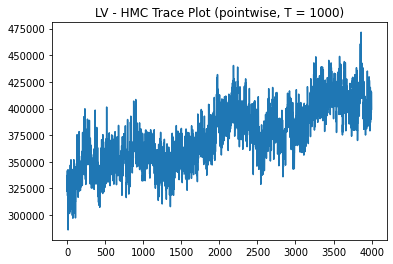

In [93]:
plt.plot(trace_val[4000:])
plt.title('LV - HMC Trace Plot (pointwise, T = 1000)')

Text(0.5, 1.0, 'alpha Starting from pointwise (Trained Hyper, T = 1000)')

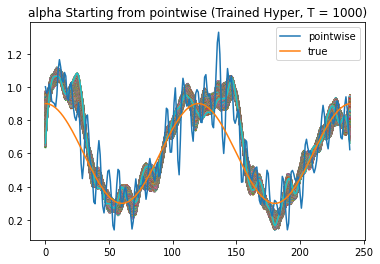

In [95]:
k = samples_1[4000:, 480:960]
val = np.zeros((240, 2))
for i in range(4000):
    for j in range(240):
        val[j] = k[i].reshape(-1, 2)[j]
    plt.plot(val[:, 0])

plt.plot(pointwise_theta[:, 0], label='pointwise')
plt.plot(alpha, label='true')
plt.legend()
plt.title('alpha Starting from pointwise (Trained Hyper, T = 1000)')

In [ ]:
class HMC_origin:
    def __init__(self, negllik, all_theta, xlatent_shape, theta_shape, sigma_shape, time_constant_param_ls, lsteps=50, epsilon=1e-6, n_samples=2000, upper_bound = None, lower_bound = None, burn_in_ratio = 0.5):
        self.all_theta = all_theta
        self.theta_shape = theta_shape
        self.xlatent_shape = xlatent_shape
        self.sigma_shape = sigma_shape
        self.constant_dim = len(time_constant_param_ls)
        self.lsteps = lsteps
        self.epsilon = epsilon * torch.ones(all_theta.shape)
        self.burn_in_ratio = burn_in_ratio
        self.n_samples = n_samples
        self.total_samples = int(n_samples / (1 - burn_in_ratio))
        self.NegLogLikelihood = negllik
        self.ub = upper_bound
        if upper_bound is not None:
            if upper_bound.shape[0] != all_theta.shape[0]:
                raise ValueError
        self.lb = lower_bound
        if lower_bound is not None:
            if lower_bound.shape[0] != all_theta.shape[0]:
                raise ValueError
    
    def NegLogLikelihood_vec(self, all_theta):
        xlatent_0, theta_0, sigma_0, constant_param_ls_0 = devectorize(all_theta, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
        return NegLogLikelihood(xlatent_0, theta_0, constant_param_ls_0, sigma_0)
    
    def Nabla(self, theta_torch):
        theta_torch = theta_torch.detach()
        xlatent, theta, sigma, constant_param_ls = devectorize(theta_torch, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
        xlatent.requires_grad = True  
        theta.requires_grad = True
        sigma.requires_grad = True
        for each in constant_param_ls:
            each.requires_grad = True                      
        llik = self.NegLogLikelihood(xlatent, theta, constant_param_ls, sigma)
        llik.backward()
        constant_param_deriv_ls = []
        for each in constant_param_ls:
            constant_param_deriv_ls.append(each.grad)
        v = vectorize(xlatent.grad, theta.grad, sigma.grad, constant_param_deriv_ls)
#         v = torch.clamp(v, min = -1e6)
#         v = torch.clamp(v, max = 1e6)
        print(v[:5])
        return v
    def sample(self, all_theta, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, KinvthetaList):
        def bounce(m, lb, ub):
            if lb is None and ub is None:
                return m
            if lb is None:
                max_tensor = torch.clamp(m - ub, min=0)
                return m - 2 * max_tensor
            if ub is None:
                min_tensor = torch.clamp(lb - m, min=0)
                return m + 2 * min_tensor
            if torch.sum(lb < ub) < m.shape[0]:
                raise ValueError
            if torch.sum(m >= lb) == m.shape[0] and torch.sum(m <= ub) == m.shape[0]:
                return m
            if torch.sum(m >= lb) < m.shape[0]:
                min_tensor = torch.clamp(lb - m, min=0)
                return bounce(m + 2 * min_tensor, lb, ub)
            if torch.sum(m <= ub) < m.shape[0]:
                max_tensor = torch.clamp(m - ub, min=0)
                return bounce(m - 2 * max_tensor, lb, ub)

        trace_val = np.zeros(self.total_samples)
        samples = np.zeros((self.total_samples, self.all_theta.shape[0]))
        random_ls = np.random.uniform(0, 1, self.total_samples)
        acceptance_ls = np.zeros(self.total_samples)
        nan_ls = np.zeros(self.total_samples)
        cur_theta = self.all_theta.clone().detach()
        for EachIter in range(self.total_samples): ############
            cur_nllik_1 = self.NegLogLikelihood_vec(cur_theta).detach()
            rstep = torch.rand(self.epsilon.shape) * self.epsilon + self.epsilon
            p = torch.normal(mean=0., std=torch.ones(self.all_theta.shape))
            cur_p = p.clone()
            theta = cur_theta.clone()         
            p = p - rstep * self.Nabla(theta).clone() / 2
            for i in range(self.lsteps):
                theta = theta + rstep * p
                nabla_torch = self.Nabla(theta).clone()
                p = p - rstep * nabla_torch
                theta = bounce(theta, self.lb, self.ub)
            
            p = p - rstep * self.Nabla(theta).clone() / 2
            
            new_nllik = self.NegLogLikelihood_vec(theta)
            new_p = 0.5 * torch.sum(torch.square(p))
            new_H = new_nllik + new_p
            cur_nllik = self.NegLogLikelihood_vec(cur_theta).detach()
            cur_H = cur_nllik + 0.5 * torch.sum(torch.square(cur_p))
            
            if torch.isnan(theta[0]) or torch.isnan(new_H):
                samples[EachIter] = cur_theta.clone()
                nan_ls[EachIter] = 1
                self.epsilon *= 0.9
            else:
                # accept
                tmp = float(torch.exp(cur_H - new_H))
                if  tmp > random_ls[EachIter]:
                    samples[EachIter] = theta.clone()
                    cur_theta = theta.clone()
                    acceptance_ls[EachIter] = 1
                    print('Accept:', new_H, cur_H)
                # reject
                else:
                    samples[EachIter] = cur_theta.clone()
                    print('Reject:', new_H, cur_H)
                    
            trace_val[EachIter] = self.NegLogLikelihood_vec(cur_theta).item()        

            if EachIter > 200 and EachIter < self.total_samples - self.n_samples:
                if np.sum(acceptance_ls[EachIter - 100 : EachIter]) < 60:
                    # decrease epsilon
                    self.epsilon *= 0.9
                if np.sum(acceptance_ls[EachIter - 100 : EachIter]) > 80:
                    # increase epsilon
                    self.epsilon *= 1.005
            if EachIter % 20 == 0 and EachIter > 20:
                print(EachIter)
                print('nllik: ', cur_nllik, ', cur_H: ', cur_H)
            if EachIter % 100 == 0 and EachIter > 100 and EachIter < self.total_samples - self.n_samples:
                print('acceptance rate: ', np.sum(acceptance_ls[EachIter - 100 : EachIter]) / 100)
                standard_deviation = torch.tensor(np.std(samples[EachIter - 100:EachIter, :], axis = 0))
                if torch.mean(standard_deviation) > 1e-6:
                    self.epsilon = 0.05 * standard_deviation * torch.mean(self.epsilon) / torch.mean(standard_deviation) + 0.95 * self.epsilon
        return samples, acceptance_ls, trace_val, nan_ls # [self.total_samples-self.n_samples:, :]

# all_theta = vectorize(TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
# all_theta_true = vectorize(true_x_torch, theta_true_torch, sigma_torch, time_constant_param_ls)
# all_theta_pointwise = vectorize(pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch, time_constant_param_ls)
sampler_origin = HMC_origin(NegLogLikelihood, all_theta, 
              pointwise_xlatent_torch.shape,
              pointwise_theta_torch.shape, 
              sigma_torch.shape,
              time_constant_param_ls,
             lower_bound = torch.zeros(all_theta.shape))
# sampler.Nabla(all_theta)
samples, b, c, d = sampler_origin.sample(all_theta, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, KinvthetaList)
# 
# print(sampler.NegLogLikelihood_vec(all_theta))
# sampler.sample(all_theta)
# 20 l step
# epsilon random start epsilon to 2 epsilon

In [44]:
all_theta_true = vectorize(true_x_torch, torch.ones(theta_true_torch.shape), sigma_torch, time_constant_param_ls)
sampler = HMC(NegLogLikelihood, all_theta_true, 
              pointwise_xlatent_torch.shape,
              pointwise_theta_torch.shape, 
              sigma_torch.shape,
              time_constant_param_ls,
              lower_bound = torch.zeros_like(all_theta_true))
print(sampler.Nabla(all_theta_true))

tensor([ 7.1277e+02,  5.6014e+01,  2.8777e+02, -1.0268e+02, -2.1538e+02,
        -1.2458e+02, -1.0815e+02, -9.6335e+01, -3.1653e+02,  2.3018e+01,
        -9.6130e+01,  3.0164e+01, -1.0997e+02,  7.9510e+01,  1.4145e+01,
         5.6928e+01,  1.9094e+01,  4.0588e+01, -5.4613e+00,  4.3612e+01,
         1.6061e+02, -1.3948e+01,  2.0539e+02,  1.3755e+01,  1.9942e+02,
         6.4733e+01,  1.6584e+02, -9.8330e+01,  1.9486e+02,  4.9077e+01,
         2.3054e+02,  8.2560e-01,  1.6156e+02, -1.6781e+02,  1.3787e+02,
         5.1143e+01,  1.7730e+02,  3.0537e-01,  1.2047e+02, -6.5531e+01,
         1.4720e+02, -4.8325e+01,  1.0412e+02, -3.6865e+01,  1.2195e+02,
        -1.1479e+02,  8.7163e+01, -8.8038e+01,  7.8414e+01, -6.0256e+01,
         5.6936e+01,  9.1225e-01,  6.5422e+01, -9.2556e+01,  6.2631e+01,
        -5.5247e+01,  5.8201e+01, -1.3995e+01,  6.8481e+01, -6.3447e+01,
         4.2024e+01, -3.9039e+01,  3.8835e+01, -6.8747e+01,  4.6966e+01,
        -4.7370e+01,  4.3067e+01, -4.9187e+01,  3.4

tensor(-1145.4520, dtype=torch.float64)
tensor(-560.3125, dtype=torch.float64)


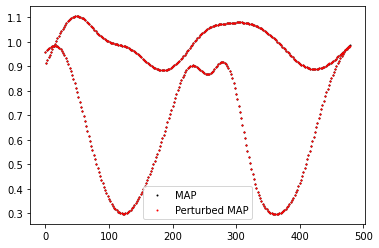

In [68]:
# np.amin(c)
# np.where(c == np.amin(c))
# samples[8543, 480:960]
all_theta = vectorize(TVMAGI_xlatent_torch, TVMAGI_theta_torch, sigma_torch, time_constant_param_ls)
# plt.scatter(np.arange(0, 480, 1), samples[8543, 480:960])
# plt.scatter(np.arange(0, 480, 1), all_theta[480:960])
sampler = HMC(NegLogLikelihood, all_theta, 
              pointwise_xlatent_torch.shape,
              pointwise_theta_torch.shape, 
              sigma_torch.shape,
              time_constant_param_ls,
              lower_bound = torch.zeros_like(all_theta))
print(sampler.NegLogLikelihood_vec(all_theta))
all_theta_2 = all_theta + 2e-5 * torch.randn(all_theta.shape)
print(sampler.NegLogLikelihood_vec(all_theta_2))
plt.scatter(np.arange(0, 480, 1), all_theta[480:960], s=1, color='black', label='MAP')
plt.scatter(np.arange(0, 480, 1), all_theta_2[480:960], s=1, color='red', label='Perturbed MAP')
plt.legend()

0.8392380952380952

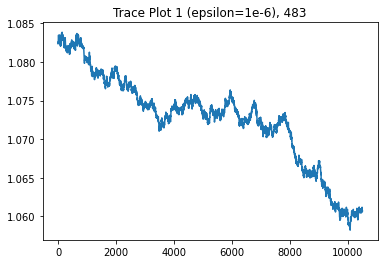

In [155]:
plt.plot(samples[2000:, 483])
plt.title(r'Trace Plot 1 (epsilon=1e-6), 483')
sum(b[2000:]) / len(b[2000:])
# sampler.epsilon

Text(0.5, 1.0, 'Likelihood trace plot (pointwise, trained hyper)')

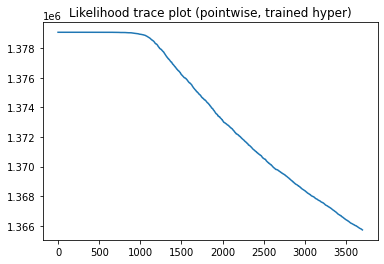

In [69]:
# np.savetxt('epsilon=1e-6, nsamples=10000, lsteps=300.txt', samples)
plt.plot(c[300:])
plt.title('Likelihood trace plot (pointwise, trained hyper)')
# np.savetxt('samples_pointwise_160000.txt', samples)

In [35]:
a = np.random.uniform(0, 1, 1000000)
np.sum(a <= 0.)

0

# Package

In [2]:
import numpy as np
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi
from arma import matrix

# Derivatves of X according to the ODE structure
def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * theta[3] * theta[2]  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    resultDx = np.zeros(shape=[np.shape(x)[0], np.shape(x)[1], np.shape(x)[1]])
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (1) / dI
    resultDx[:, 2, 0] = -theta[0] * np.exp(logI) / N
    # (1) / dS, (1) /dE, (1) / dD = 0
    # (2) / dS
    resultDx[:, 0, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dE
    resultDx[:, 1, 1] = -theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dI
    resultDx[:, 2, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dD = 0
    # (3) / dS = 0
    # (3) / dE
    resultDx[:, 1, 2] = np.exp(logE - logI) * theta[1]
    # (3) / dI
    resultDx[:, 2, 2] = -np.exp(logE - logI) * theta[1]
    # (3) / dD = 0, (4) / dS, dE = 0
    # (4) / dI
    resultDx[:, 2, 3] = np.exp(logI - logD) * theta[3] * theta[2]
    # (4) / dD
    resultDx[:, 3, 3] = -np.exp(logI - logD) * theta[3] * theta[2]
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns derivation of theta given x
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    global N
    resultDtheta = np.zeros(shape=[np.shape(x)[0], np.shape(theta)[0], np.shape(x)[1]])
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程对theta_i求导
    # (1) / dRe
    resultDtheta[:, 0, 0] = -np.exp(logI) / N
    # (2) / d theta[0]
    resultDtheta[:, 0, 1] = np.exp(logS + logI - logE) / N
    # (2) / theta[1]
    resultDtheta[:, 1, 1] = -1.
    # (3) / dtheta[1]
    resultDtheta[:, 1, 2] = np.exp(logE - logI)
    # (3) / dtheta[2]
    resultDtheta[:, 2, 2] = -1.
    # (4) / theta[2]
    resultDtheta[:, 2, 3] = np.exp(logI - logD) * theta[3] 
    # (4) / theta[3]
    resultDtheta[:, 3, 3] = np.exp(logI - logD) * theta[2]
    return resultDtheta

def fOdeTorch(theta, x, constant_param_ls, KthetaluList=None):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    # LU decomposition
    if KthetasqrtList is not None:
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = (-KthetaluList[0] @ theta[:, 0]) * torch.exp(logI) / N  # (1)
        logEdt = (KthetaluList[0] @ theta[:, 0]) * torch.exp(logS + logI - logE) / N - (KthetaluList[1] @ theta[:, 1])  # (2)
        logIdt = torch.exp(logE - logI) * (KthetaluList[1] @ theta[:, 1]) - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * (KthetaluList[2] @ theta[:, 2]) * constant_param_ls[0]  # (4)
    else:       
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = -theta[:, 0] * torch.exp(logI) / N  # (1)
        logEdt = theta[:, 0] * torch.exp(logS + logI - logE) / N - theta[:, 1]  # (2)
        logIdt = torch.exp(logE - logI) * theta[:, 1] - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * theta[:, 2] * constant_param_ls[0]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature,
                                 obs_per_day):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


def MaternKernel(d, phi_1, phi_2):
    """
    construct a kernel given time points and hyper parameters
    """
    a = torch.square(phi_1) * (
            1. + np.sqrt(5) * d / phi_2 + 5. * torch.square(d) / (3. * torch.square(phi_2))) * torch.exp(
        -np.sqrt(5) * d / phi_2)
    return a.double()


def kernelllik(phi_1, phi_2, sigma, y, d_matrix, phi1_lb=0.1, phi2_lb=10.):
    """
    optimize the kernel hyperparameters by maximizing marginal likelihood
    """
    phi_1_bounded = torch.clamp(phi_1, min=phi1_lb)
    phi_2_bounded = torch.clamp(phi_2, min=phi2_lb)
    K = MaternKernel(d_matrix, phi_1, phi_2)
    K += torch.square(sigma) * torch.eye(y.shape[0]).double()
    return -y.shape[0] * np.log(np.sqrt(2 * np.pi)) - 0.5 * y @ torch.inverse(K) @ y - 0.5 * torch.logdet(
        K) - 1e8 * torch.square(phi_1 - phi_1_bounded) - 1e6 * torch.square(phi_2 - phi_2_bounded)

def fOdeTorch(theta_LU, x, constant_param_ls, TV_theta_mean=None, KthetaluList=None):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    N = 100000
    # LU decomposition
    if KthetaluList is not None:
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = -(KthetaluList[0] @ theta_LU[:, 0] + TV_theta_mean[0]) * torch.exp(logI) / N  # (1)
        logEdt = (KthetaluList[0] @ theta_LU[:, 0] + TV_theta_mean[0]) * torch.exp(logS + logI - logE) / N - (KthetaluList[1] @ theta_LU[:, 1] + TV_theta_mean[1])  # (2)
        logIdt = torch.exp(logE - logI) * (KthetaluList[1] @ theta_LU[:, 1] + TV_theta_mean[1]) - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * (KthetaluList[2] @ theta_LU[:, 2] + TV_theta_mean[2]) * constant_param_ls[0]  # (4)
    else:       
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = -theta_LU[:, 0] * torch.exp(logI) / N  # (1)
        logEdt = theta_LU[:, 0] * torch.exp(logS + logI - logE) / N - theta_LU[:, 1]  # (2)
        logIdt = torch.exp(logE - logI) * theta_LU[:, 1] - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * theta_LU[:, 2] * constant_param_ls[0]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)

def xthetasigmallikTorch(xlatent, theta_LU, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                         priorTemperature, KthetaluList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta_LU.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta_LU, xlatent, time_constant_param_ls, inferred_theta, KthetaluList)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    res2 = torch.zeros(1).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(torch.square(theta_LU[:, thetaEachDim]-inferred_theta[thetaEachDim]))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return torch.sum(res) + torch.sum(res_theta)


def TVMAGI_solver(obs_per_day=1,
                  discretization=2,
                  theta_lowerbound=np.array([0., 0., 0., 0.]),
                  theta_upperbound=np.array([np.inf, 1., 1., 1.]),
                  MAGI_niter=15001,
                  param_names = ['re', 've', 'vi', 'pd'],
                  is_time_varying=[True, True, False, True],
                  pointwise_niter=150000,
                  kernel_niter=60000,
                  TVMAGI_niter=100000,
                  phi1_lb_ls=np.array([0.1, 0.1, 0.1]),
                  phi2_lb_ls=np.array([0.1, 0.1, 0.1]),
                  use_trajectory='inferred',
                  learning_rate=np.array([1e-5, 1e-3, 1e-4])):
    
    nobs, p_dim = yobs.shape[0], yobs.shape[1]
    days = nobs / obs_per_day
    n_points = nobs * discretization
    theta_dim = theta_lowerbound.shape[0]
    d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
    for i in range(n_points):
        for j in range(n_points):
            if i > j:
                d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
            else:
                d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
    Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                             thetaLowerBound=theta_lowerbound,
                             thetaUpperBound=theta_upperbound)
    tvecObs = np.arange(0, days, 1. / obs_per_day)
    tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
    yFull = np.ndarray([n_points, p_dim])
    yFull.fill(np.nan)
    yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
    xInitExogenous = np.zeros_like(yFull)
    # interpolate: find the ydata of tvecFull given observations
    for i in range(p_dim):
        xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
    # First stage: use MAGI package to optimize theta as constant
    result = solve_magi(
        yFull,
        Ode_system,
        tvecFull,
        sigmaExogenous=np.array([]),
        phiExogenous=np.array([[]]),
        xInitExogenous=xInitExogenous,
        thetaInitExogenous=np.array([]),
        muExogenous=np.array([[]]),
        dotmuExogenous=np.array([[]]),
        priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
        priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
        priorTemperatureObs=1.0,
        kernel="generalMatern",
        nstepsHmc=100,
        burninRatioHmc=0.5,
        niterHmc=MAGI_niter,
        stepSizeFactorHmc=0.01,
        nEpoch=1,
        bandSize=40,
        useFrequencyBasedPrior=True,
        useBand=False,
        useMean=False,
        useScalerSigma=False,
        useFixedSigma=False,
        verbose=True)
    samplesCpp = result['samplesCpp']
    llikId = 0
    xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
    # dimension of theta
    thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
    sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
    burnin = int(MAGI_niter * 0.5)
    xsampled = samplesCpp[xId, (burnin + 1):]
    xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
    CovAllDimensionsPyList = []
    thetaSampled = samplesCpp[thetaId, (burnin + 1):]
    inferred_theta = np.mean(thetaSampled, axis=-1)
    sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
    inferred_sigma = np.mean(sigmaSampled, axis=-1)
    inferred_trajectory = np.mean(xsampled, axis=-1)
    for each_gpcov in result['result_solved'].covAllDimensions:
            each_pycov = dict(
                Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
                Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
                mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
            )
            CovAllDimensionsPyList.append(each_pycov)
            
    # Second stage, pointwise estimation of theta
    TV_theta_mean = np.zeros(int(sum(is_time_varying)))
    tv_index = 0
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == True:
            TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
            tv_index += 1

    if use_trajectory == 'observation':
        pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
    elif use_trajectory == 'inferred':
        pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
    else:
        raise ValueError
    tmp1 = np.array([TV_theta_mean])
    initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
    pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
    sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
    time_constant_param_ls = []
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == 0:
            param_name = param_names[thetaEachDim]
            locals()[param_name] = torch.tensor(inferred_theta[thetaEachDim], requires_grad=True, dtype=torch.double)
            time_constant_param_ls.append(eval(param_name))

    ydata = torch.from_numpy(yFull).double()
    priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
    pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=learning_rate[0])  # , weight_decay = 1.0
    for epoch in range(pointwise_niter):
        pointwise_optimizer.zero_grad()
        # compute loss function
        llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                            TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature, obs_per_day)
        loss = -llik
        if epoch % 100 == 0:
            print(epoch, loss.item())
        # compute gradient and update parameters
        #     if loss < -345. and epoch > 50000:
        #         break
        loss.backward()
        pointwise_optimizer.step()
        
    pointwise_theta = pointwise_theta_torch.detach().numpy()
    hyperparamList = []
    # optimize the hyperparameters of kernels
    for thetaEachDimension in range(pointwise_theta.shape[1]):
        phi_1 = torch.tensor(1., requires_grad=True, dtype=torch.double)
        phi_2 = torch.tensor(20.0, requires_grad=True, dtype=torch.double)
        sigma = torch.tensor(0.001, requires_grad=True, dtype=torch.double)
        kernel_optimizer = torch.optim.Adam([phi_1, phi_2, sigma], lr=learning_rate[1])
        for epoch in range(kernel_niter):
            kernel_optimizer.zero_grad()
            loss = -kernelllik(phi_1, 
                               phi_2, 
                               sigma, 
                               pointwise_theta_torch[:, thetaEachDimension] - torch.mean(pointwise_theta_torch[:, thetaEachDimension]), 
                               d_matrix, 
                               phi1_lb_ls[thetaEachDimension], 
                               phi2_lb_ls[thetaEachDimension])
            loss.backward()
            kernel_optimizer.step()
            if epoch % 100 == 0:
                print(epoch, loss.item())
        print(phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item())
        hyperparamList.append([phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()])

    KthetaList = []
    KthetaluList = []
    KinvthetaList = []
    KinvthetaluList = []
    for thetaEachDimension in range(pointwise_theta.shape[1]):
        ker = MaternKernel(d_matrix, torch.tensor(hyperparamList[thetaEachDimension][0]), torch.tensor(hyperparamList[thetaEachDimension][1]))
        KthetaList.append(ker)
        L_mat = torch.cholesky(ker)
        KthetaluList.append(L_mat)
        L_inv = torch.inverse(L_mat)
        KinvthetaluList.append(L_inv)
        
    TVMAGI_xlatent_torch = torch.tensor(pointwise_xlatent_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
    TVMAGI_theta_torch = torch.tensor(pointwise_theta_torch.detach().numpy(), dtype=torch.double)
    TVMAGI_theta_torch_LU = torch.zeros(TVMAGI_theta_torch.shape).double()
    for thetaEachDim in range(TVMAGI_theta_torch.shape[1]):
        TVMAGI_theta_torch_LU[:, thetaEachDim] = KinvthetaluList[thetaEachDim] @ (TVMAGI_theta_torch[:, thetaEachDim] - inferred_theta[thetaEachDim])
    TVMAGI_theta_torch_LU.requires_grad = True
    TVMAGI_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
    TVMAGI_optimizer = torch.optim.Adam([TVMAGI_xlatent_torch, TVMAGI_theta_torch_LU, TVMAGI_sigma_torch] + time_constant_param_ls, lr=learning_rate[2])
    for epoch in range(TVMAGI_niter):
        TVMAGI_optimizer.zero_grad()
        # compute loss function
        llik = xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch_LU, time_constant_param_ls, TVMAGI_sigma_torch,
                                                    TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                    priorTemperature, KthetaluList)
        loss = -llik
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        TVMAGI_optimizer.step()
    
    tv_theta_ls = np.zeros(TVMAGI_theta_torch_LU.shape)
    for thetaEachDim in range(TVMAGI_theta_torch_LU.shape[1]):
        TVMAGI_theta_torch = (KthetaluList[thetaEachDim] @ TVMAGI_theta_torch_LU.detach()[:, thetaEachDim]) + TV_theta_mean[thetaEachDim]
        theta_np = TVMAGI_theta_torch.numpy()
        tv_theta_ls[:, thetaEachDim] = theta_np.copy()
    
#     param_dict = {}
#     constant_index, tv_index = 0, 0
#     for thetaEachDim in range(theta_dim):
#         if is_time_varying[thetaEachDim] == True:
#             param_dict[param_names[thetaEachDim]] = tv_theta_ls[:, tv_index].copy()
#             tv_index += 1
#         else:
#             param_dict[param_names[thetaEachDim]] = time_constant_param_ls[constant_index].item()
#             constant_index += 1
    return tv_theta_ls, time_constant_param_ls

In [3]:
a, b = TVMAGI_solver(obs_per_day=1,
                  discretization=2,
                  theta_lowerbound=np.array([0., 0., 0., 0.]),
                  theta_upperbound=np.array([np.inf, 1., 1., 1.]),
                  MAGI_niter=15001,
                  param_names = ['re', 've', 'vi', 'pd'],
                  is_time_varying=[True, True, False, True],
                  pointwise_niter=150000,
                  kernel_niter=60000,
                  TVMAGI_niter=100000,
                  phi1_lb_ls=np.array([0.1, 0.1, 0.1]),
                  phi2_lb_ls=np.array([0.1, 0.1, 0.1]),
                  use_trajectory='inferred',
                  learning_rate=np.array([1e-5, 1e-3, 1e-3]))

0 -95.89162522619533


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


100 -128.4379605213447
200 -131.1606111513363
300 -131.44630763245578
400 -131.6698000103461
500 -131.88498785792623
600 -132.09587448112836
700 -132.3038634786692
800 -132.5099801621835
900 -132.7151300225027
1000 -132.92012587801554
1100 -133.12568504219172
1200 -133.33242815116444
1300 -133.54090132984817
1400 -133.75157548184956
1500 -133.9648586280438
1600 -134.18110734369898
1700 -134.40064032135822
1800 -134.62374559523442
1900 -134.85067499384076
2000 -135.08165025267402
2100 -135.31687684553648
2200 -135.55653025346965
2300 -135.80075867354628
2400 -136.0496977440463
2500 -136.3034581236237
2600 -136.5621285149665
2700 -136.82578777005534
2800 -137.0944860148776
2900 -137.36825947169316
3000 -137.64714333146105
3100 -137.9311486453879
3200 -138.22026456659103
3300 -138.51448236050504
3400 -138.8137707090167
3500 -139.1180753856251
3600 -139.42735673405855
3700 -139.74154800913198
3800 -140.06055141986758
3900 -140.3842824885361
4000 -140.71263526343967
4100 -141.04549300908138

32500 -271.0960090446129
32600 -271.67172985509296
32700 -272.2455559718953
32800 -272.81739401346454
32900 -273.3871680471055
33000 -273.95480234276295
33100 -274.52020265048293
33200 -275.0832993841864
33300 -275.6440134009428
33400 -276.2022374307511
33500 -276.7578848046925
33600 -277.3108771650817
33700 -277.86109280195296
33800 -278.40845481619283
33900 -278.9528425334989
34000 -279.4941532784314
34100 -280.0322714409316
34200 -280.5670851775056
34300 -281.0984760723838
34400 -281.62632983187075
34500 -282.15051940213914
34600 -282.67092317206055
34700 -283.18740235775704
34800 -283.6998625751527
34900 -284.2081140200575
35000 -284.7121043100214
35100 -285.21166028455735
35200 -285.70661815040245
35300 -286.196869568978
35400 -286.682236381119
35500 -287.1626409292244
35600 -287.6378856850565
35700 -288.10783650405835
35800 -288.57234154415494
35900 -289.0312727177569
36000 -289.4844928337625
36100 -289.93186096055166
36200 -290.3732590499884
36300 -290.8085677806668
36400 -291.2

64800 -354.3899012319774
64900 -354.6228115428192
65000 -354.85604769664064
65100 -355.08959152967907
65200 -355.3234611104308
65300 -355.5576395106445
65400 -355.7921088884793
65500 -356.0269182417212
65600 -356.26201627352054
65700 -356.4974111951893
65800 -356.7331174419526
65900 -356.96910959535444
66000 -357.205349272557
66100 -357.44198641040873
66200 -357.67885082918326
66300 -357.91600220416103
66400 -358.1534377873004
66500 -358.3911483551918
66600 -358.6291200627651
66700 -358.8673614261411
66800 -359.1059076637168
66900 -359.344695323336
67000 -359.58374013302745
67100 -359.8230099175423
67200 -360.0625707042138
67300 -360.30239390794765
67400 -360.5424460876708
67500 -360.7827138197114
67600 -361.0232491227692
67700 -361.26399538582933
67800 -361.50498837715963
67900 -361.7461921041352
68000 -361.9876149087691
68100 -362.22924665560106
68200 -362.47109805406546
68300 -362.71315202554683
68400 -362.955405439986
68500 -363.1978547757584
68600 -363.4404914400162
68700 -363.683

97100 -419.3840516170302
97200 -419.4702131140706
97300 -419.5554621107518
97400 -419.6397269916888
97500 -419.72304718114157
97600 -419.8054115077949
97700 -419.88682020560236
97800 -419.9672333839239
97900 -420.04677780142174
98000 -420.12531996978447
98100 -420.2029091436001
98200 -420.27956924351895
98300 -420.35526751657085
98400 -420.4300069943006
98500 -420.5038093065815
98600 -420.5766594779908
98700 -420.6485860593881
98800 -420.7195343672778
98900 -420.7896111207014
99000 -420.858717367685
99100 -420.92692100328736
99200 -420.9941985993349
99300 -421.0605618731021
99400 -421.12601282989914
99500 -421.19051527903946
99600 -421.25419613652434
99700 -421.31690338192817
99800 -421.3788699271883
99900 -421.43987945395713
100000 -421.50002453757264
100100 -421.55931078125684
100200 -421.6177400100804
100300 -421.6753294996555
100400 -421.73207835891674
100500 -421.78800030968466
100600 -421.8430907157333
100700 -421.89738535737837
100800 -421.95086682209535
100900 -422.003545315059

128400 -425.41696366809504
128500 -425.4169567239556
128600 -425.4169645048602
128700 -425.41693972013877
128800 -425.4169259041561
128900 -425.4169584966304
129000 -425.4169590405152
129100 -425.41696278752397
129200 -425.4169646763156
129300 -425.4169615080502
129400 -425.41696296406303
129500 -425.4169648932184
129600 -425.41695599163813
129700 -425.4169487994865
129800 -425.41695666722916
129900 -425.4169641014537
130000 -425.41693554412495
130100 -425.4169620905779
130200 -425.4169610121028
130300 -425.41696460138655
130400 -425.4169537903997
130500 -425.416963968499
130600 -425.41696269521304
130700 -425.4169578343271
130800 -425.4169562297288
130900 -425.41696357166904
131000 -425.4169638868116
131100 -425.4169639468684
131200 -425.4169626793155
131300 -425.4169631619104
131400 -425.4169606219035
131500 -425.41695505576035
131600 -425.41696425913267
131700 -425.4169608776143
131800 -425.4169628145277
131900 -425.41695498189927
132000 -425.4169602765952
132100 -425.4169517629895


10500 -34.41066451796897
10600 -34.619873529524014
10700 -34.82185406688973
10800 -35.016899316527514
10900 -35.205293854967536
11000 -35.38731461009192
11100 -35.56323164729919
11200 -35.733308804661235
11300 -35.897804207942315
11400 -36.056970695481624
11500 -36.211056184913275
11600 -36.36030400861078
11700 -36.50495324113544
11800 -36.64523903808961
11900 -36.78139300163676
12000 -36.91364358469568
12100 -37.042216544161164
12200 -37.16733545198407
12300 -37.28922227375541
12400 -37.408098025574475
12500 -37.52418351997197
12600 -37.63770021771501
12700 -37.748871201774875
12800 -37.857922298535925
12900 -37.96508337265459
13000 -38.070589835569024
13100 -38.1746844098499
13200 -38.277619212591674
13300 -38.37965823235291
13400 -38.48108029910699
13500 -38.58218267770269
13600 -38.68328545366347
13700 -38.784736940184956
13800 -38.88692040675326
13900 -38.990262542203155
14000 -39.09524421244811
14100 -39.20241428806
14200 -39.31240762526281
14300 -39.42596873860005
14400 -39.5439

43400 -97.28689595704941
43500 -97.28689592886927
43600 -97.28689595695178
43700 -97.28644300536789
43800 -97.28689585935528
43900 -97.28689556236148
44000 -97.28689595702104
44100 -97.28689595660268
44200 -97.28688112351216
44300 -97.28689594631946
44400 -97.28689595690676
44500 -97.28689594984318
44600 -97.28585669357415
44700 -97.2868957146984
44800 -97.28689595687065
44900 -97.28689593760541
45000 -97.28689595544793
45100 -97.28689438725931
45200 -97.28689595680247
45300 -97.28689595697607
45400 -97.2868959446458
45500 -97.286844914077
45600 -97.28689595583262
45700 -97.2868958977559
45800 -97.28689595709129
45900 -97.28684658479693
46000 -97.28689593894634
46100 -97.28689595697689
46200 -97.2868959545491
46300 -97.28689029503127
46400 -97.28689572839885
46500 -97.28689595576073
46600 -97.28689595678075
46700 -97.28689595636021
46800 -97.28686233711875
46900 -97.28689592958469
47000 -97.28689595705052
47100 -97.28689587518512
47200 -97.28541425673853
47300 -97.2868957745051
47400 -

16100 -254.86801297682084
16200 -255.2288576165493
16300 -255.53236561162495
16400 -255.9057413572622
16500 -256.26208279677553
16600 -256.5755304715989
16700 -256.9840952731633
16800 -257.3467083727114
16900 -257.7305852346608
17000 -258.1154153923171
17100 -258.48096003838043
17200 -258.90212435198634
17300 -259.24307396979657
17400 -259.6835649289625
17500 -258.8149803707714
17600 -259.315510997858
17700 -259.57316229457047
17800 -259.81998598473075
17900 -259.2692131561083
18000 -259.8367951950462
18100 -259.8519586213159
18200 -259.1654271980657
18300 -259.75872087880714
18400 -259.6860910760911
18500 -259.6254156904719
18600 -259.54909175833217
18700 -259.532156426488
18800 -259.7181692188613
18900 -259.7708962975704
19000 -259.5989111040001
19100 -259.2941530995269
19200 -259.86575343956275
19300 -259.896298684012
19400 -259.8179212266891
19500 -259.48035101978735
19600 -259.43716213140783
19700 -259.5686916791638
19800 -259.84050635165124
19900 -259.29370172555866
20000 -259.82

48500 -259.7522139887587
48600 -259.6526241647708
48700 -259.41483700284425
48800 -259.7846525787078
48900 -259.63253231622195
49000 -259.65880078585826
49100 -259.7798275158503
49200 -259.8628469045833
49300 -259.88435608362676
49400 -258.90560518616394
49500 -259.6083606074202
49600 -259.89147079086604
49700 -259.39566619245375
49800 -259.7772181274237
49900 -259.9159426879822
50000 -259.64102241632247
50100 -259.86543963128184
50200 -259.304574075206
50300 -259.9000294495527
50400 -259.47798787271336
50500 -259.8960337564954
50600 -259.86016863010775
50700 -259.59349619132286
50800 -259.6646035974674
50900 -259.7306820978191
51000 -259.8652797098146
51100 -259.680037485149
51200 -259.5820429534909
51300 -259.28006568007277
51400 -259.84004146679655
51500 -259.50852235182197
51600 -259.849579911213
51700 -259.28160495046313
51800 -259.8387378929717
51900 -259.66040639036305
52000 -259.8645838154901
52100 -259.29558321893023
52200 -259.3965392937632
52300 -259.84602250783155
52400 -25

21300 -46.79984947519023
21400 -46.82081046199259
21500 -46.841773072245104
21600 -46.862734768899344
21700 -46.88369292769616
21800 -46.90464483320994
21900 -46.92558767492639
22000 -46.94651854334582
22100 -46.96743442610796
22200 -46.98833220412371
22300 -47.009208647714544
22400 -47.03006041275309
22500 -47.05088403680209
22600 -47.07167593524761
22700 -47.09243239743057
22800 -47.11314958277231
22900 -47.13382351689823
23000 -47.15445008776308
23100 -47.175025041781794
23200 -47.19554397997085
23300 -47.21600235410929
23400 -47.236395462928556
23500 -47.256718448339996
23600 -47.27696629171595
23700 -47.29713381023609
23800 -47.317215653319764
23900 -47.33720629916175
24000 -47.357100051394184
24100 -47.37689103590107
24200 -47.396573197814035
24300 -47.41614029872093
24400 -47.435585914125625
24500 -47.454903431198545
24600 -47.47408604686473
24700 -47.493126766281335
24800 -47.51201840176108
24900 -47.530753572207715
25000 -47.549324703133465
25100 -47.567724027339324
25200 -47.

54100 -94.25445994076358
54200 -94.25445959738853
54300 -94.25445997889642
54400 -94.25445997893604
54500 -94.25443045847442
54600 -94.25445997667822
54700 -94.25445997893578
54800 -94.2544597700282
54900 -94.25356435064359
55000 -94.2544599665527
55100 -94.25445996910487
55200 -94.25445997893702
55300 -94.25445875584137
55400 -94.25444419475373
55500 -94.25445997790568
55600 -94.2544598552094
55700 -94.25445997893466
55800 -94.25445995768035
55900 -94.25445876880687
56000 -94.25445997888892
56100 -94.2544599789357
56200 -94.25445068998762
56300 -94.25442258466938
56400 -94.2544599761824
56500 -94.25445997892461
56600 -94.25445995657611
56700 -94.25445997796852
56800 -94.25445995904272
56900 -94.25445221775604
57000 -94.25445997885359
57100 -94.25445997893625
57200 -94.2544579878211
57300 -94.2544446613143
57400 -94.25445997858714
57500 -94.25445997859333
57600 -94.25445997785421
57700 -94.25445997893569
57800 -94.25438291725725
57900 -94.254458829385
58000 -94.2544599789066
58100 -94.

26800 -297.7714503648322
26900 -297.8321606065098
27000 -297.8327680933081
27100 -297.7769232561839
27200 -297.8131466960898
27300 -297.84000050250694
27400 -297.8149303701167
27500 -297.83959921858326
27600 -297.82064077069697
27700 -297.8277700016796
27800 -297.8232688623764
27900 -297.8191082053667
28000 -297.77977442952266
28100 -297.82673910591654
28200 -297.8313747690471
28300 -297.7894980605238
28400 -297.58524968269575
28500 -297.7735679816865
28600 -297.4248201386345
28700 -297.83882001580355
28800 -297.8413289182033
28900 -297.82507723398834
29000 -297.81717226900787
29100 -297.8103972965321
29200 -297.8373522276886
29300 -297.8351648502313
29400 -297.8304219379603
29500 -297.84130960897943
29600 -297.46819049267987
29700 -297.8149976701789
29800 -297.8186677818794
29900 -297.65481604937935
30000 -297.8148956065049
30100 -297.8270633731565
30200 -297.7710180755018
30300 -297.81618275734854
30400 -297.8316942723129
30500 -297.82958472544556
30600 -297.8097343771634
30700 -297.

59200 -297.76427679005945
59300 -297.83494750076
59400 -297.8210607284742
59500 -297.84786437359287
59600 -297.81690880015174
59700 -297.8201964235829
59800 -297.8341925497012
59900 -297.8153395182594
60000 -297.8014322917672
60100 -297.7846058107327
60200 -297.8015468112904
60300 -297.82525224162174
60400 -297.839072599686
60500 -297.8358378854466
60600 -297.8224939800393
60700 -297.6941193607502
60800 -297.8300802617573
60900 -297.8340173088617
61000 -297.77986242907775
61100 -297.82754374812095
61200 -297.81387445947985
61300 -297.81790788590763
61400 -297.8373135629317
61500 -297.83836506183343
61600 -297.8323844469885
61700 -297.7250827982167
61800 -297.7993964745341
61900 -297.74295109763113
62000 -297.83428984035817
62100 -297.81717226098084
62200 -297.62743424232536
62300 -297.80729947786665
62400 -297.83740100047004
62500 -297.82655210251755
62600 -297.7603012550016
62700 -297.83044947603923
62800 -297.8328741941558
62900 -297.75774265523336
63000 -297.80550490312703
63100 -29

91500 -297.8077985280172
91600 -297.76339047646024
91700 -297.46609045968535
91800 -297.81006424250194
91900 -297.8052240330047
92000 -297.80396953473354
92100 -297.77391856423003
92200 -297.7955202386521
92300 -297.8344495087305
92400 -297.5760881415984
92500 -297.7911894572426
92600 -297.56304861009795
92700 -297.7902921335567
92800 -297.8168632252575
92900 -297.81483188243726
93000 -297.7557979767304
93100 -297.8330283031078
93200 -297.79498045273715
93300 -297.821431945659
93400 -297.80959370299536
93500 -297.8129518324389
93600 -297.8371682459341
93700 -297.8271601061796
93800 -297.4618201144185
93900 -297.79427282321103
94000 -297.7863089355633
94100 -297.8221488291666
94200 -297.83313298027974
94300 -297.7166516482387
94400 -297.80993569192026
94500 -297.79941978562306
94600 -297.835251707402
94700 -297.79956245869124
94800 -297.73824103970276
94900 -297.75587543205893
95000 -297.6688268185679
95100 -297.7684953139152
95200 -297.82361206624023
95300 -297.83795049835146
95400 -29

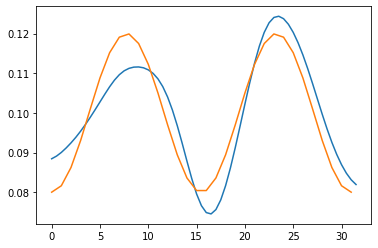

In [13]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, 32, 0.5), a[:, 1])
plt.plot(true_ve)

In [5]:
b

[tensor(0.0980, dtype=torch.float64, requires_grad=True)]